## File imports and settings


In [2]:
%load_ext autoreload
%autoreload 2

import os
import psutil

###This is for Windows users...python will default to only using "E" cores
desired_cpus = list(range(20))  # CPUs 0 through 11


p = psutil.Process(os.getpid())


p.cpu_affinity(desired_cpus)

print("CPU affinity set to:", p.cpu_affinity())
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import pandas as pd
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split

import psutil
import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' ### this hides some of the annoying tflow errors
#### this depends on the hardware
from pathlib import Path ####Required for save checks
import prince ####Required for MCA functions
skip = False
import j_process ####Required to load custom modeling functions
import j_clustertuner####Required for best K functions
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices('GPU'))




CPU affinity set to: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
TensorFlow version: 2.18.0
GPU devices: []


In [3]:
df = pd.read_parquet("filtered.parquet")

In [4]:
df.head()

,CVDINFR4,CVDCRHD4,CVDSTRK3,ASTHMA3,CHCSCNC1,CHCOCNC1,CHCCOPD3,CHCKDNY2,HAVARTH4,DIABETE4,EDUCA,DEAF,BLIND,DECIDE,DIFFWALK,DIFFDRES,DIFFALON,SMOKE100,ECIGNOW2,FLUSHOT7,PNEUVAC4,SEATBELT,COVIDPO1,GENHLTH,EXERANY2,TOLDHI3
0,No,No,No,No - Go to Section 07.06 CHCSCNC1,No,No,No,No,No,Yes,College 1 year to 3 years (Some college or tec...,No,No,No,Yes,No,No,No - Go to Section 12.03 USENOW3,Never used e-cigarettes in your entire life,No - Go to Section 13.03 PNEUVAC4,No,Always,No - Go to Modules or Closing Statement,Very good,No - Go to Section 04.08 STRENGTH,No
1,No,No,No,No - Go to Section 07.06 CHCSCNC1,No,No,No,No,Yes,No - Go to Section 08.01 AGE,College 1 year to 3 years (Some college or tec...,Yes,No,No,No,No,No,No - Go to Section 12.03 USENOW3,Never used e-cigarettes in your entire life,Yes,Yes,Always,No - Go to Modules or Closing Statement,Very good,Yes,Yes
2,No,No,No,Yes,No,No,No,No,Yes,No - Go to Section 08.01 AGE,Grade 12 or GED (High school graduate),Don't know/Not Sure,Yes,Yes,Yes,No,No,Yes,Never used e-cigarettes in your entire life,Yes,Yes,Always,No - Go to Modules or Closing Statement,Fair,Yes,Yes
3,No,No,No,No - Go to Section 07.06 CHCSCNC1,Yes,Yes,No,No,Yes,No - Go to Section 08.01 AGE,College 1 year to 3 years (Some college or tec...,No,No,No,Yes,No,No,No - Go to Section 12.03 USENOW3,Never used e-cigarettes in your entire life,Yes,Yes,Always,No - Go to Modules or Closing Statement,Very good,Yes,No
4,No,No,No,No - Go to Section 07.06 CHCSCNC1,No,Yes,No,No,Yes,Yes,College 1 year to 3 years (Some college or tec...,No,No,Yes,Yes,No,Yes,No - Go to Section 12.03 USENOW3,Never used e-cigarettes in your entire life,No - Go to Section 13.03 PNEUVAC4,Yes,Always,No - Go to Modules or Closing Statement,Fair,Yes,No


In [5]:
#Just a function to help me visualize each feature

def i_graph(colname):
    ig_counts = df[colname].value_counts(dropna=False)
    
    print("Value counts for", colname)
    print(ig_counts)
    


In [6]:
def repval(colname, stringstorepl):
    df[colname] = df[colname].replace(stringstorepl,np.nan)
    rg_counts = df[colname].value_counts(dropna=False)





In [7]:


def basic_plot(colname):
    rg_counts = df[colname].value_counts(dropna=False)
    rg_ax = rg_counts.plot(kind='bar')
    plt.title('Counts per Category')
    plt.xlabel('Category')
    plt.ylabel('Count')

    for i, v in enumerate(rg_counts):
        rg_ax.text(i, v + max(rg_counts) * 0.01, str(v), ha='center', va='bottom')

    plt.tight_layout()

    # Ensure the images directory exists
    os.makedirs("images", exist_ok=True)

    rg_title = colname
    rg_filename = rg_title.replace(" ", "_").replace("/", "-") + ".jpg"
    filepath = os.path.join("images", rg_filename)

    plt.savefig(filepath, format='jpg', dpi=300)
    plt.show()

## Cleaned up variables

In [9]:
default = ["Don't know/Not sure","Refused","Missing","Don't know / Not sure","Don't know/Not Sure"]
repval("CVDINFR4", ["Don't know/Not sure", "Refused", "Missing"])
repval("CVDCRHD4", ["Don't know/Not sure", "Refused", "Missing"])
repval("CVDSTRK3", default)
df["ASTHMA3"] = df["ASTHMA3"].replace(["No -  Go to Section 07.06 CHCSCNC1"], "No")
repval("ASTHMA3",
       ["Don't know/Not Sure -  Go to Section 07.06 CHCSCNC1", "Refused -  Go to Section 07.06 CHCSCNC1", "Missing"])
repval("CHCSCNC1", default)
repval("CHCOCNC1", default)
repval("CHCCOPD3", default)
repval("CHCKDNY2", default)
repval("HAVARTH4", default)
df["DIABETE4"]=df["DIABETE4"].replace(["No -  Go to Section 08.01 AGE"],"No")
repval("DIABETE4", ["No, pre-diabetes or borderline diabetes -  Go to Section 08.01 AGE", "Yes, but female told only during pregnancy -  Go to Section 08.01 AGE", "Don't know/Not Sure -  Go to Section 08.01 AGE", "Refused -  Go to Section 08.01 AGE"])
df["EDUCA"]=df["EDUCA"].replace(["College 4 years or more (College graduate)"],"Bachelors degree or Higher")
df["EDUCA"]=df["EDUCA"].replace(["College 1 year to 3 years (Some college or technical school)"],"Some College or Associates")
df["EDUCA"]=df["EDUCA"].replace(["Grade 12 or GED (High school graduate)"],"High School Graduate")
df["EDUCA"]=df["EDUCA"].replace(["Grades 9 through 11 (Some high school)"],"Some High School")
df["EDUCA"]=df["EDUCA"].replace(["Grades 1 through 8 (Elementary)"],"Elementary Only")
df["EDUCA"]=df["EDUCA"].replace(["Never attended school or only kindergarten"],"None or Kindergarten Only")
repval("EDUCA", default)
repval("DEAF", default)
repval("BLIND", default)
repval("DECIDE", default)
repval("DIFFWALK", default)
repval("DIFFDRES", default)
repval("DIFFALON", default)
df["SMOKE100"]=df["SMOKE100"].replace(["No -  Go to Section 12.03 USENOW3"],"No")
df["SMOKE100"]=df["SMOKE100"].replace(["Don't know/Not Sure -  Go to Section 12.03 USENOW3"],"Don't know/Not Sure")
df["SMOKE100"]=df["SMOKE100"].replace(["Refused -  Go to Section 12.03 USENOW3"],"Refused")
repval("SMOKE100", default)
df["ECIGNOW2"]=df["ECIGNOW2"].replace(["Never used e-cigarettes in your entire life"],"Never")
df["ECIGNOW2"]=df["ECIGNOW2"].replace(["Not at all (right now)"],"Not Currently")
df["ECIGNOW2"]=df["ECIGNOW2"].replace(["Use them some days"],"Some Days")
df["ECIGNOW2"]=df["ECIGNOW2"].replace(["Use them every day"],"Every Day")
df["FLUSHOT7"]=df["FLUSHOT7"].replace(["No -  Go to Section 13.03 PNEUVAC4"],"No")
df["FLUSHOT7"]=df["FLUSHOT7"].replace(["Don't know/Not Sure -  Go to Section 13.03 PNEUVAC4"],"Don't know/Not sure")
df["FLUSHOT7"]=df["FLUSHOT7"].replace(["Refused -  Go to Section 13.03 PNEUVAC4"],"Refused")
repval("ECIGNOW2", default)
repval("FLUSHOT7", default)
repval("PNEUVAC4", default)
df["SEATBELT"]=df["SEATBELT"].replace(["Never drive or ride in a car -  Go to Section 16.1 COVIDPO1"],"Refused")

repval("SEATBELT", default)
df["COVIDPO1"]=df["COVIDPO1"].replace(["No -  Go to Modules or Closing Statement"],"No")
df["COVIDPO1"]=df["COVIDPO1"].replace(["Refused -  Go to Modules or Closing Statement"],"Refused")
df["COVIDPO1"]=df["COVIDPO1"].replace(["Don't know/Not Sure -  Go to Modules or Closing Statement"],"Don't know/Not sure")

repval("COVIDPO1", default)
repval("GENHLTH", default)
df["EXERANY2"]=df["EXERANY2"].replace(["No -  Go to Section 04.08 STRENGTH"],"No")
df["EXERANY2"]=df["EXERANY2"].replace(["Don't know/Not Sure -  Go to Section 04.08 STRENGTH"],"Don't know/Not sure")
df["EXERANY2"]=df["EXERANY2"].replace(["Refused -  Go to Section 04.08 STRENGTH"],"Refused")

repval("EXERANY2", default)
repval("TOLDHI3", default)

In [10]:
j_process.resp_tally2(df)

,CVDINFR4,CVDINFR4_count,CVDCRHD4,CVDCRHD4_count,CVDSTRK3,CVDSTRK3_count,ASTHMA3,ASTHMA3_count,CHCSCNC1,CHCSCNC1_count,CHCOCNC1,CHCOCNC1_count,CHCCOPD3,CHCCOPD3_count,CHCKDNY2,CHCKDNY2_count,HAVARTH4,HAVARTH4_count,DIABETE4,DIABETE4_count,EDUCA,EDUCA_count,DEAF,DEAF_count,BLIND,BLIND_count,DECIDE,DECIDE_count,DIFFWALK,DIFFWALK_count,DIFFDRES,DIFFDRES_count,DIFFALON,DIFFALON_count,SMOKE100,SMOKE100_count,ECIGNOW2,ECIGNOW2_count,FLUSHOT7,FLUSHOT7_count,PNEUVAC4,PNEUVAC4_count,SEATBELT,SEATBELT_count,COVIDPO1,COVIDPO1_count,GENHLTH,GENHLTH_count,EXERANY2,EXERANY2_count,TOLDHI3,TOLDHI3_count
0,No,407304.0,No,405638.0,No,413499.0,No,367256.0,No,393826.0,No,380431.0,No,398160.0,No,410876.0,No,287999.0,No,358706.0,Bachelors degree or Higher,184867,No,379796.0,No,395423.0,No,365547.0,No,348452.0,No,399108.0,No,381959.0,No,251981.0,Never,318696.0,No,204711.0,No,208403.0,Always,350207.0,Yes,201248.0,Good,144209.0,Yes,325227.0,No,219333.0
1,Yes,23451.0,Yes,23454.0,Yes,18350.0,Yes,64366.0,Yes,36567.0,Yes,50555.0,Yes,33097.0,Yes,20555.0,Yes,142764.0,Yes,59786.0,Some College or Associates,114346,Yes,38735.0,Yes,22190.0,Yes,49648.0,Yes,67021.0,nan,17676.0,Yes,31964.0,Yes,158774.0,Not Currently,69110.0,Yes,197294.0,Yes,162037.0,nan,32378.0,No,197981.0,Very good,142115.0,No,106845.0,Yes,158906.0
2,nan,2568.0,nan,4231.0,nan,1474.0,nan,1701.0,nan,2930.0,nan,2337.0,nan,2066.0,nan,1892.0,nan,2560.0,nan,14826.0,High School Graduate,106613,nan,14792.0,nan,15710.0,nan,18128.0,nan,17850.0,Yes,16539.0,nan,19400.0,nan,22568.0,nan,23251.0,nan,31318.0,nan,62883.0,Nearly always,28281.0,nan,34094.0,Excellent,63410.0,nan,1251.0,nan,55084.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Missing,5.0,Some High School,16161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Some Days,11164.0,NaN,NaN,NaN,NaN,Sometimes,10885.0,NaN,NaN,Fair,61955.0,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Elementary Only,8324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Every Day,11102.0,NaN,NaN,NaN,NaN,Never,7263.0,NaN,NaN,Poor,20372.0,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,2325,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Seldom,4309.0,NaN,NaN,nan,1262.0,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Kindergarten Only,687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
print(df.isna().sum())
print(df.shape)
df.dropna(inplace=True)
print(df.shape)


CVDINFR4     2568
CVDCRHD4     4231
CVDSTRK3     1474
ASTHMA3      1701
CHCSCNC1     2930
CHCOCNC1     2337
CHCCOPD3     2066
CHCKDNY2     1892
HAVARTH4     2560
DIABETE4    14826
EDUCA        2325
DEAF        14792
BLIND       15710
DECIDE      18128
DIFFWALK    17850
DIFFDRES    17676
DIFFALON    19400
SMOKE100    22568
ECIGNOW2    23251
FLUSHOT7    31318
PNEUVAC4    62883
SEATBELT    32378
COVIDPO1    34094
GENHLTH      1262
EXERANY2     1251
TOLDHI3     55084
dtype: int64
(433323, 26)
(292773, 26)


In [12]:
columns_to_check = ['CVDINFR4', 'CVDCRHD4', 'CVDSTRK3','ASTHMA3','CHCSCNC1','CHCOCNC1','CHCCOPD3','CHCKDNY2','HAVARTH4','DIABETE4']
chronic_col = columns_to_check
df['ALL_CHRONIC'] = df[columns_to_check].eq('Yes').any(axis=1).map({True: 'Yes', False: 'No'})


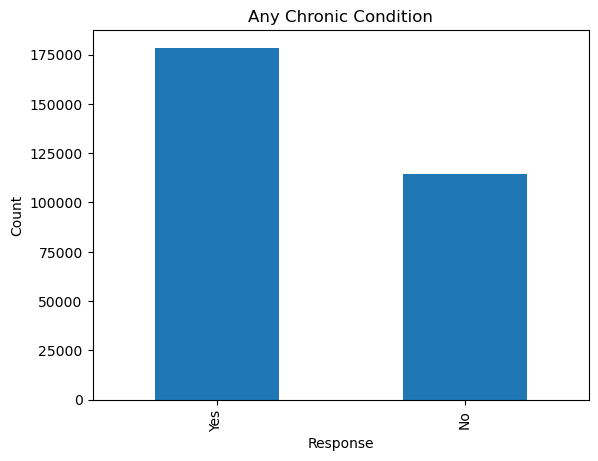

ALL_CHRONIC
Yes    0.609797
No     0.390203
Name: proportion, dtype: float64

In [13]:
df['ALL_CHRONIC'].value_counts(dropna=False)
df['ALL_CHRONIC'].value_counts().plot(kind='bar')
plt.title('Any Chronic Condition')
plt.xlabel('Response')
plt.ylabel('Count')
title = plt.gca().get_title()
filename = title.replace(" ", "_").replace("/", "-") + ".jpg"
filename = os.path.join("images",filename)
plt.savefig(filename, format='jpg', dpi=300)
plt.show()
df['ALL_CHRONIC'].value_counts(normalize=True, dropna=False)

In [14]:
columns_to_check = ['CVDINFR4', 'CVDCRHD4', 'CVDSTRK3','ASTHMA3','CHCSCNC1','CHCOCNC1','CHCCOPD3','CHCKDNY2','DIABETE4']

df['ALL_CHRONIC2'] = df[columns_to_check].eq('Yes').any(axis=1).map({True: 'Yes', False: 'No'})

In [15]:
columns_to_check = ['CVDINFR4', 'CVDCRHD4', 'CVDSTRK3']

df['ALL_CARDIAC'] = df[columns_to_check].eq('Yes').any(axis=1).map({True: 'Yes', False: 'No'})

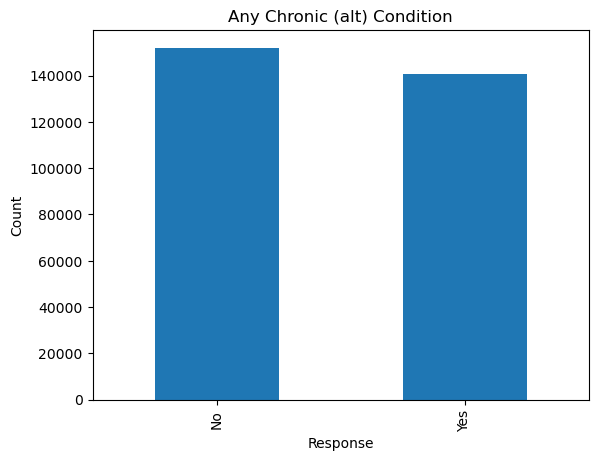

ALL_CHRONIC2
No     0.51959
Yes    0.48041
Name: proportion, dtype: float64

In [16]:
df['ALL_CHRONIC2'].value_counts(dropna=False)
df['ALL_CHRONIC2'].value_counts().plot(kind='bar')
plt.title('Any Chronic (alt) Condition')
plt.xlabel('Response')
plt.ylabel('Count')
title = plt.gca().get_title()
filename = title.replace(" ", "_").replace("/", "-") + ".jpg"
filename = os.path.join("images",filename)
plt.savefig(filename, format='jpg', dpi=300)
plt.show()
df['ALL_CHRONIC2'].value_counts(normalize=True, dropna=False)

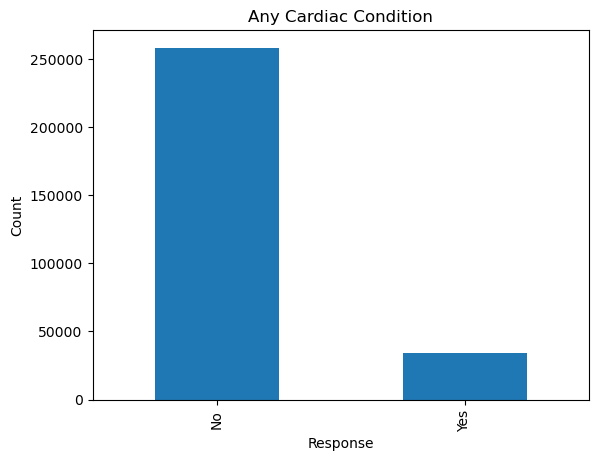

ALL_CARDIAC
No     0.882219
Yes    0.117781
Name: proportion, dtype: float64

In [17]:
df['ALL_CARDIAC'].value_counts(dropna=False)
df['ALL_CARDIAC'].value_counts().plot(kind='bar')
plt.title('Any Cardiac Condition')
plt.xlabel('Response')
plt.ylabel('Count')
title = plt.gca().get_title()
filename = title.replace(" ", "_").replace("/", "-") + ".jpg"
filename = os.path.join("images",filename)
plt.savefig(filename, format='jpg', dpi=300)
plt.show()
df['ALL_CARDIAC'].value_counts(normalize=True, dropna=False)

In [18]:
columns_to_check = ['CHCSCNC1','CHCOCNC1']

df['ALL_CANCER'] = df[columns_to_check].eq('Yes').any(axis=1).map({True: 'Yes', False: 'No'})

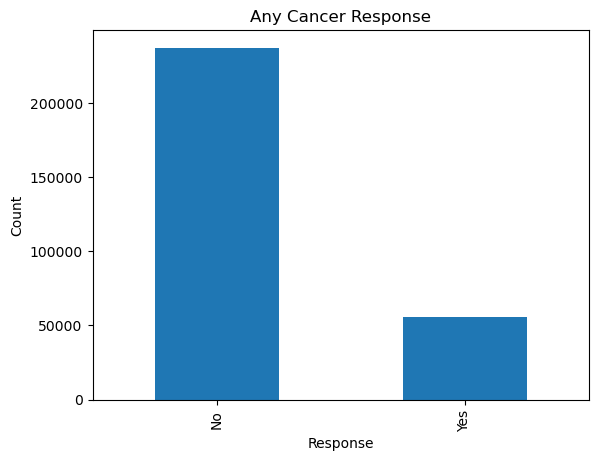

ALL_CANCER
No     0.809986
Yes    0.190014
Name: proportion, dtype: float64

In [19]:
df['ALL_CANCER'].value_counts(dropna=False)
df['ALL_CANCER'].value_counts().plot(kind='bar')
plt.title('Any Cancer Response')
plt.xlabel('Response')
plt.ylabel('Count')
title = plt.gca().get_title()
filename = title.replace(" ", "_").replace("/", "-") + ".jpg"
filename = os.path.join("images",filename)
plt.savefig(filename, format='jpg', dpi=300)
plt.show()
df['ALL_CANCER'].value_counts(normalize=True, dropna=False)

In [20]:
columns_to_check = ['ASTHMA3','CHCCOPD3']

df['ALL_PUL'] = df[columns_to_check].eq('Yes').any(axis=1).map({True: 'Yes', False: 'No'})

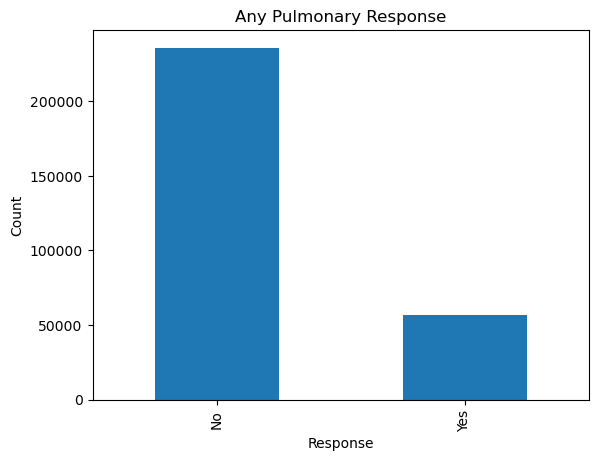

ALL_PUL
No     0.805812
Yes    0.194188
Name: proportion, dtype: float64

In [21]:
df['ALL_PUL'].value_counts(dropna=False)
df['ALL_PUL'].value_counts().plot(kind='bar')
plt.title('Any Pulmonary Response')
plt.xlabel('Response')
plt.ylabel('Count')
title = plt.gca().get_title()
filename = title.replace(" ", "_").replace("/", "-") + ".jpg"
filename = os.path.join("images",filename)
plt.savefig(filename, format='jpg', dpi=300)
plt.show()
df['ALL_PUL'].value_counts(normalize=True, dropna=False)

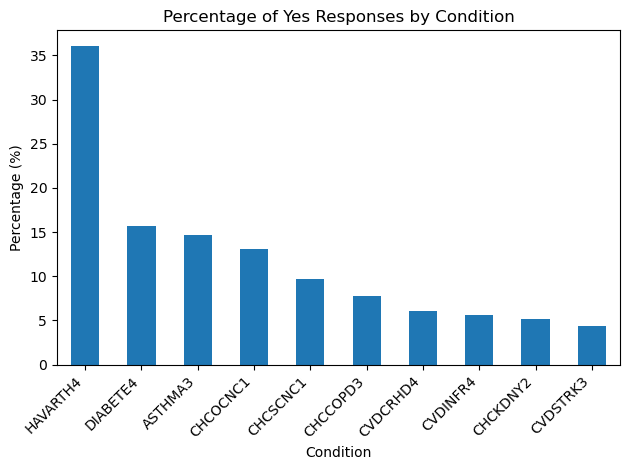

In [22]:


columns_to_check = [
    'CVDINFR4', 'CVDCRHD4', 'CVDSTRK3',
    'ASTHMA3', 'CHCSCNC1', 'CHCOCNC1',
    'CHCCOPD3', 'CHCKDNY2', 'HAVARTH4', 'DIABETE4'
]
yes_rates = {
    col: (df[col] == "Yes").mean() * 100  
    for col in columns_to_check
}


yes_df = pd.Series(yes_rates).sort_values(ascending=False)

ax = yes_df.plot(kind='bar')
plt.title('Percentage of Yes Responses by Condition')
plt.ylabel('Percentage (%)')
plt.xlabel('Condition')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
title = plt.gca().get_title()
filename = title.replace(" ", "_").replace("/", "-") + ".jpg"
filename = os.path.join("images",filename)
plt.savefig(filename, format='jpg', dpi=300)
plt.show()


In [23]:
column_list = df.columns.tolist()
print(column_list)
feature_list = [col for col in column_list if col not in chronic_col]
deriv_col = ['ALL_CHRONIC','ALL_CARDIAC','ALL_CANCER','ALL_PUL','ALL_CHRONIC2']

['CVDINFR4', 'CVDCRHD4', 'CVDSTRK3', 'ASTHMA3', 'CHCSCNC1', 'CHCOCNC1', 'CHCCOPD3', 'CHCKDNY2', 'HAVARTH4', 'DIABETE4', 'EDUCA', 'DEAF', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'SMOKE100', 'ECIGNOW2', 'FLUSHOT7', 'PNEUVAC4', 'SEATBELT', 'COVIDPO1', 'GENHLTH', 'EXERANY2', 'TOLDHI3', 'ALL_CHRONIC', 'ALL_CHRONIC2', 'ALL_CARDIAC', 'ALL_CANCER', 'ALL_PUL']


In [24]:
feature_list = [col for col in feature_list if col not in deriv_col]
print(feature_list)

['EDUCA', 'DEAF', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'SMOKE100', 'ECIGNOW2', 'FLUSHOT7', 'PNEUVAC4', 'SEATBELT', 'COVIDPO1', 'GENHLTH', 'EXERANY2', 'TOLDHI3']



Value counts for EDUCA:
EDUCA
Bachelors degree or Higher    134661
Some College or Associates     77986
High School Graduate           66431
Some High School                9033
Elementary Only                 4368
None or Kindergarten Only        294
Name: count, dtype: int64


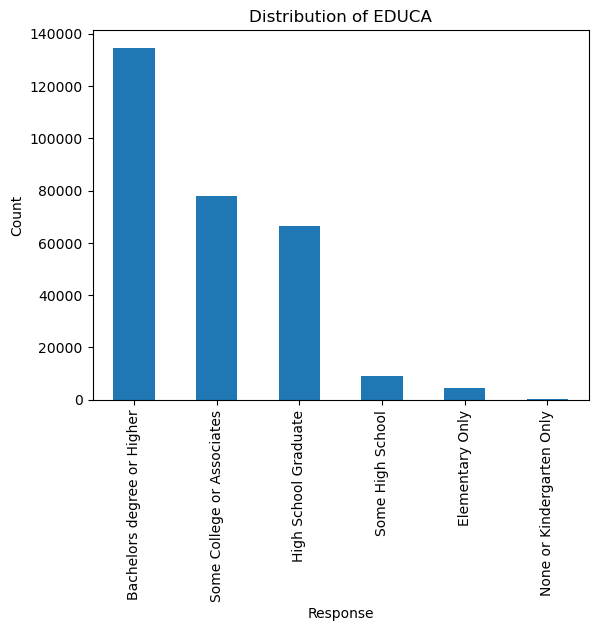


Value counts for DEAF:
DEAF
No     265699
Yes     27074
Name: count, dtype: int64


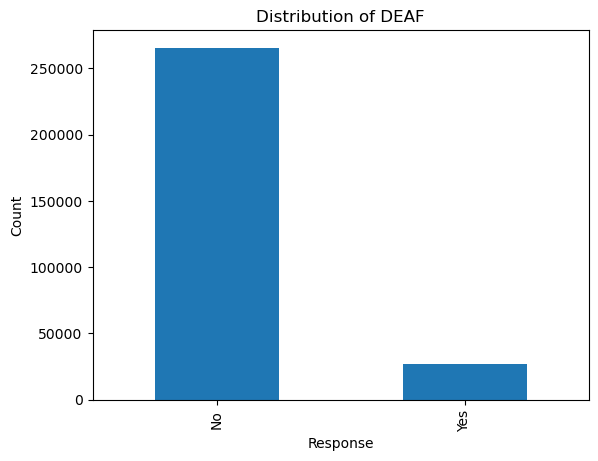


Value counts for BLIND:
BLIND
No     278366
Yes     14407
Name: count, dtype: int64


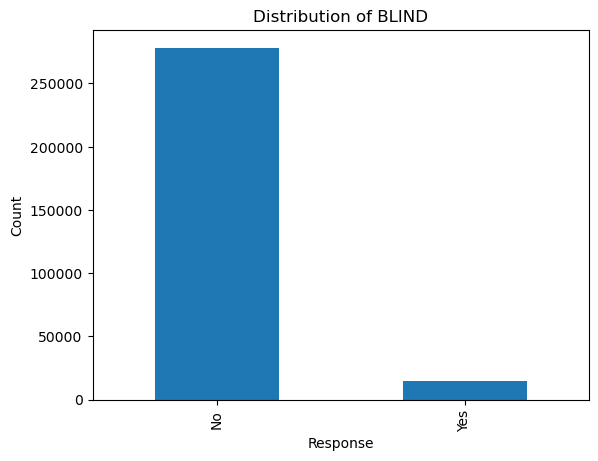


Value counts for DECIDE:
DECIDE
No     263172
Yes     29601
Name: count, dtype: int64


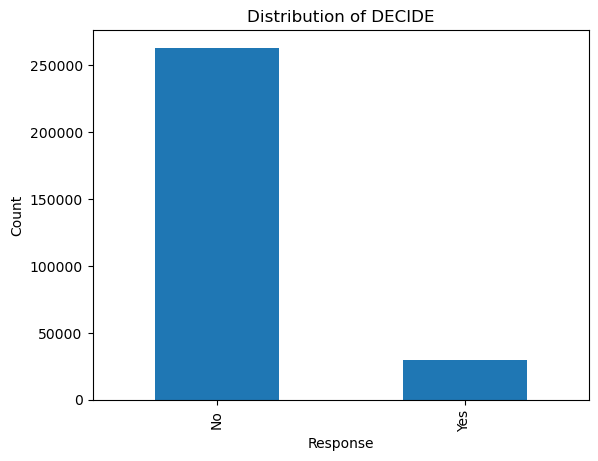


Value counts for DIFFWALK:
DIFFWALK
No     245793
Yes     46980
Name: count, dtype: int64


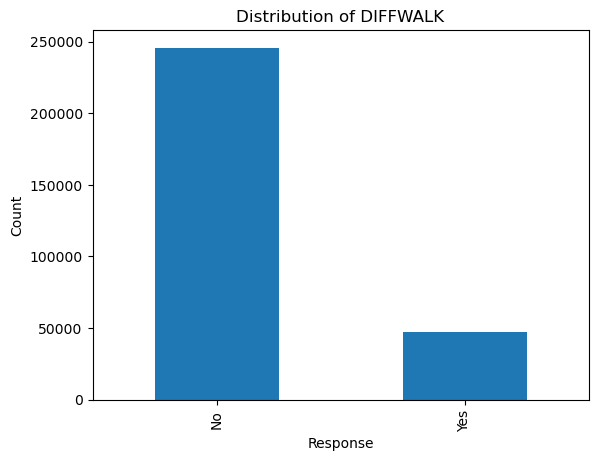


Value counts for DIFFDRES:
DIFFDRES
No     282083
Yes     10690
Name: count, dtype: int64


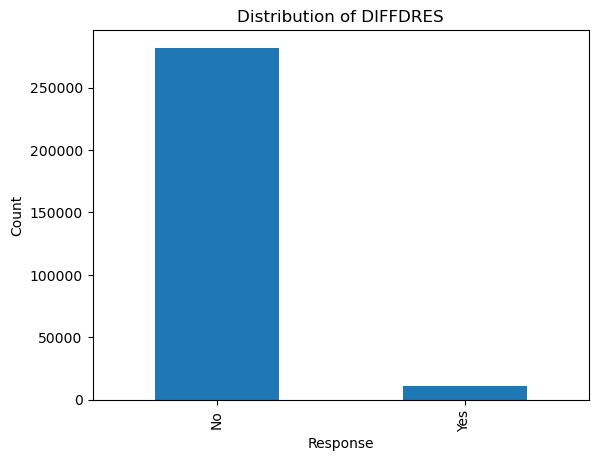


Value counts for DIFFALON:
DIFFALON
No     272651
Yes     20122
Name: count, dtype: int64


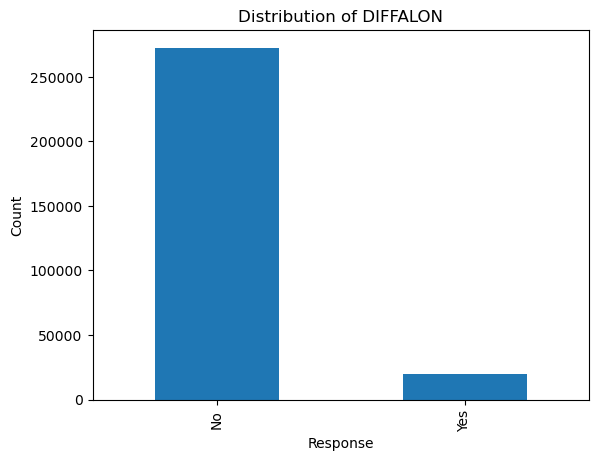


Value counts for SMOKE100:
SMOKE100
No     178357
Yes    114416
Name: count, dtype: int64


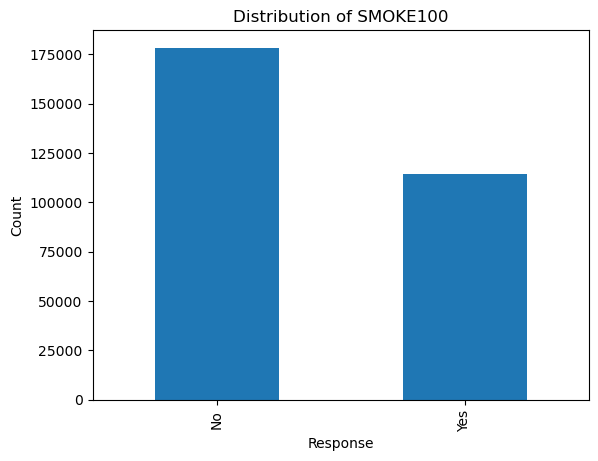


Value counts for ECIGNOW2:
ECIGNOW2
Never            235691
Not Currently     44771
Some Days          6372
Every Day          5939
Name: count, dtype: int64


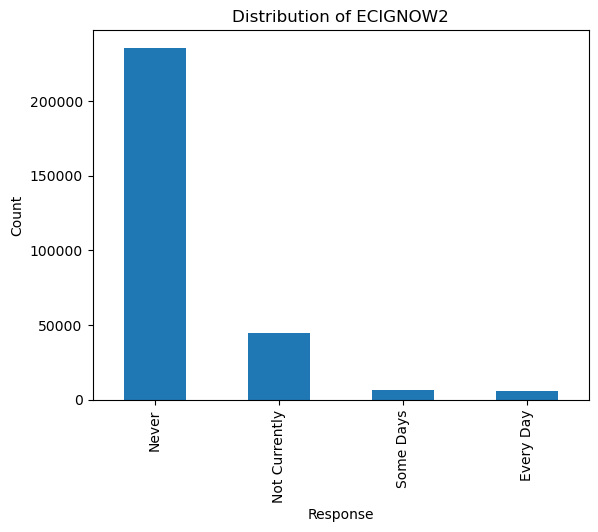


Value counts for FLUSHOT7:
FLUSHOT7
Yes    153135
No     139638
Name: count, dtype: int64


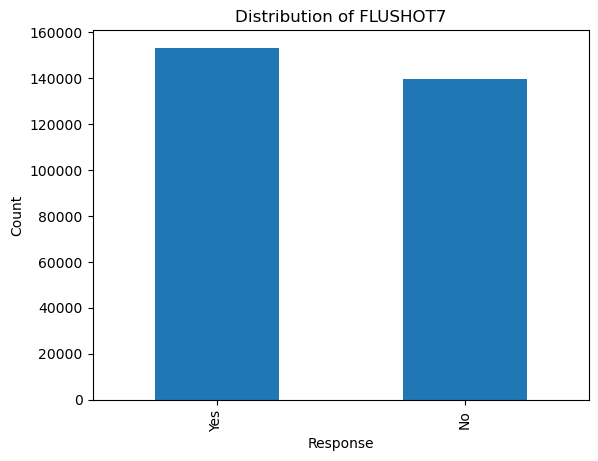


Value counts for PNEUVAC4:
PNEUVAC4
No     159816
Yes    132957
Name: count, dtype: int64


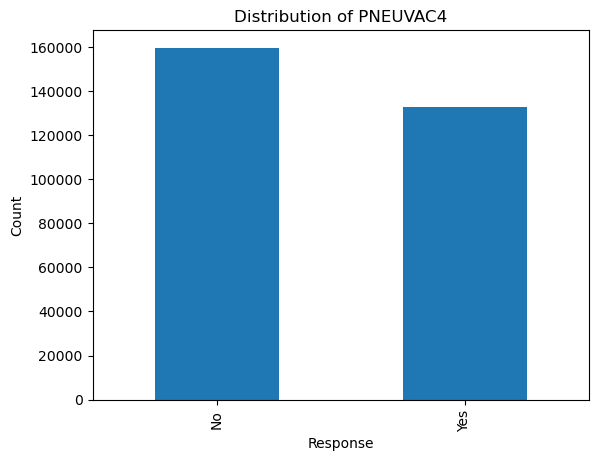


Value counts for SEATBELT:
SEATBELT
Always           259449
Nearly always     19013
Sometimes          6973
Never              4618
Seldom             2720
Name: count, dtype: int64


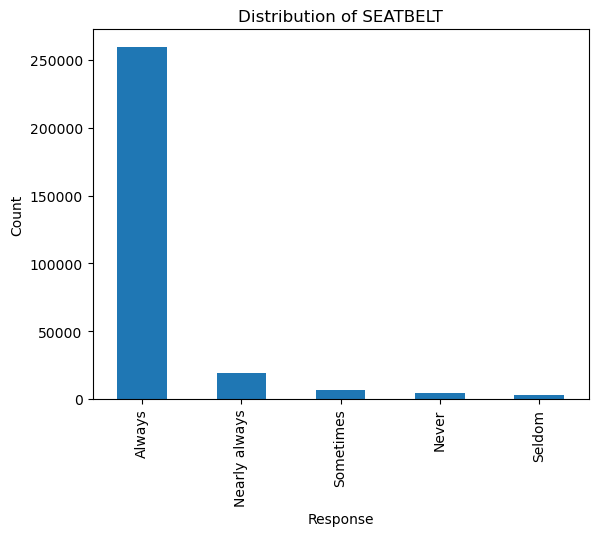


Value counts for COVIDPO1:
COVIDPO1
Yes    148942
No     143831
Name: count, dtype: int64


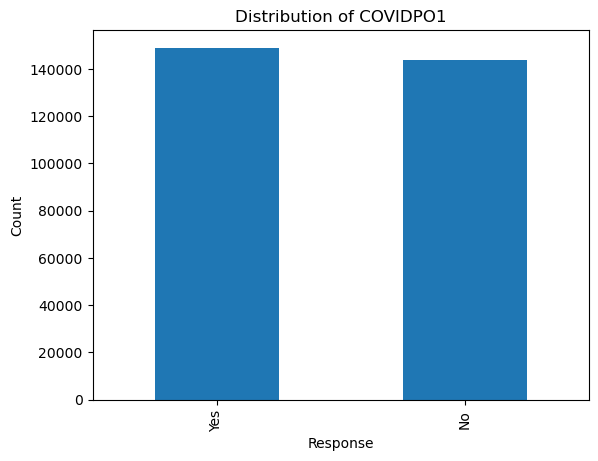


Value counts for GENHLTH:
GENHLTH
Very good    100540
Good          96688
Excellent     42846
Fair          40032
Poor          12667
Name: count, dtype: int64


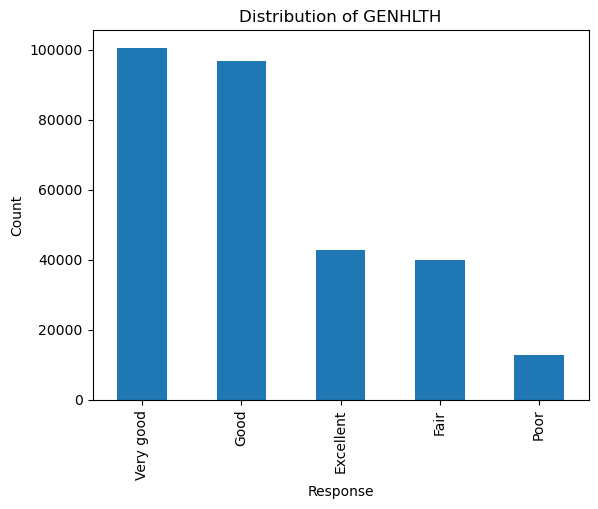


Value counts for EXERANY2:
EXERANY2
Yes    223709
No      69064
Name: count, dtype: int64


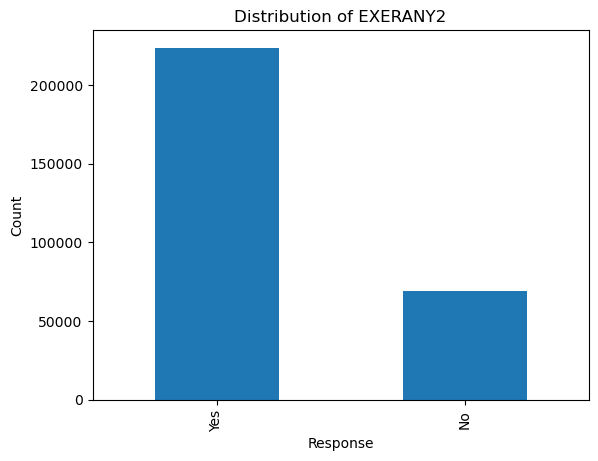


Value counts for TOLDHI3:
TOLDHI3
No     168946
Yes    123827
Name: count, dtype: int64


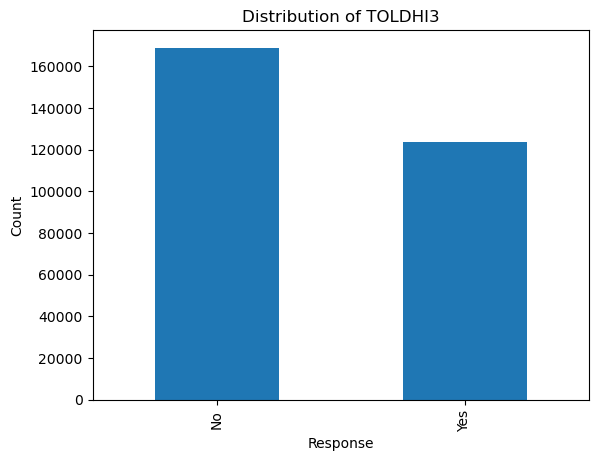

In [25]:
for col in feature_list:
    counts = df[col].value_counts(dropna=False)

    # Print counts for reference
    print(f"\nValue counts for {col}:\n{counts}")

    # Plot
    ax = counts.plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.xlabel('Response')
    plt.ylabel('Count')
    title = plt.gca().get_title()
    filename = title.replace(" ", "_").replace("/", "-") + ".jpg"
    filename = os.path.join("images",filename)
    plt.savefig(filename, format='jpg', dpi=300)

    #plt.tight_layout()
    plt.show()

In [26]:
bool_feat = ['DEAF', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES',
              'DIFFALON', 'SMOKE100', 'FLUSHOT7', 'PNEUVAC4',
               'COVIDPO1', 'EXERANY2', 'TOLDHI3']
cat_feat=['GENHLTH', 'SEATBELT','ECIGNOW2','EDUCA']

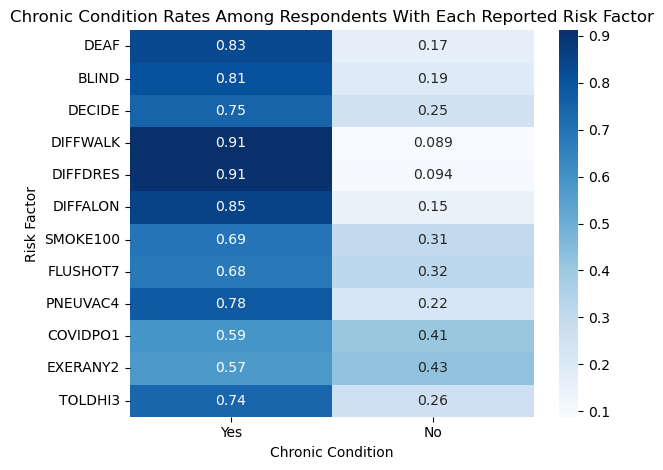

In [27]:
lifestyle_factors = bool_feat  
heat_data = {}

for col in lifestyle_factors:
    yes_rate = df[df[col] == 'Yes']['ALL_CHRONIC'].value_counts(normalize=True)
    heat_data[col] = yes_rate

heat_df = pd.DataFrame(heat_data).T.fillna(0)

sns.heatmap(heat_df, annot=True, cmap='Blues')
plt.title("Chronic Condition Rates Among Respondents With Each Reported Risk Factor")
plt.ylabel("Risk Factor")
plt.xlabel("Chronic Condition")
plt.tight_layout()
filename="chronic_condition_heatmap.jpg"
filename = os.path.join("images",filename)
plt.savefig(filename, format='jpg', dpi=300, bbox_inches='tight')

plt.show()


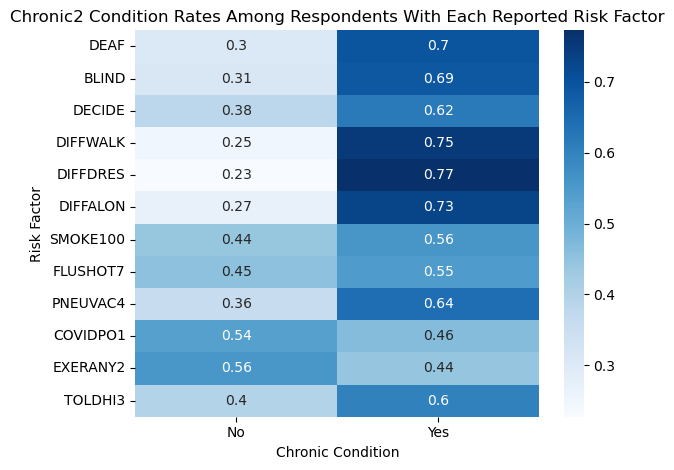

In [28]:
heat_data = {}

for col in lifestyle_factors:
    yes_rate = df[df[col] == 'Yes']['ALL_CHRONIC2'].value_counts(normalize=True)
    heat_data[col] = yes_rate

heat_df = pd.DataFrame(heat_data).T.fillna(0)

sns.heatmap(heat_df, annot=True, cmap='Blues')
plt.title("Chronic2 Condition Rates Among Respondents With Each Reported Risk Factor")
plt.ylabel("Risk Factor")
plt.xlabel("Chronic Condition")
plt.tight_layout()
filename="chronic2_condition_heatmap.jpg"
filename = os.path.join("images",filename)
plt.savefig(filename, format='jpg', dpi=300, bbox_inches='tight')

plt.show()

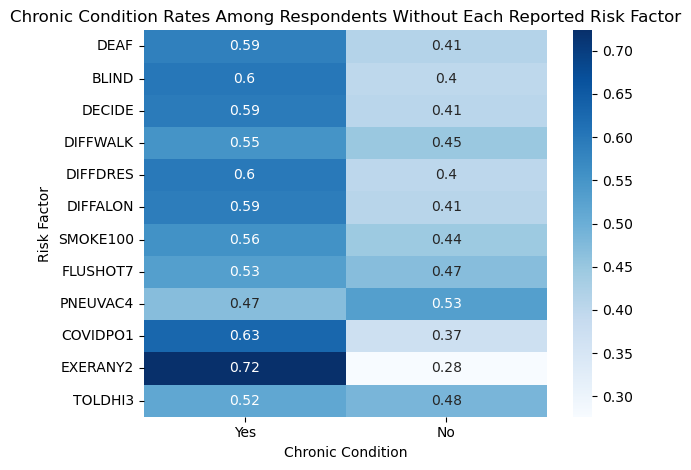

In [29]:
heat_data={}
for col in lifestyle_factors:
    yes_rate = df[df[col] == 'No']['ALL_CHRONIC'].value_counts(normalize=True)
    heat_data[col] = yes_rate

heat_df = pd.DataFrame(heat_data).T.fillna(0)
heat_df = heat_df[['Yes', 'No']]
sns.heatmap(heat_df, annot=True, cmap='Blues')
plt.title("Chronic Condition Rates Among Respondents Without Each Reported Risk Factor")
plt.ylabel("Risk Factor")
plt.xlabel("Chronic Condition")
plt.tight_layout()
filename="neg_chronic_condition_heatmap.jpg"
filename = os.path.join("images",filename)
plt.savefig(filename, format='jpg', dpi=300,bbox_inches='tight')
plt.show()

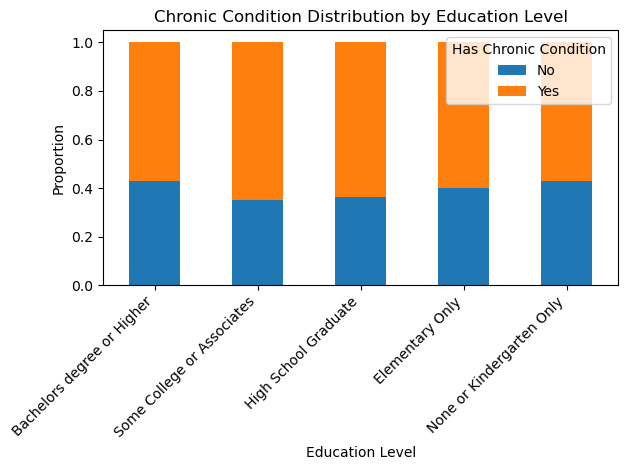

In [30]:
#######USED IN EDA#####

edu_chronic = df.groupby('EDUCA')['ALL_CHRONIC'].value_counts(normalize=True).unstack().fillna(0)
ordered_levels = ["Bachelors degree or Higher","Some College or Associates", "High School Graduate", "Elementary Only", "None or Kindergarten Only"]
edu_chronic = edu_chronic.loc[ordered_levels]

edu_chronic.plot(kind='bar', stacked=True)
plt.title('Chronic Condition Distribution by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Proportion')
plt.legend(title='Has Chronic Condition')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
filename ="educationvschronic.jpg"
filename = os.path.join("images",filename)

plt.savefig(filename, format='jpg', dpi=300,bbox_inches='tight')
plt.show()

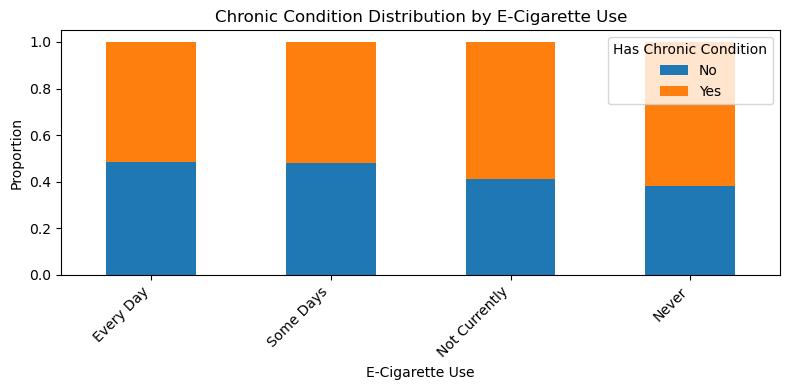

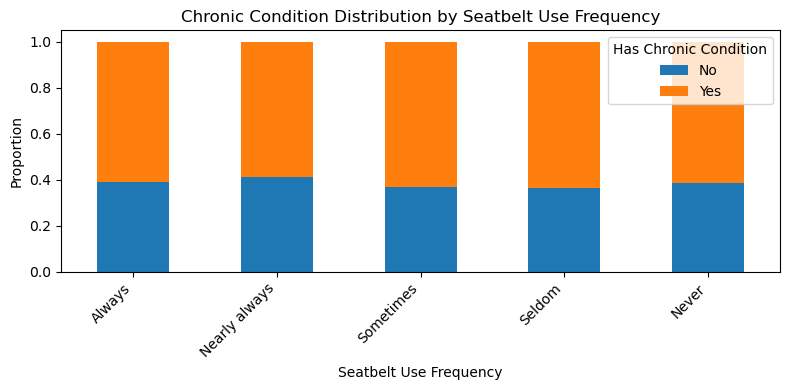

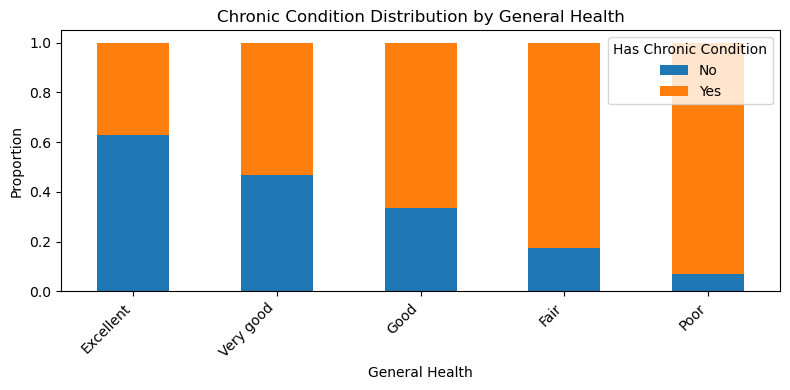

In [31]:
##### USED IN EDA#####

features = ['ECIGNOW2', 'SEATBELT', 'GENHLTH']

# Friendly labels for x-axis
x_labels = {
    'ECIGNOW2': 'E-Cigarette Use',
    'SEATBELT': 'Seatbelt Use Frequency',
    'GENHLTH': 'General Health'
}

#Fix the order of the labels
category_orders = {
    'ECIGNOW2': ['Every Day', 'Some Days', 'Not Currently', 'Never'],  
    'SEATBELT': ['Always', 'Nearly always', 'Sometimes', 'Seldom', 'Never'],
    'GENHLTH': ['Excellent', 'Very good', 'Good', 'Fair', 'Poor']
}

for col in features:

    ctab = pd.crosstab(df[col], df['ALL_CHRONIC'], normalize='index').fillna(0)
    if col in category_orders:
        ctab = ctab.reindex(category_orders[col])
    ax = ctab.plot(kind='bar', stacked=True, figsize=(8, 4))
    plt.title(f'Chronic Condition Distribution by {x_labels[col]}')
    plt.xlabel(x_labels[col])
    plt.ylabel('Proportion')
    plt.legend(title='Has Chronic Condition')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    filename = f"chronic_vs_{col}.jpg".replace(" ", "_").lower()
    filename = os.path.join("images",filename)

    plt.savefig(filename, format='jpg', dpi=300, bbox_inches='tight')
    plt.show()


In [32]:
####Check to see if the filtered data was saved

from pathlib import Path

file_path = Path("rq3_filtered.parquet")
if file_path.exists():
    print("File exists.")
else:
    print("File not found.")
    df.to_parquet(
        "rq3_filtered.parquet",
        engine="pyarrow",
        compression="BROTLI",
        compression_level=11,
        index=False
    )

File exists.


In [33]:
tpath = Path("df_train.parquet")
vpath = Path("df_val.parquet")
spath = Path("df_test.parquet")
if tpath.exists() and vpath.exists() and spath.exists():
    print("Split data found, loading files")
    df_train = pd.read_parquet(tpath)
    df_val = pd.read_parquet(vpath)
    df_test = pd.read_parquet(spath)
else:
    df_clustered = df.copy()
    df_testval, df_train = train_test_split(
        df, test_size=0.70, random_state=42, stratify=df["ALL_CHRONIC2"]
    )


    df_test, df_val = train_test_split(
        df_testval, test_size=0.50, random_state=42, stratify=df_testval["ALL_CHRONIC2"]
    )
    j_process.p_save(df_train,"df_train.parquet")
    j_process.p_save(df_val,"df_val.parquet")
    j_process.p_save(df_test,"df_test.parquet")

print(f"Train shape: {df_train.shape}")
print(f"Validation shape: {df_val.shape}")
print(f"Test shape: {df_test.shape}")


Split data found, loading files
Train shape: (204942, 31)
Validation shape: (43916, 31)
Test shape: (43915, 31)


Testing for optimal Kmode Clusters

In [35]:
#### Check to see if KMODE clustering cost results are available
#### Will take a long time to rerun, download "rq3_all_kresults.parquet" to skip

file_path = Path("rq3_all_kresults.parquet")
if file_path.exists():
    print("File exists.")
    all_kresults = pd.read_parquet(file_path)
    print(all_kresults.head())
    
else:
    print("Save not found, running tuner...May take a while...")
    all_kresults = j_clustertuner.kmode_tune(df_val,feature_list,n_cluster=256,n_trials=10,cores=15)
    j_process.save_if_changed(all_kresults,"rq3_all_kresults.parquet")




File exists.
   Clusters  AvgTrainCost                                      AllTrainCosts
0         2      159906.2  [158723.0, 160615.0, 160052.0, 162234.0, 16106...
1         3      149284.4  [149329.0, 149382.0, 151356.0, 149804.0, 14908...
2         4      141208.5  [143146.0, 143305.0, 138277.0, 139308.0, 14204...
3         5      136674.0  [137858.0, 139304.0, 133638.0, 136664.0, 13655...
4         6      131521.5  [131306.0, 132770.0, 131116.0, 132818.0, 13190...


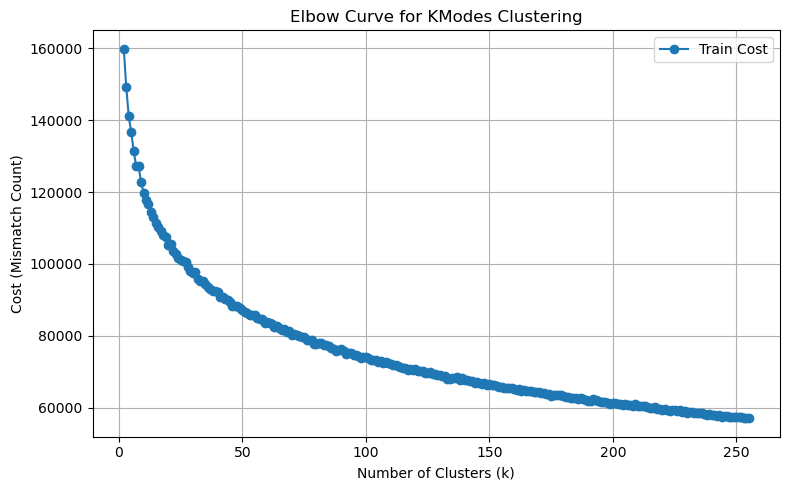

In [36]:
j_clustertuner.plot_kmode_elbow(all_kresults)

Test for Optimal TFlow number of clusters

In [38]:
#####Check to see if silhouette score data is available. 
#####Will take a long time ot rerun, make sure "rq3_all_tresults.parquet" is present

file_path = Path("rq3_all_tresults.parquet")
if file_path.exists():
    print("File exists.Loading file.")
    all_tresults = pd.read_parquet(file_path)
    print(all_tresults.head())

else:
    print("Save not found, running tuner...May take a while...")
    

    all_tresults = j_clustertuner.tflow_tune(df_test,df_val,feature_list)
    j_process.save_if_changed(all_tresults,"rq3_all_tresults.parquet")

File exists.Loading file.
   Clusters  AvgSilhouette                                     AllSilhouettes
0         2       0.069808  [0.065225644048053, 0.08763113072242525, 0.068...
1         3       0.051117  [0.05751124339856475, 0.07010575176413908, 0.0...
2         4       0.030767  [0.045338951034460125, 0.04342952875059009, 0....
3         5       0.032868  [0.027964292815975882, 0.04538036140505297, 0....
4         6       0.026881  [0.021615201219021142, 0.02470274290448259, 0....


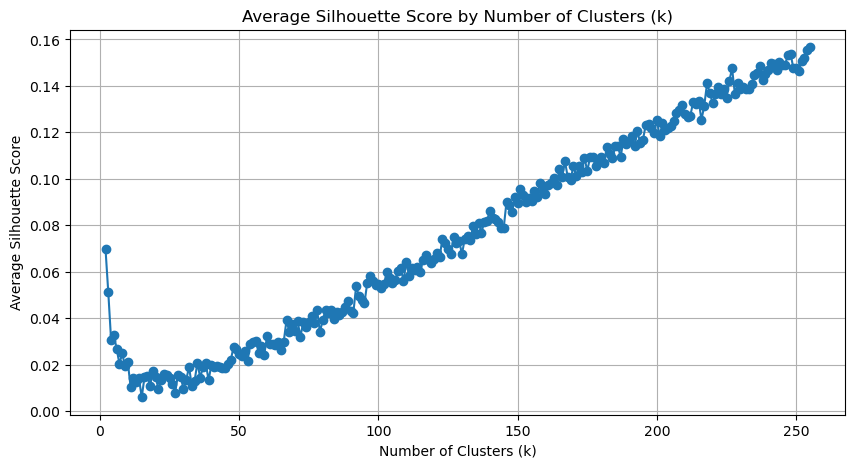

Best k: 255 with silhouette score = 0.1566
Top 5 k values:
  k = 255, score = 0.1566
  k = 254, score = 0.1556
  k = 248, score = 0.1539
  k = 247, score = 0.1533
  k = 253, score = 0.1520


(255,
 0.15664391195612337,
 [(255, 0.15664391195612337),
  (254, 0.1556394157656197),
  (248, 0.15386133013000958),
  (247, 0.15334477019832726),
  (253, 0.15196062417809375)])

In [39]:

j_clustertuner.analyze_silhouette_scores(all_tresults)

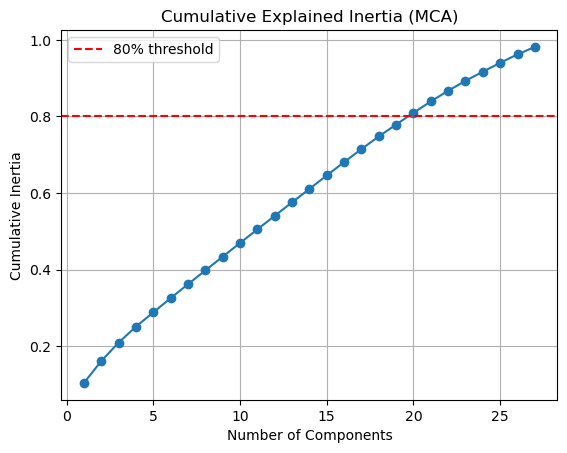

Components to reach 80% inertia: 20
Max intertia at: 26


In [40]:


# Ensure both are lists, then combine
bool_feat = list(bool_feat)
cat_feat = list(cat_feat)
combined_feat = bool_feat + cat_feat

# Drop the combined features from df
#mca_set = df_train.drop(columns=combined_feat, inplace=False)
#mca_valset = df_val.drop(columns=combined_feat,inplace=False)
mca_set = df_train.copy()
mca_set = mca_set[combined_feat]



mca = prince.MCA( n_components=27,random_state=42)
mca = mca.fit(mca_set)

X_reduced = mca.transform(mca_set)
X_reduced.shape

#explained = mca.explained_inertia_
eigen = mca.eigenvalues_
total = mca.total_inertia_
explained = eigen / total
#print(explained)


cumulative = np.cumsum(explained)

plt.plot(range(1, len(cumulative)+1), cumulative, marker='o')
plt.axhline(y=0.8, color='r', linestyle='--', label='80% threshold')
plt.title("Cumulative Explained Inertia (MCA)")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Inertia")
plt.grid(True)
plt.legend()
plt.savefig("mca_inertia.jpg", format='jpg', dpi=300)
plt.show()

# Find minimum number of components to reach 80%

k = np.argmax(cumulative >= 0.80) + 1
print(f"Components to reach 80% inertia: {k}")
k=np.argmax(cumulative>=.95) +1
print(f"Max intertia at: {k}")


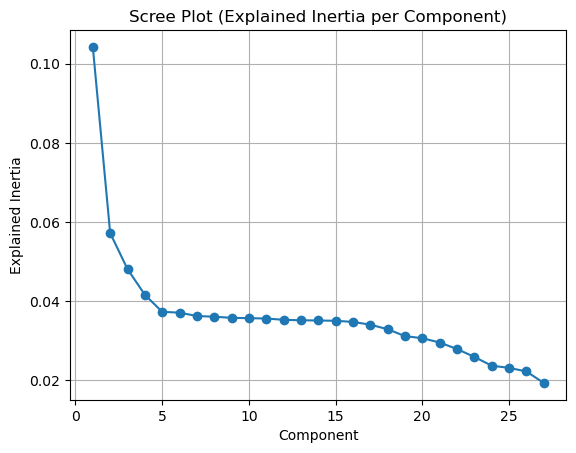

In [41]:
plt.plot(range(1, len(explained)+1), explained, marker='o')
plt.title("Scree Plot (Explained Inertia per Component)")
plt.xlabel("Component")
plt.ylabel("Explained Inertia")
plt.grid(True)
plt.savefig("screeplot_mca.jpg", format='jpg', dpi=300)
plt.show()

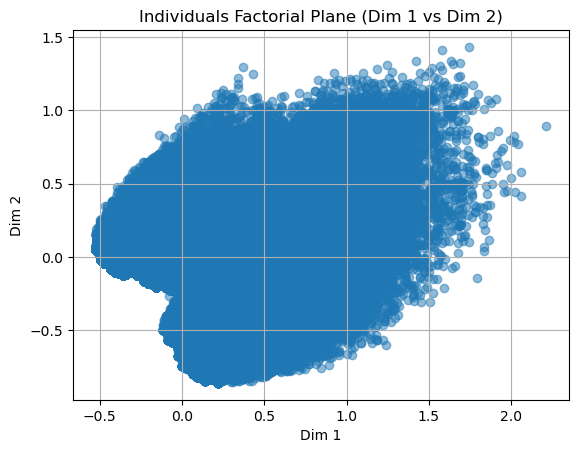

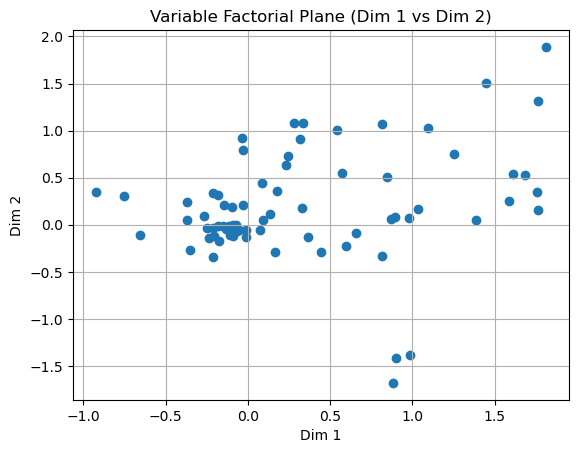

In [42]:
mca = prince.MCA(n_components=2, random_state=42)
mca = mca.fit(df_train)

if skip == True:
    print("skipping")
else:
    mca_row_coords = mca.row_coordinates(df_train)
    plt.scatter(mca_row_coords[0], mca_row_coords[1], alpha=0.5)
    plt.title("Individuals Factorial Plane (Dim 1 vs Dim 2)")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.grid(True)
    plt.show()
    
    # For variables
    mca_col_coords = mca.column_coordinates(df_train)
    plt.scatter(mca_col_coords[0], mca_col_coords[1])
    plt.title("Variable Factorial Plane (Dim 1 vs Dim 2)")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.grid(True)
    plt.show()
    
    cos2 = (mca_col_coords ** 2).div((mca_col_coords ** 2).sum(axis=1), axis=0)
    cos2.head()

In [43]:
####Todo: save ram and clean this up

###create model datasets
df_val = pd.concat([df_val,df_test],axis=0)
####Raw set
df_rawtrain = df_train.copy()
df_rawval = df_val.copy()


###Kmodes
km_train = df_train.copy()
km_val = df_val.copy()


###tflow 
tf_train=df_train.copy()
tf_val=df_val.copy()


###tflow 
rf_train=df_train.copy()
rf_val=df_val.copy()


###Cluster
mc_train=df_train.copy()
mc_val=df_val.copy()


## Baseline and Feature Importance Results


In [45]:
from joblib import Parallel, delayed

# Your targets
target_labels = ["ALL_CHRONIC", "ALL_CARDIAC", "ALL_PUL", "ALL_CHRONIC2"]

# Run all models in parallel
baseline_scores = Parallel(n_jobs=4)(
    delayed(j_process.run_logistic_model)(
        df_rawtrain,
        df_rawval,
        feature_list,
        target,
        plot_importance=True,
        importance_filename=f"{target.lower()}_importance.jpg"
    )
    for target in target_labels
)


all_chronic_scores, all_cardiac_scores, all_pul_scores, all_chronic2_scores = baseline_scores
print(baseline_scores)

[{'accuracy': 0.7041705092734911, 'precision': 0.8109054190508246, 'recall': 0.673036093418259, 'f1_score': 0.7355662076756327}, {'accuracy': 0.7106830162471109, 'precision': 0.24424695029229884, 'recall': 0.7035234572707806, 'f1_score': 0.3626056638322422}, {'accuracy': 0.6622604775079414, 'precision': 0.3103029567117965, 'recall': 0.5954794360946056, 'f1_score': 0.4079987227588409}, {'accuracy': 0.6895173685828466, 'precision': 0.6816710081067264, 'recall': 0.6636094323972035, 'f1_score': 0.6725189739648382}]


### Logistic Scores

In [47]:
def summarize_model_results(name, score_dict):
    return {
        'Model': name,
        'Accuracy': score_dict.get('accuracy'),
        'Precision': score_dict.get('precision'),
        'Recall': score_dict.get('recall'),
        'F1 Score': score_dict.get('f1_score')
    }

summary_df = pd.DataFrame([
    summarize_model_results('ALL_CHRONIC', all_chronic_scores),
    summarize_model_results('ALL_CARDIAC', all_cardiac_scores),
    summarize_model_results('ALL_PUL', all_pul_scores),
    summarize_model_results('ALL_CHRONIC2', all_chronic2_scores)
])


print(summary_df)


          Model  Accuracy  Precision    Recall  F1 Score
0   ALL_CHRONIC  0.704171   0.810905  0.673036  0.735566
1   ALL_CARDIAC  0.710683   0.244247  0.703523  0.362606
2       ALL_PUL  0.662260   0.310303  0.595479  0.407999
3  ALL_CHRONIC2  0.689517   0.681671  0.663609  0.672519


In [48]:
all_chronic_results_dict={}
all_cardiac_results_dict={}
all_pul_results_dict={}
all_chronic2_results_dict={}
for feature in feature_list:
    #print(f"\n---Running baseline on feature:{feature}---")
    results = j_process.run_logistic_model(df_rawtrain,df_rawval,[feature],"ALL_CHRONIC")
    all_chronic_results_dict[feature]=results

for feature in feature_list:
    #print(f"\n---Running baseline on feature:{feature}---")
    results = j_process.run_logistic_model(df_rawtrain,df_rawval,[feature],"ALL_CARDIAC")
    all_cardiac_results_dict[feature]=results

for feature in feature_list:
    #print(f"\n---Running baseline on feature:{feature}---")
    results = j_process.run_logistic_model(df_rawtrain,df_rawval,[feature],"ALL_PUL")
    all_pul_results_dict[feature]=results
for feature in feature_list:
    #print(f"\n---Running baseline on feature:{feature}---")
    results = j_process.run_logistic_model(df_rawtrain,df_rawval,[feature],"ALL_CHRONIC2")
    all_chronic2_results_dict[feature]=results

Running logistic regression for target: ALL_CHRONIC2:
Validation Scores for ALL_CHRONIC2 -> Accuracy: 0.6060, Precision: 0.6020, Recall: 0.5306, F1: 0.5641


Indivdual feature baseline results for ALL_CHRONIC


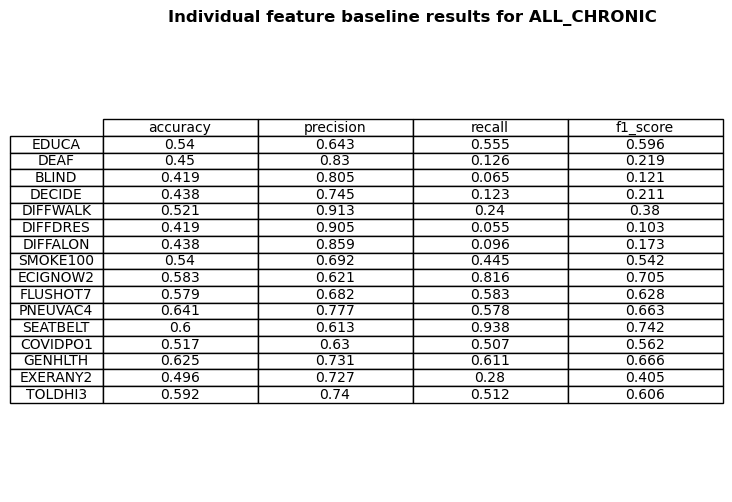

In [49]:
print("Indivdual feature baseline results for ALL_CHRONIC")
df_results = pd.DataFrame.from_dict(all_chronic_results_dict, orient='index')
df_results = df_results.round(3)  # Round to 3 decimal places
df_results = df_results[['accuracy', 'precision', 'recall', 'f1_score']] 
fig, ax = plt.subplots(figsize=(8, 6))
ax.axis('off')
ax.set_title("Individual feature baseline results for ALL_CHRONIC", fontsize=12, fontweight='bold')

# Draw the table
table = ax.table(
    cellText=df_results.values,
    colLabels=df_results.columns,
    rowLabels=df_results.index,
    cellLoc='center',
    loc='center',
    colLoc='center',
    rowLoc='center'
)

table.auto_set_font_size(True)
table.set_fontsize(10)
table.scale(1, 1)  
# Save as JPEG
plt.savefig("all_chronic_baseline_table.jpg", bbox_inches='tight', dpi=150)
plt.show()

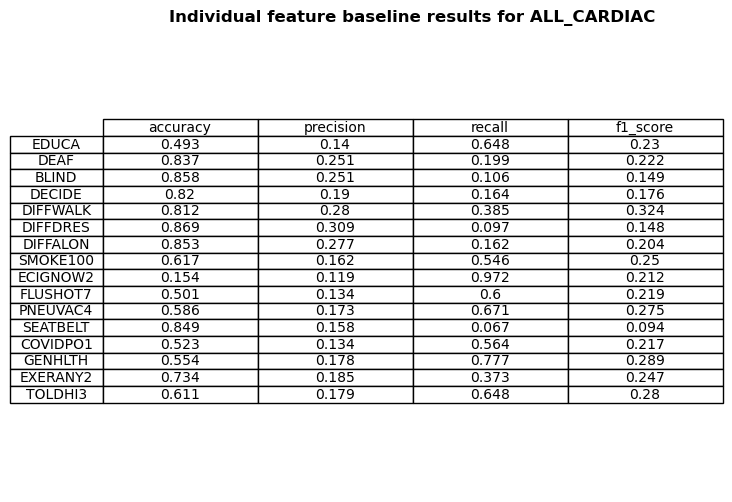

In [50]:

df_results = pd.DataFrame.from_dict(all_cardiac_results_dict, orient='index')
df_results = df_results.round(3)  # Round to 3 decimal places
df_results = df_results[['accuracy', 'precision', 'recall', 'f1_score']] 
fig, ax = plt.subplots(figsize=(8, 6))
ax.axis('off')
ax.set_title("Individual feature baseline results for ALL_CARDIAC", fontsize=12, fontweight='bold')

# Draw the table
table = ax.table(
    cellText=df_results.values,
    colLabels=df_results.columns,
    rowLabels=df_results.index,
    cellLoc='center',
    loc='center',
    colLoc='center',
    rowLoc='center'
)

table.auto_set_font_size(True)
table.set_fontsize(10)
table.scale(1, 1)  
# Save as JPEG
plt.savefig("all_cardiac_baseline_table.jpg", bbox_inches='tight', dpi=150)
plt.show()

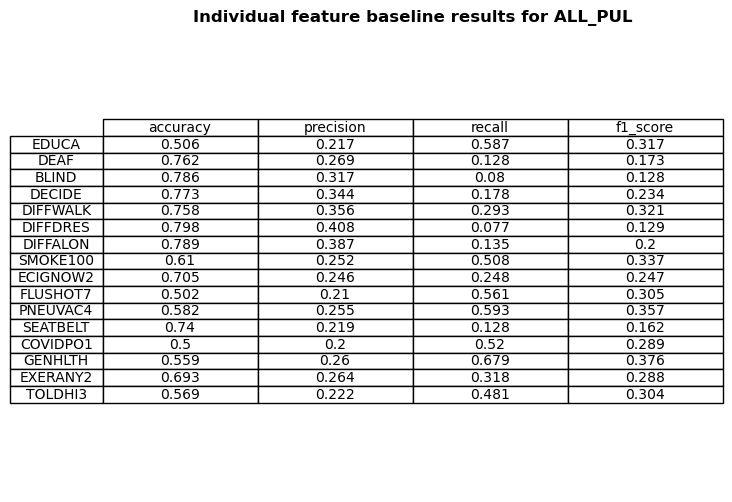

In [51]:

df_results = pd.DataFrame.from_dict(all_pul_results_dict, orient='index')
df_results = df_results.round(3)  # Round to 3 decimal places
df_results = df_results[['accuracy', 'precision', 'recall', 'f1_score']] 
fig, ax = plt.subplots(figsize=(8, 6))
ax.axis('off')
ax.set_title("Individual feature baseline results for ALL_PUL", fontsize=12, fontweight='bold')

# Draw the table
table = ax.table(
    cellText=df_results.values,
    colLabels=df_results.columns,
    rowLabels=df_results.index,
    cellLoc='center',
    loc='center',
    colLoc='center',
    rowLoc='center'
)

table.auto_set_font_size(True)
table.set_fontsize(10)
table.scale(1, 1)  
# Save as JPEG
plt.savefig("all_pul_baseline_table.jpg", bbox_inches='tight', dpi=150)
plt.show()

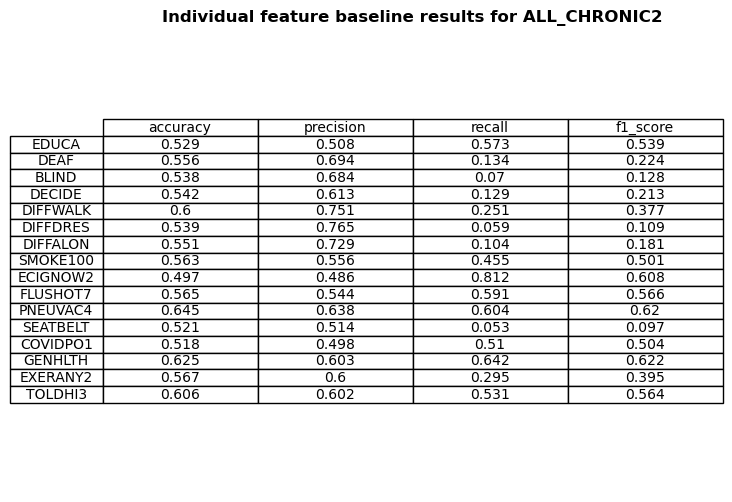

In [52]:

df_results = pd.DataFrame.from_dict(all_chronic2_results_dict, orient='index')
df_results = df_results.round(3)  # Round to 3 decimal places
df_results = df_results[['accuracy', 'precision', 'recall', 'f1_score']] 
fig, ax = plt.subplots(figsize=(8, 6))
ax.axis('off')
ax.set_title("Individual feature baseline results for ALL_CHRONIC2", fontsize=12, fontweight='bold')

# Draw the table
table = ax.table(
    cellText=df_results.values,
    colLabels=df_results.columns,
    rowLabels=df_results.index,
    cellLoc='center',
    loc='center',
    colLoc='center',
    rowLoc='center'
)

table.auto_set_font_size(True)
table.set_fontsize(10)
table.scale(1, 1)  
# Save as JPEG
plt.savefig("all_chronic2_baseline_table.jpg", bbox_inches='tight', dpi=150)
plt.show()

In [53]:
###RANDOM FOREST BASELINE

# Run Random Forest on all features at once
rf_all_chronic_scores = j_process.run_rf_model(rf_train, rf_val, feature_list, "ALL_CHRONIC")
rf_all_cardiac_scores = j_process.run_rf_model(rf_train, rf_val, feature_list, "ALL_CARDIAC")
rf_all_pul_scores = j_process.run_rf_model(rf_train, rf_val, feature_list, "ALL_PUL")
rf_chronic2_scores = j_process.run_rf_model(rf_train,rf_val,feature_list,"ALL_CHRONIC2")

rfsummary_df = pd.DataFrame([
    summarize_model_results('ALL_CHRONIC', rf_all_chronic_scores),
    summarize_model_results('ALL_CARDIAC', rf_all_cardiac_scores),
    summarize_model_results('ALL_PUL', rf_all_pul_scores),
    summarize_model_results('ALL_CHRONIC2', rf_chronic2_scores)
])


print(rfsummary_df)

Target mapped as: {'No': 0, 'Yes': 1}
RF Validation Scores -> Accuracy: 0.6990, Precision: 0.7957, Recall: 0.6830, F1: 0.7351
Target mapped as: {'No': 0, 'Yes': 1}
RF Validation Scores -> Accuracy: 0.7642, Precision: 0.2275, Recall: 0.4241, F1: 0.2962
Target mapped as: {'No': 0, 'Yes': 1}
RF Validation Scores -> Accuracy: 0.7051, Precision: 0.2965, Recall: 0.3708, F1: 0.3295
Target mapped as: {'No': 0, 'Yes': 1}
RF Validation Scores -> Accuracy: 0.6732, Precision: 0.6648, Recall: 0.6450, F1: 0.6547
          Model  Accuracy  Precision    Recall  F1 Score
0   ALL_CHRONIC  0.699024   0.795721  0.683019  0.735075
1   ALL_CARDIAC  0.764229   0.227543  0.424080  0.296173
2       ALL_PUL  0.705104   0.296529  0.370791  0.329528
3  ALL_CHRONIC2  0.673179   0.664761  0.644958  0.654710


In [54]:
#### Skipped this section, this is redundant

if skip == True:
    print("skipping redundant tests")
else:
    
    


    rf_all_chronic_results_dict = {}
    rf_all_cardiac_results_dict = {}
    rf_all_pul_results_dict = {}
    rf_all_chronic2_results_dict={}
    
    
    
    
    rf_result_dicts = {
        "ALL_CHRONIC": rf_all_chronic_results_dict,
        "ALL_CARDIAC": rf_all_cardiac_results_dict,
        "ALL_PUL": rf_all_pul_results_dict,
        "ALL_CHRONIC2": rf_all_chronic2_results_dict
    }
    
    for label in target_labels:
        for feature in feature_list:
            clear_output(wait=True)
            print(f"\n---Running RF baseline on feature: {feature} [{label}] ---")
            results = j_process.run_rf_model(rf_train, rf_val, [feature], label)
            rf_result_dicts[label][feature] = results
        


---Running RF baseline on feature: TOLDHI3 [ALL_CHRONIC2] ---
Target mapped as: {'No': 0, 'Yes': 1}
RF Validation Scores -> Accuracy: 0.6060, Precision: 0.6020, Recall: 0.5306, F1: 0.5641


In [55]:
#####TENSOR FLOW BASELINE

tf_all_chronic_scores = j_process.run_tf_model(tf_train, tf_val, feature_list, "ALL_CHRONIC",verbose=1)
tf_all_cardiac_scores = j_process.run_tf_model(tf_train, tf_val, feature_list, "ALL_CARDIAC")
tf_all_pul_scores = j_process.run_tf_model(tf_train, tf_val, feature_list, "ALL_PUL")
tf_chronic2_scores = j_process.run_tf_model(tf_train,tf_val,feature_list,"ALL_CHRONIC2")
tfsummary_df = pd.DataFrame([
    summarize_model_results('ALL_CHRONIC', tf_all_chronic_scores),
    summarize_model_results('ALL_CARDIAC', tf_all_cardiac_scores),
    summarize_model_results('ALL_PUL', tf_all_pul_scores),
    summarize_model_results('ALL_CHRONIC2', tf_chronic2_scores)
])


print(tfsummary_df)

Epoch 1/30
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6861 - loss: 0.5822 - precision: 0.7974 - recall: 0.6461 - val_accuracy: 0.7089 - val_loss: 0.5604 - val_precision: 0.8096 - val_recall: 0.6849
Epoch 2/30
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 1s 915us/step - accuracy: 0.7067 - loss: 0.5613 - precision: 0.8120 - recall: 0.6746 - val_accuracy: 0.7013 - val_loss: 0.5613 - val_precision: 0.8196 - val_recall: 0.6557
Epoch 3/30
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 2s 947us/step - accuracy: 0.7071 - loss: 0.5584 - precision: 0.8144 - recall: 0.6725 - val_accuracy: 0.6971 - val_loss: 0.5649 - val_precision: 0.8248 - val_recall: 0.6407
Epoch 4/30
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 1s 919us/step - accuracy: 0.7080 - loss: 0.5592 - precision: 0.8141 - recall: 0.6734 - val_accuracy: 0.7055 - val_loss: 0.5625 - val_precision: 0.8153 - val_recall: 0.6701
2745/2745 ━━━━━━━━━━━━━━━━━━━━ 1s 270us/step 
TF Model Scores -> Accuracy: 0.7089, Precision: 0.8096, Recall: 0.6849, F1: 0.7420
2745/2745 ━━━━━━━

In [56]:
######Redundant section, skipped 


if skip == True:
    print("skipping redundant tests")
else:

    ####Tensor flow output
    # Prepare per-feature result dicts
    tf_all_chronic_results_dict = {}
    tf_all_cardiac_results_dict = {}
    tf_all_pul_results_dict = {}
    tf_all_chronic2_results_dict={}
    # Individual feature runs for ALL_CHRONIC
    for feature in feature_list:
        print(f"\n---Running baseline on feature: {feature} [ALL_CHRONIC] ---")
        results = j_process.run_tf_model(tf_train, tf_val, [feature], "ALL_CHRONIC")
        tf_all_chronic_results_dict[feature] = results
    
    # Individual feature runs for ALL_CARDIAC
    for feature in feature_list:
        print(f"\n---Running baseline on feature: {feature} [ALL_CARDIAC] ---")
        results = j_process.run_tf_model(tf_train, tf_val, [feature], "ALL_CARDIAC")
        tf_all_cardiac_results_dict[feature] = results
    
    # Individual feature runs for ALL_PUL
    for feature in feature_list:
        print(f"\n---Running baseline on feature: {feature} [ALL_PUL] ---")
        results = j_process.run_tf_model(tf_train, tf_val, [feature], "ALL_PUL")
        tf_all_pul_results_dict[feature] = results
    for feature in feature_list:
        print(f"\n---Running baseline on feature: {feature} [ALL_CHRONIC2] ---")
        results = j_process.run_tf_model(rf_train, rf_val, [feature], "ALL_CHRONIC2")
        rf_all_chronic2_results_dict[feature] = results


---Running baseline on feature: EDUCA [ALL_CHRONIC] ---
2745/2745 ━━━━━━━━━━━━━━━━━━━━ 1s 252us/step 
TF Model Scores -> Accuracy: 0.5397, Precision: 0.6434, Recall: 0.5542, F1: 0.5955

---Running baseline on feature: DEAF [ALL_CHRONIC] ---
2745/2745 ━━━━━━━━━━━━━━━━━━━━ 1s 266us/step 
TF Model Scores -> Accuracy: 0.4499, Precision: 0.8303, Recall: 0.1258, F1: 0.2185

---Running baseline on feature: BLIND [ALL_CHRONIC] ---
2745/2745 ━━━━━━━━━━━━━━━━━━━━ 1s 284us/step 
TF Model Scores -> Accuracy: 0.4189, Precision: 0.8051, Recall: 0.0652, F1: 0.1206

---Running baseline on feature: DECIDE [ALL_CHRONIC] ---
2745/2745 ━━━━━━━━━━━━━━━━━━━━ 1s 268us/step 
TF Model Scores -> Accuracy: 0.4380, Precision: 0.7446, Recall: 0.1229, F1: 0.2109

---Running baseline on feature: DIFFWALK [ALL_CHRONIC] ---
2745/2745 ━━━━━━━━━━━━━━━━━━━━ 1s 274us/step 
TF Model Scores -> Accuracy: 0.5213, Precision: 0.9129, Recall: 0.2399, F1: 0.3800

---Running baseline on feature: DIFFDRES [ALL_CHRONIC] ---
2745/27

I am actively writing code beyond this point

## Cluster with selected K's

### Kmodes

In [60]:

k_trials = [2,3,4, 5,6,7,8,9, 10,15,20, 25,35,40, 50, 100,200,500,1000]

# Create a single evolving copy of df_train and df_val
cluster_df_train = df_train.copy()
cluster_df_val = df_val.copy()

# List to store all new cluster column names
cluster_columns = []

if skip ==True:

    cluster_df_train=pd.read_parquet("cluster_df_train.parquet")
    cluster_df_val=pd.read_parquet("cluster_df_val.parquet")
    print("Data loaded...")
    print(cluster_df_train.head())
else:

# --- K-Modes ---
    for trial in k_trials:
        print(f"[K-Modes] {trial} clusters")
        print("Train Set")
        cluster_df_train, col_train, _ = j_process.run_kmodes_cluster(
            cluster_df_train, feature_cols=feature_list, n_clusters=trial
        )
        cluster_columns.append(col_train)
        print("Val_Set")
        cluster_df_val, col_val, _ = j_process.run_kmodes_cluster(
            cluster_df_val, feature_cols=feature_list, n_clusters=trial
        )




[K-Modes] 2 clusters
Train Set
Val_Set
[K-Modes] 3 clusters
Train Set
Val_Set
[K-Modes] 4 clusters
Train Set
Val_Set
[K-Modes] 5 clusters
Train Set
Val_Set
[K-Modes] 6 clusters
Train Set
Val_Set
[K-Modes] 7 clusters
Train Set
Val_Set
[K-Modes] 8 clusters
Train Set
Val_Set
[K-Modes] 9 clusters
Train Set
Val_Set
[K-Modes] 10 clusters
Train Set
Val_Set
[K-Modes] 15 clusters
Train Set
Val_Set
[K-Modes] 20 clusters
Train Set
Val_Set
[K-Modes] 25 clusters
Train Set
Val_Set
[K-Modes] 35 clusters
Train Set
Val_Set
[K-Modes] 40 clusters
Train Set
Val_Set
[K-Modes] 50 clusters
Train Set
Val_Set
[K-Modes] 100 clusters
Train Set
Val_Set
[K-Modes] 200 clusters
Train Set
Val_Set
[K-Modes] 500 clusters
Train Set
Val_Set
[K-Modes] 1000 clusters
Train Set
Val_Set


### Tensor

In [62]:
if skip == True:
    print("skipping...")
    
else:
    for trial in k_trials:
        print(f"[TF Clustering] {trial} clusters")
        print("Train Set")
        cluster_df_train, col_train = j_process.run_tf_clustering(
            cluster_df_train, feature_cols=feature_list, n_clusters=trial
        )
        cluster_columns.append(col_train)
        print("Val Set")
        cluster_df_val, _ = j_process.run_tf_clustering(
            cluster_df_val, feature_cols=feature_list, n_clusters=trial
        )


[TF Clustering] 2 clusters
Train Set
Val Set
[TF Clustering] 3 clusters
Train Set
Val Set
[TF Clustering] 4 clusters
Train Set
Val Set
[TF Clustering] 5 clusters
Train Set
Val Set
[TF Clustering] 6 clusters
Train Set
Val Set
[TF Clustering] 7 clusters
Train Set
Val Set
[TF Clustering] 8 clusters
Train Set
Val Set
[TF Clustering] 9 clusters
Train Set
Val Set
[TF Clustering] 10 clusters
Train Set
Val Set
[TF Clustering] 15 clusters
Train Set
Val Set
[TF Clustering] 20 clusters
Train Set
Val Set
[TF Clustering] 25 clusters
Train Set
Val Set
[TF Clustering] 35 clusters
Train Set
Val Set
[TF Clustering] 40 clusters
Train Set
Val Set
[TF Clustering] 50 clusters
Train Set
Val Set
[TF Clustering] 100 clusters
Train Set
Val Set
[TF Clustering] 200 clusters
Train Set
Val Set
[TF Clustering] 500 clusters
Train Set
Val Set
[TF Clustering] 1000 clusters
Train Set
Val Set


In [63]:
if skip==True:
    print("No need to save....")
else:
    j_process.p_save(cluster_df_val,"cluster_df_val.parquet")
    j_process.p_save(cluster_df_train,"cluster_df_train.parquet")

In [64]:
### Sanity check


for km in cluster_columns:
    print(km)
clustering_only=[]

#print(cluster_df_train)

kmode_n2_i5_h
kmode_n3_i5_h
kmode_n4_i5_h
kmode_n5_i5_h
kmode_n6_i5_h
kmode_n7_i5_h
kmode_n8_i5_h
kmode_n9_i5_h
kmode_n10_i5_h
kmode_n15_i5_h
kmode_n20_i5_h
kmode_n25_i5_h
kmode_n35_i5_h
kmode_n40_i5_h
kmode_n50_i5_h
kmode_n100_i5_h
kmode_n200_i5_h
kmode_n500_i5_h
kmode_n1000_i5_h
tf_n2_d8_e50
tf_n3_d8_e50
tf_n4_d8_e50
tf_n5_d8_e50
tf_n6_d8_e50
tf_n7_d8_e50
tf_n8_d8_e50
tf_n9_d8_e50
tf_n10_d8_e50
tf_n15_d8_e50
tf_n20_d8_e50
tf_n25_d8_e50
tf_n35_d8_e50
tf_n40_d8_e50
tf_n50_d8_e50
tf_n100_d8_e50
tf_n200_d8_e50
tf_n500_d8_e50
tf_n1000_d8_e50


In [65]:

for km in cluster_columns:
    for target in target_labels:
        print(km)
        results = j_process.run_logistic_model(cluster_df_train,cluster_df_val,feature_list+[km],target)
        print(km)
        clustering_only.append(results)
        results = j_process.run_tf_model(cluster_df_train,cluster_df_val,feature_list+[km],target,verbose=1)
        clustering_only.append(results)
        results = j_process.run_rf_model(cluster_df_train,cluster_df_val,feature_list+[km],target)
        clustering_only.append(results)

Running logistic regression for target: ALL_CHRONIC2:
Validation Scores for ALL_CHRONIC2 -> Accuracy: 0.6835, Precision: 0.6739, Recall: 0.6610, F1: 0.6674
tf_n1000_d8_e50
Epoch 1/30
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6806 - loss: 0.6023 - precision: 0.6711 - recall: 0.6713 - val_accuracy: 0.6855 - val_loss: 0.5929 - val_precision: 0.6671 - val_recall: 0.6894
Epoch 2/30
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6950 - loss: 0.5871 - precision: 0.6832 - recall: 0.6809 - val_accuracy: 0.6865 - val_loss: 0.5934 - val_precision: 0.6934 - val_recall: 0.6230
Epoch 3/30
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6938 - loss: 0.5884 - precision: 0.6876 - recall: 0.6648 - val_accuracy: 0.6852 - val_loss: 0.5940 - val_precision: 0.6715 - val_recall: 0.6748
Epoch 4/30
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6931 - loss: 0.5889 - precision: 0.6835 - recall: 0.6719 - val_accuracy: 0.6848 - val_loss: 0.5937 - val_precision: 0.6678 -

### Todo: are there distinct clusters??

In [67]:
print(cluster_df_train.head())
print(feature_list)

  CVDINFR4 CVDCRHD4 CVDSTRK3 ASTHMA3 CHCSCNC1 CHCOCNC1 CHCCOPD3 CHCKDNY2  \
0       No       No       No      No       No       No       No       No   
1      Yes       No       No      No       No      Yes       No       No   
2       No       No       No      No       No       No       No       No   
3       No       No       No      No      Yes       No       No       No   
4       No       No       No      No       No       No       No       No   

  HAVARTH4 DIABETE4                       EDUCA DEAF BLIND DECIDE DIFFWALK  \
0      Yes       No  Some College or Associates   No    No     No      Yes   
1       No      Yes            Some High School   No    No     No       No   
2       No       No  Bachelors degree or Higher   No    No     No       No   
3      Yes       No  Bachelors degree or Higher  Yes    No     No      Yes   
4       No       No  Bachelors degree or Higher   No    No     No       No   

  DIFFDRES DIFFALON SMOKE100 ECIGNOW2 FLUSHOT7 PNEUVAC4 SEATBELT COVIDPO1 

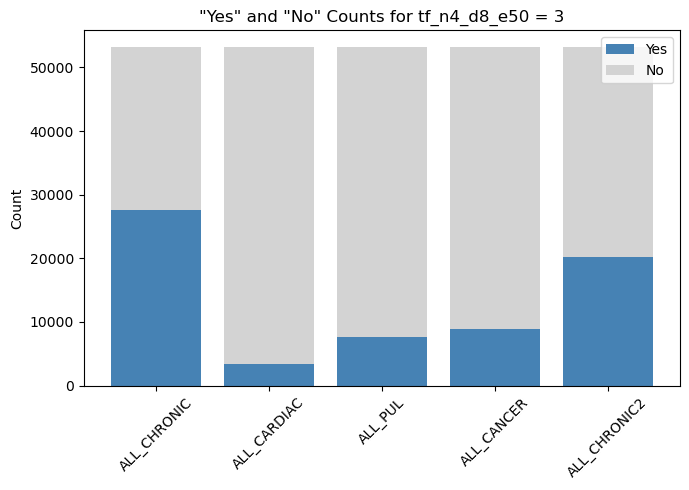

In [200]:
# Step 1: Choose cluster column and cluster value
cluster_col = 'tf_n4_d8_e50'
cluster_val = 3

# Step 2: Get target variable spread
target_cols = ['ALL_CHRONIC', 'ALL_CARDIAC', 'ALL_PUL', 'ALL_CANCER','ALL_CHRONIC2']
subset = cluster_df_train[cluster_df_train[cluster_col] == cluster_val]

# Step 3: Count 'Yes' and 'No' for each target
yes_counts = []
no_counts = []

for col in target_cols:
    vc = subset[col].value_counts()
    yes_counts.append(vc.get('Yes', 0))
    no_counts.append(vc.get('No', 0))

# Step 4: Plot stacked bar
x = target_cols
x_pos = range(len(x))

plt.figure(figsize=(7, 5))
plt.bar(x_pos, yes_counts, label='Yes', color='steelblue')
plt.bar(x_pos, no_counts, bottom=yes_counts, label='No', color='lightgray')

plt.xticks(x_pos, x, rotation=45)
plt.ylabel('Count')
plt.title(f'"Yes" and "No" Counts for {cluster_col} = {cluster_val}')
plt.legend()
plt.tight_layout()
plt.show()

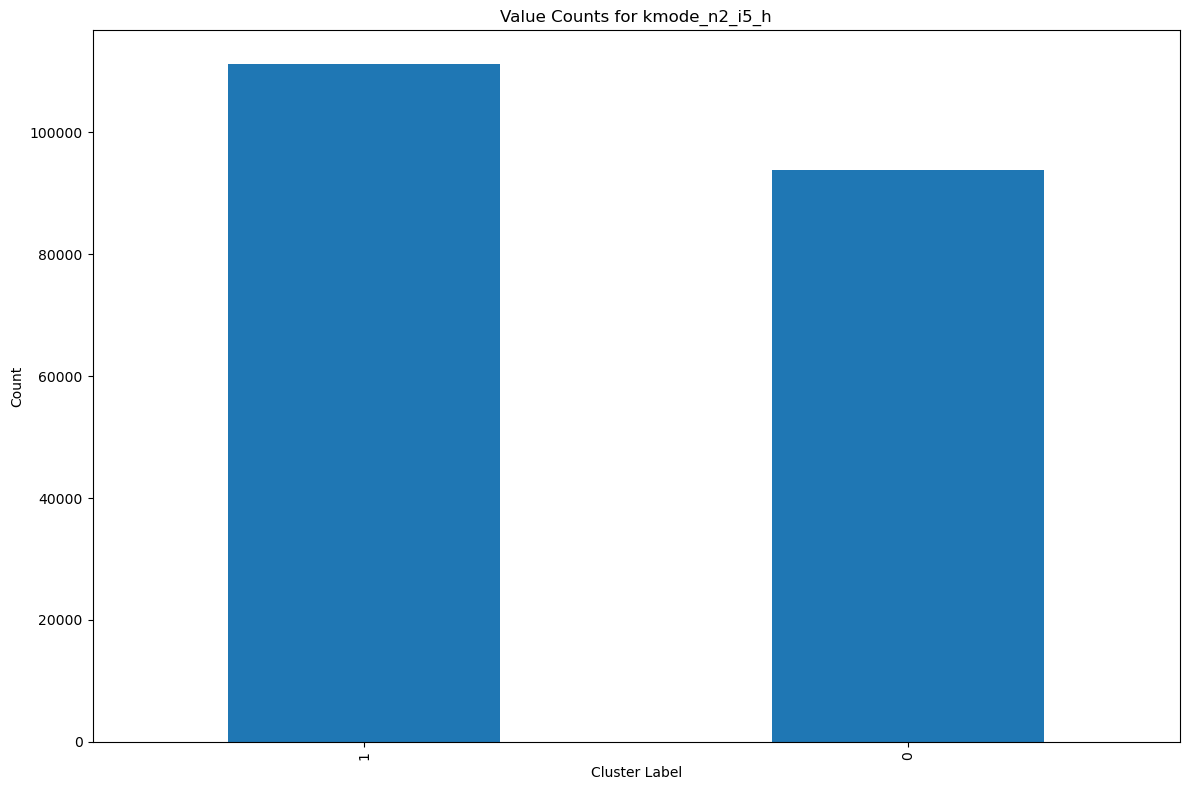

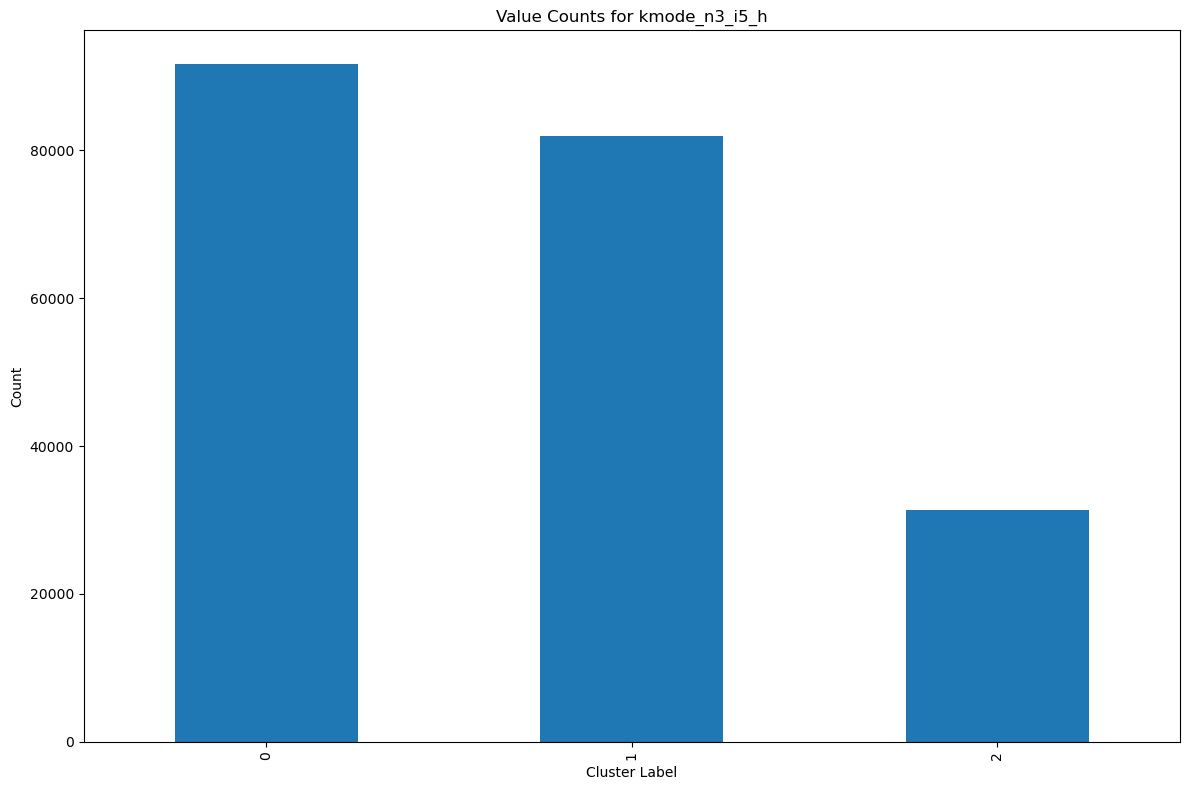

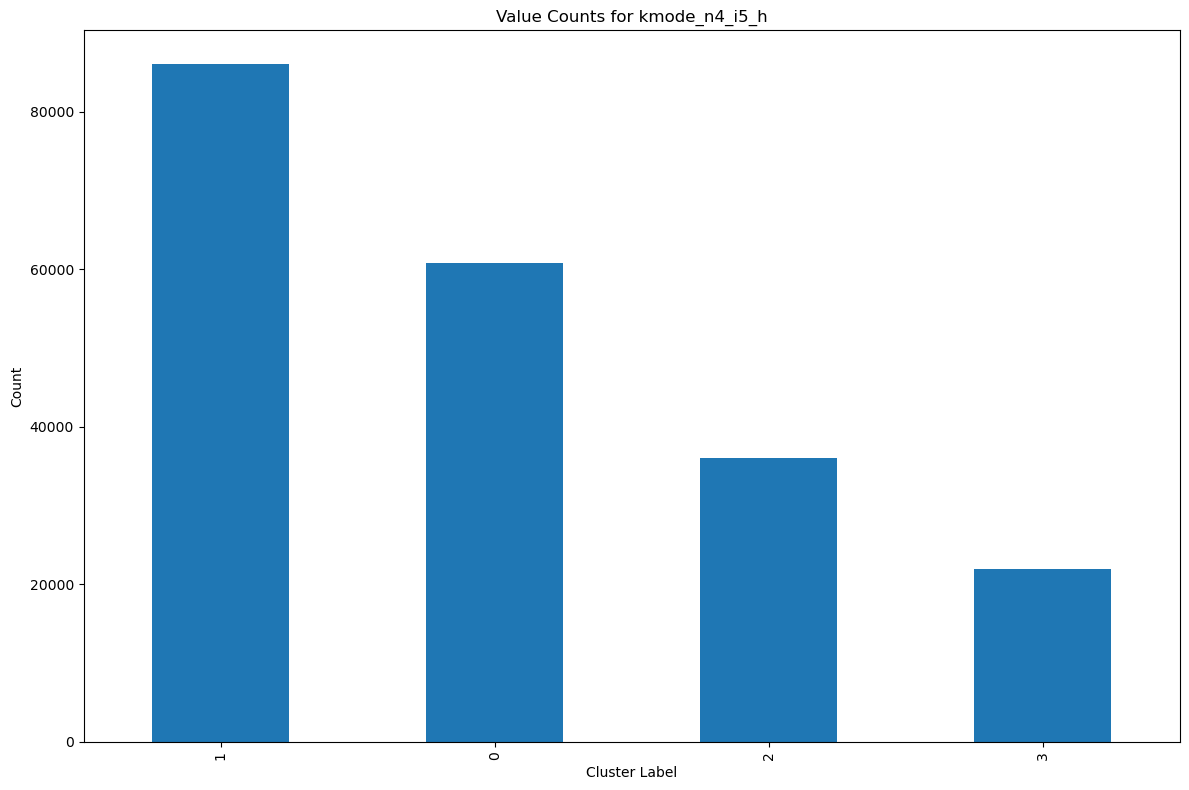

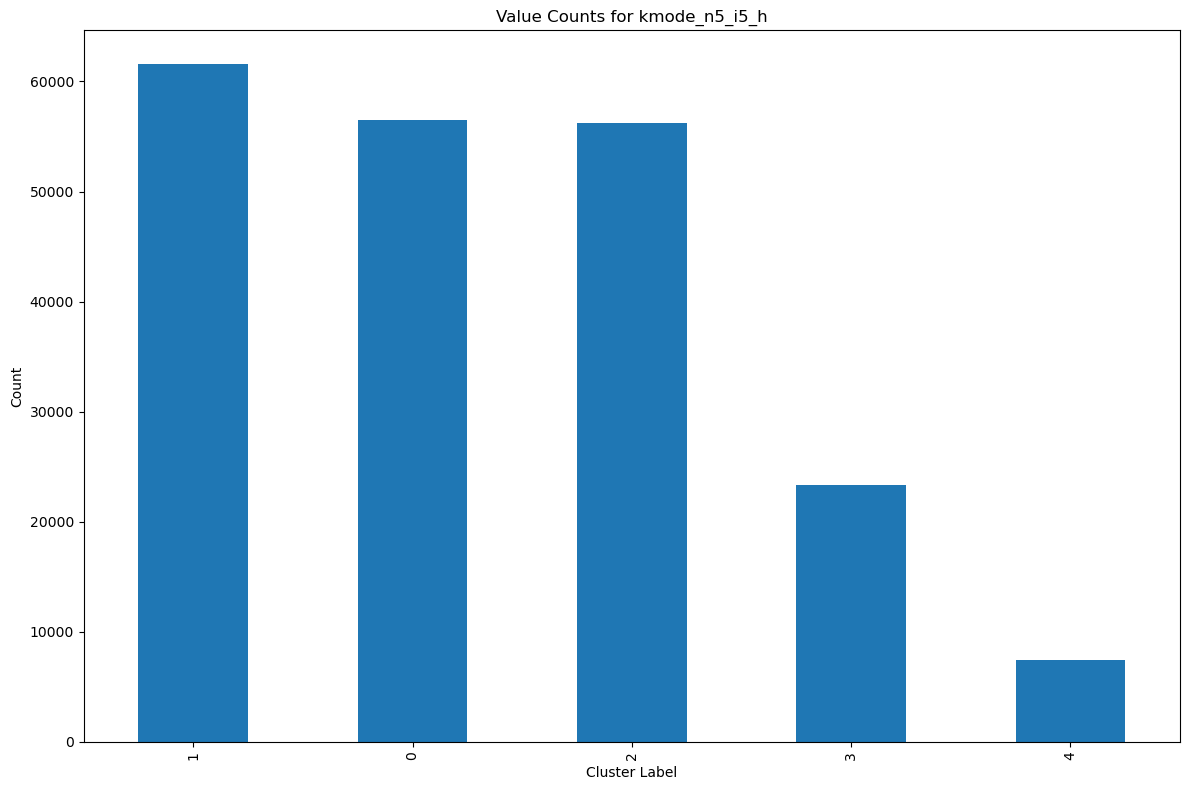

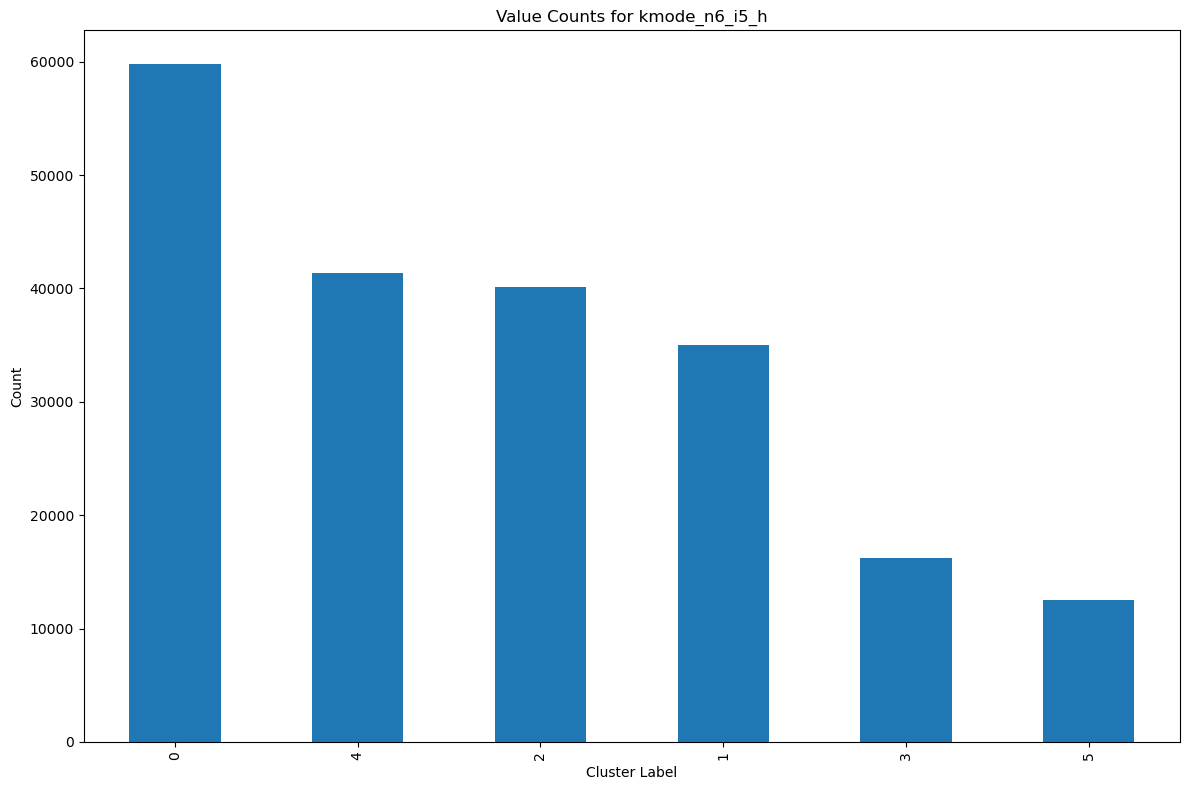

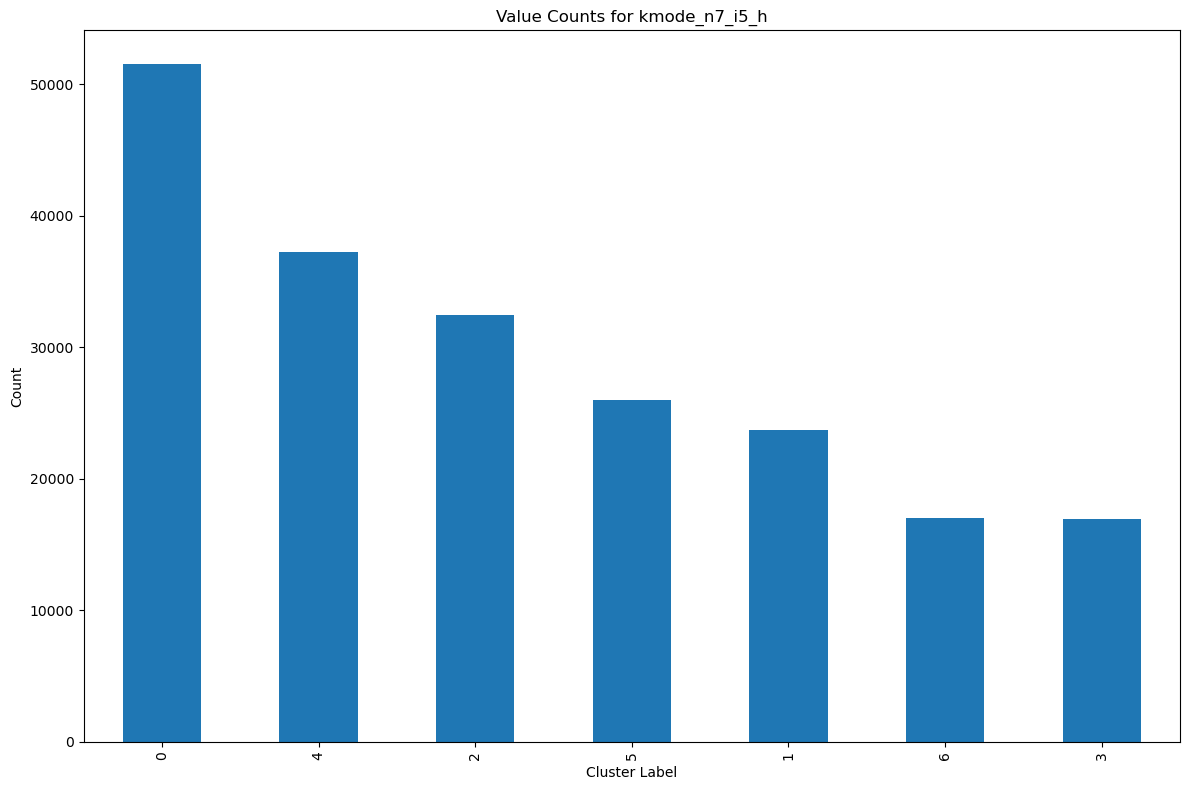

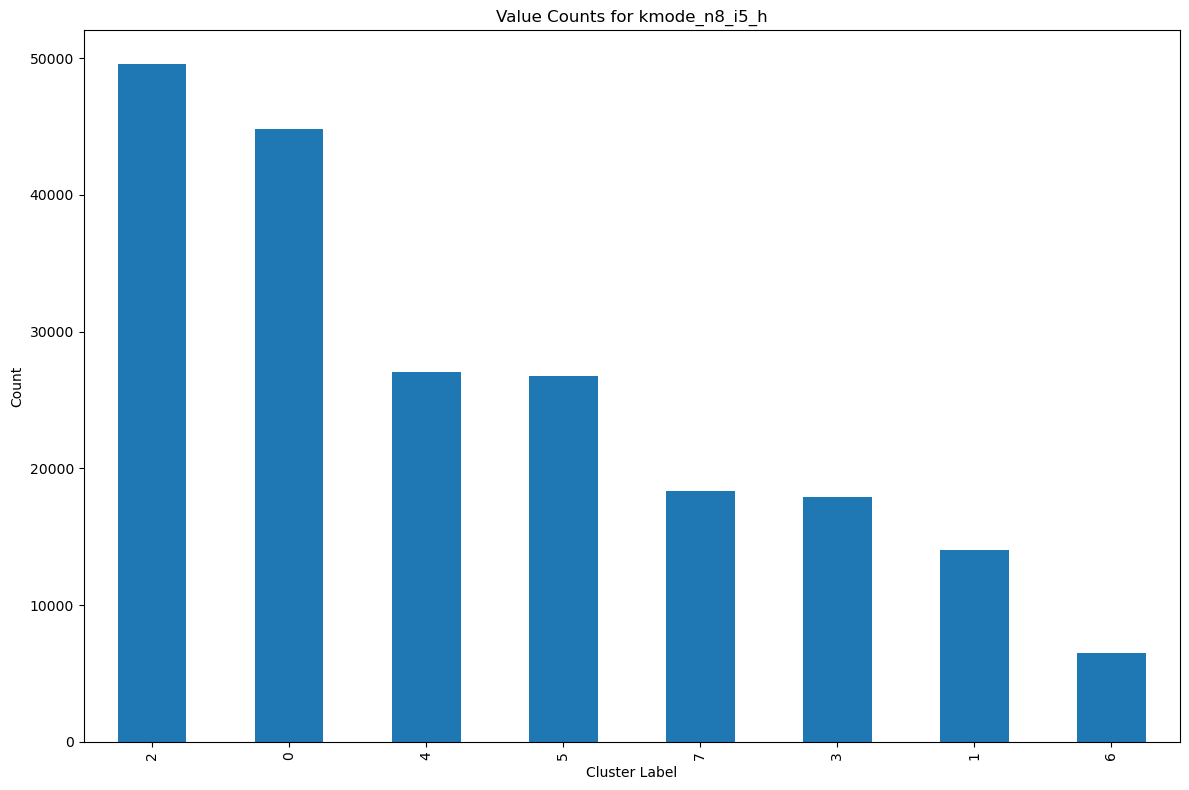

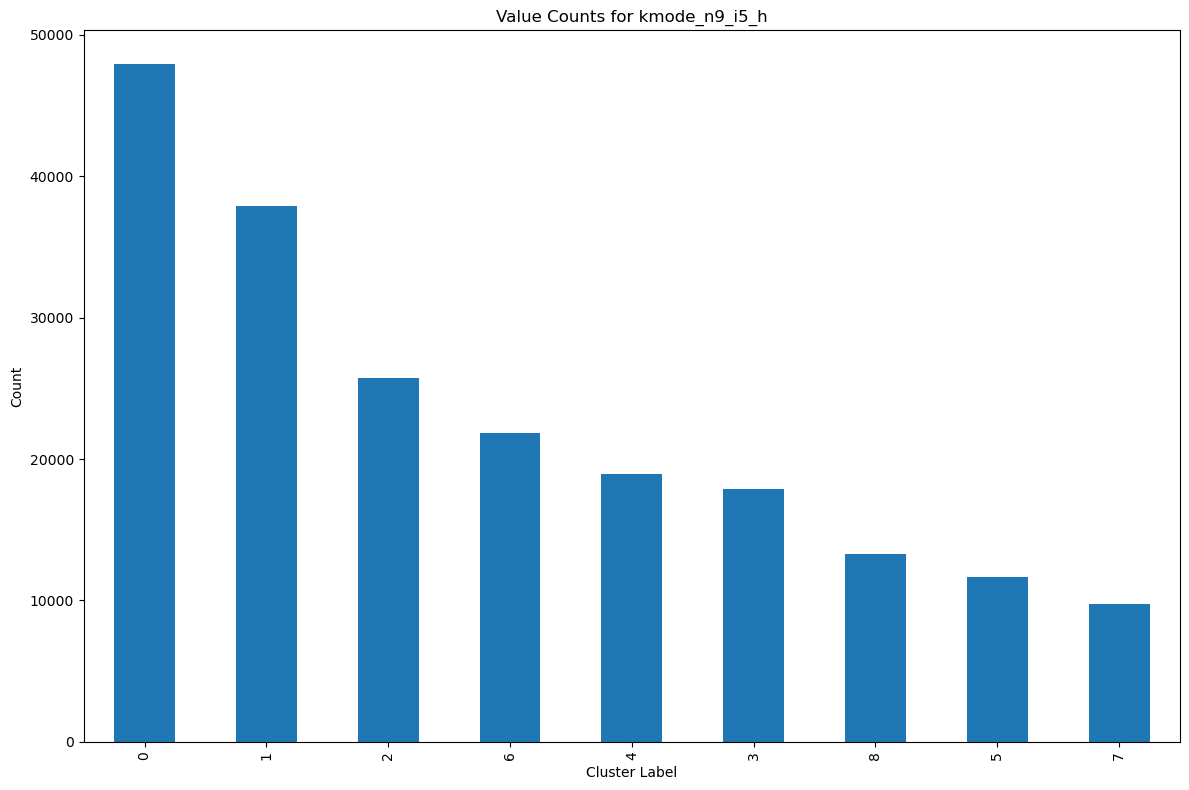

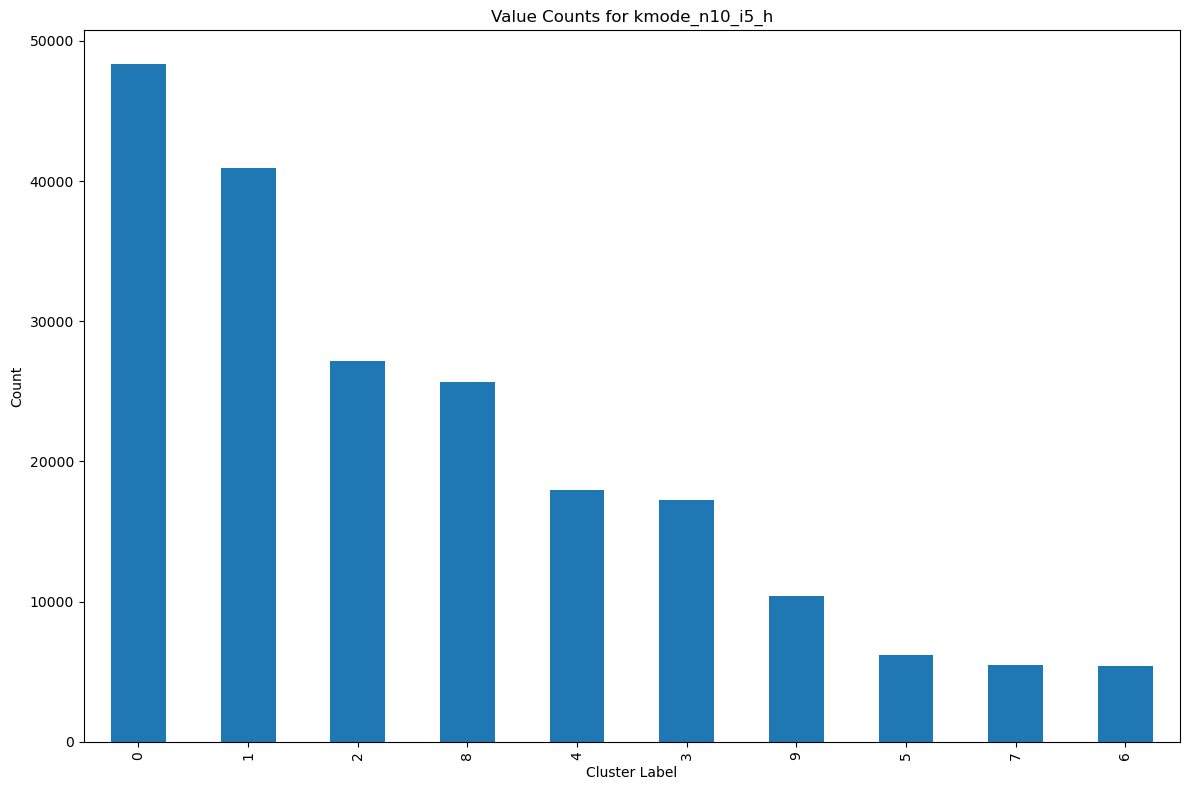

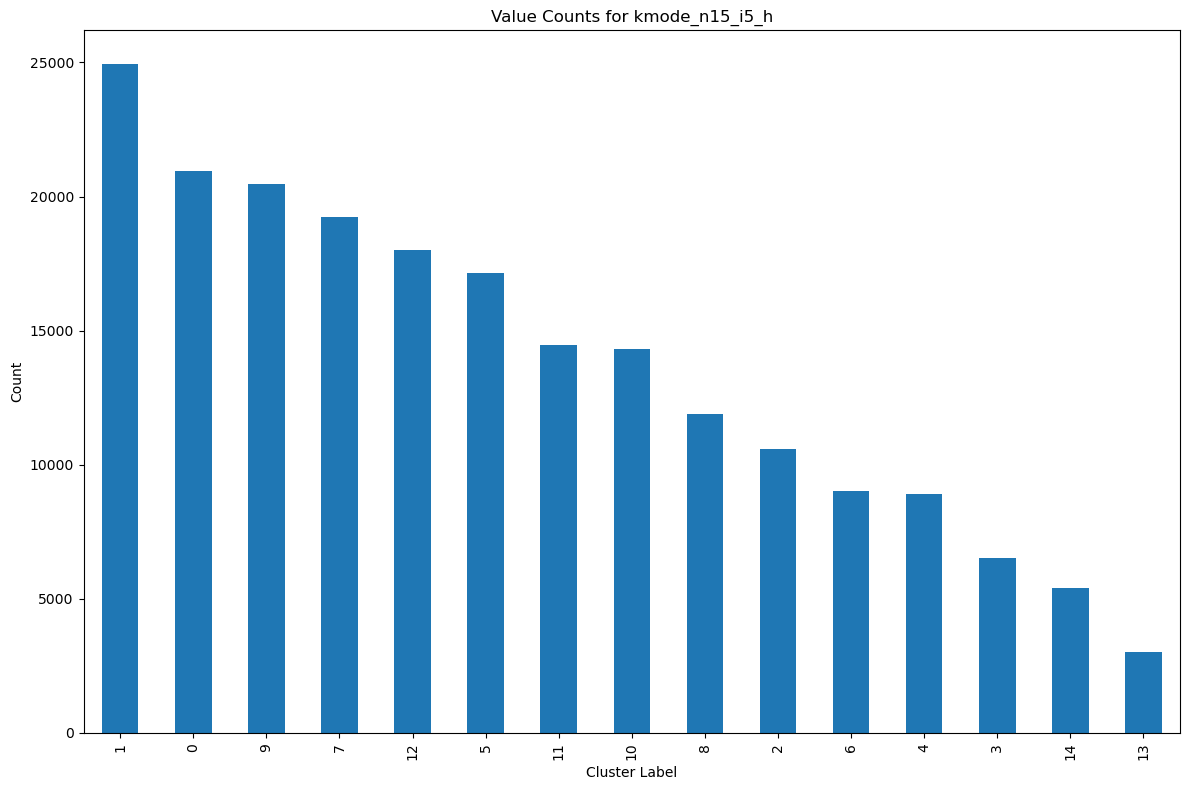

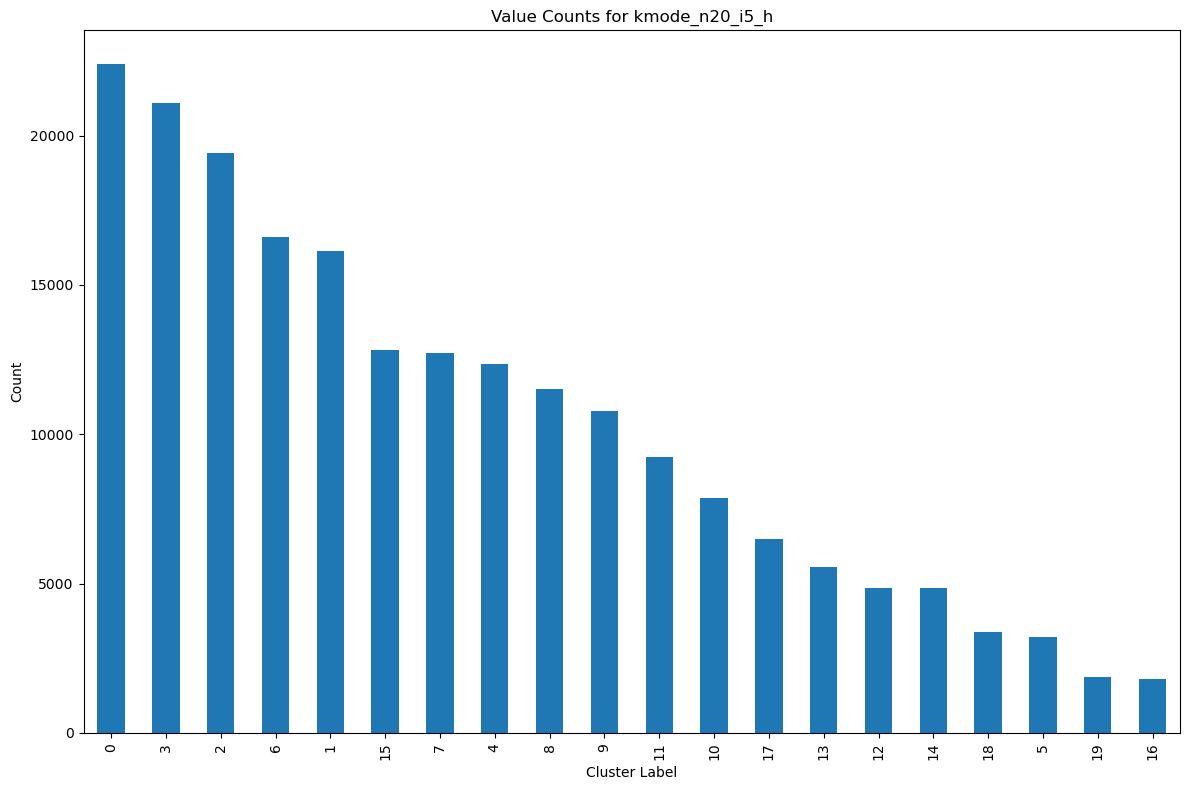

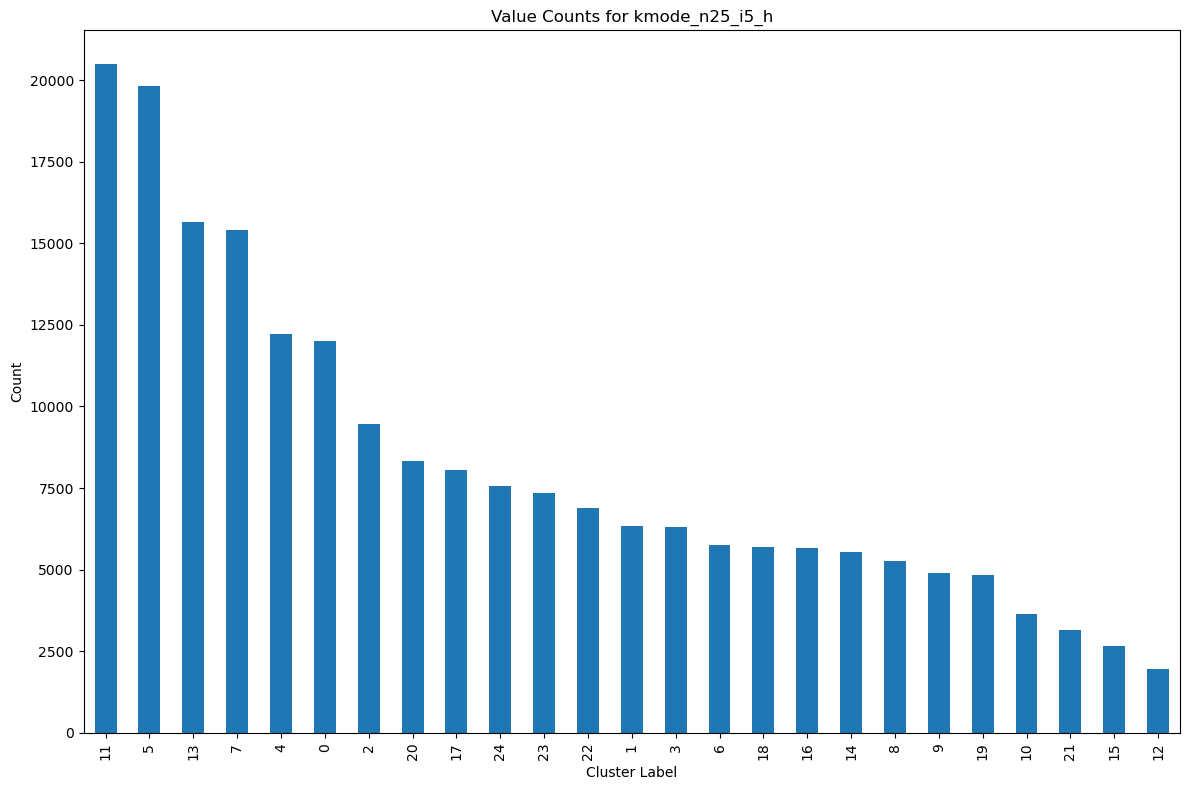

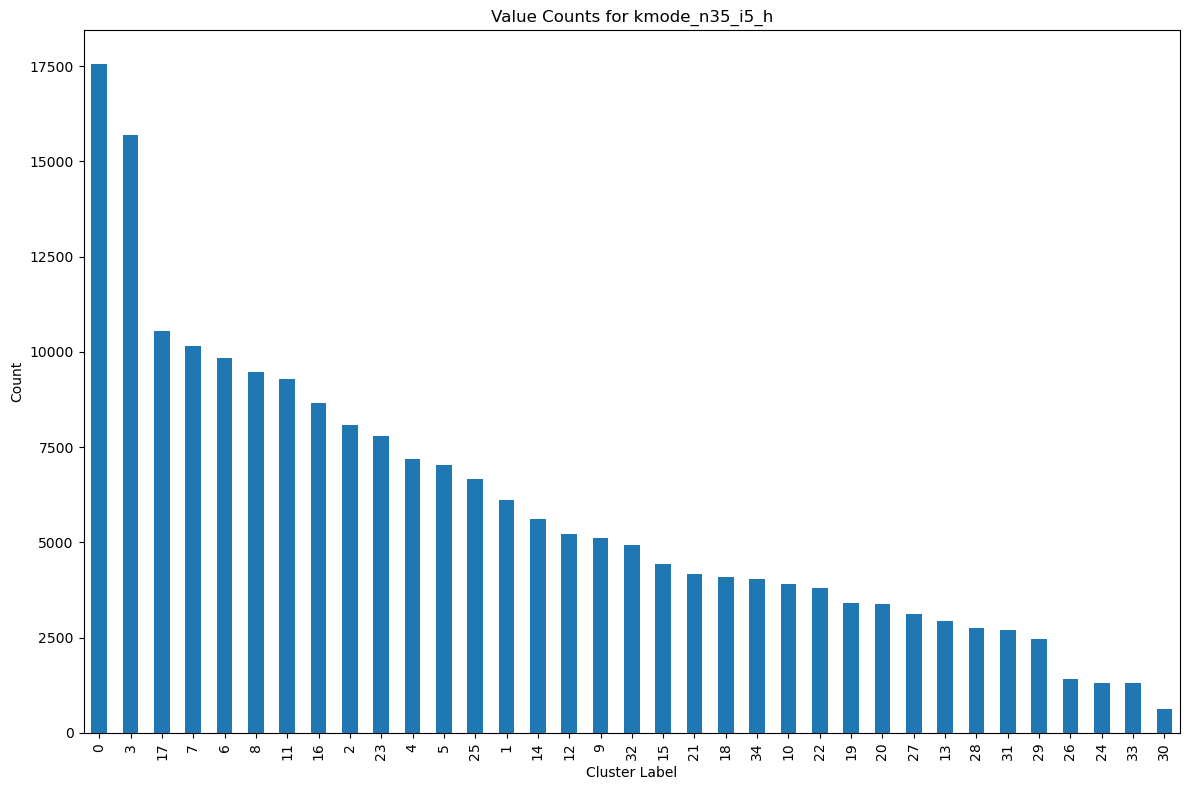

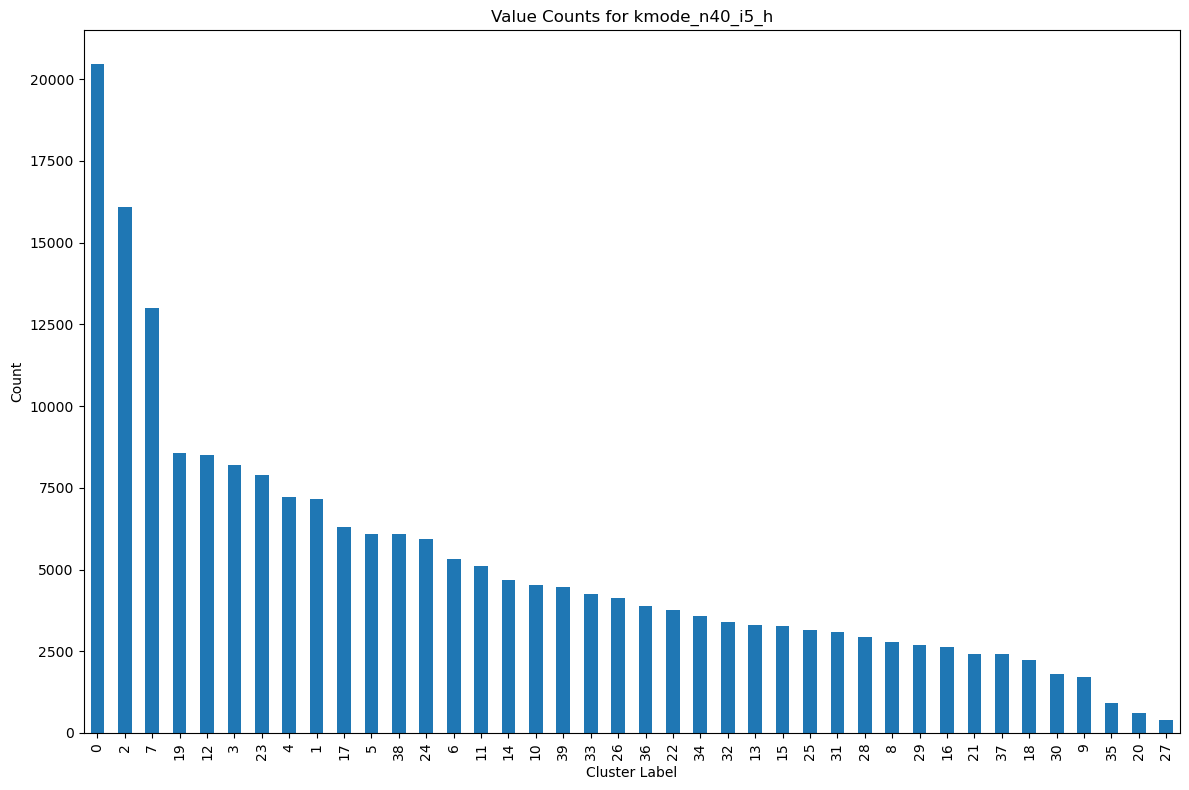

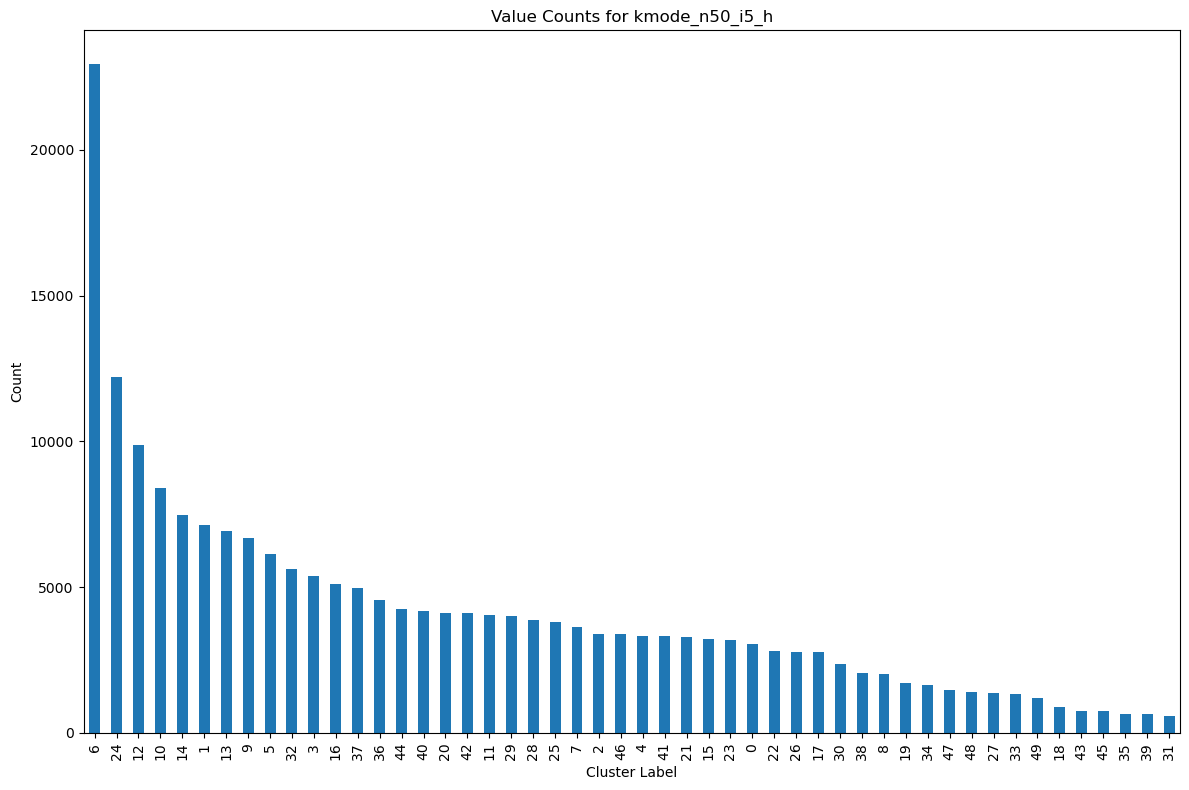

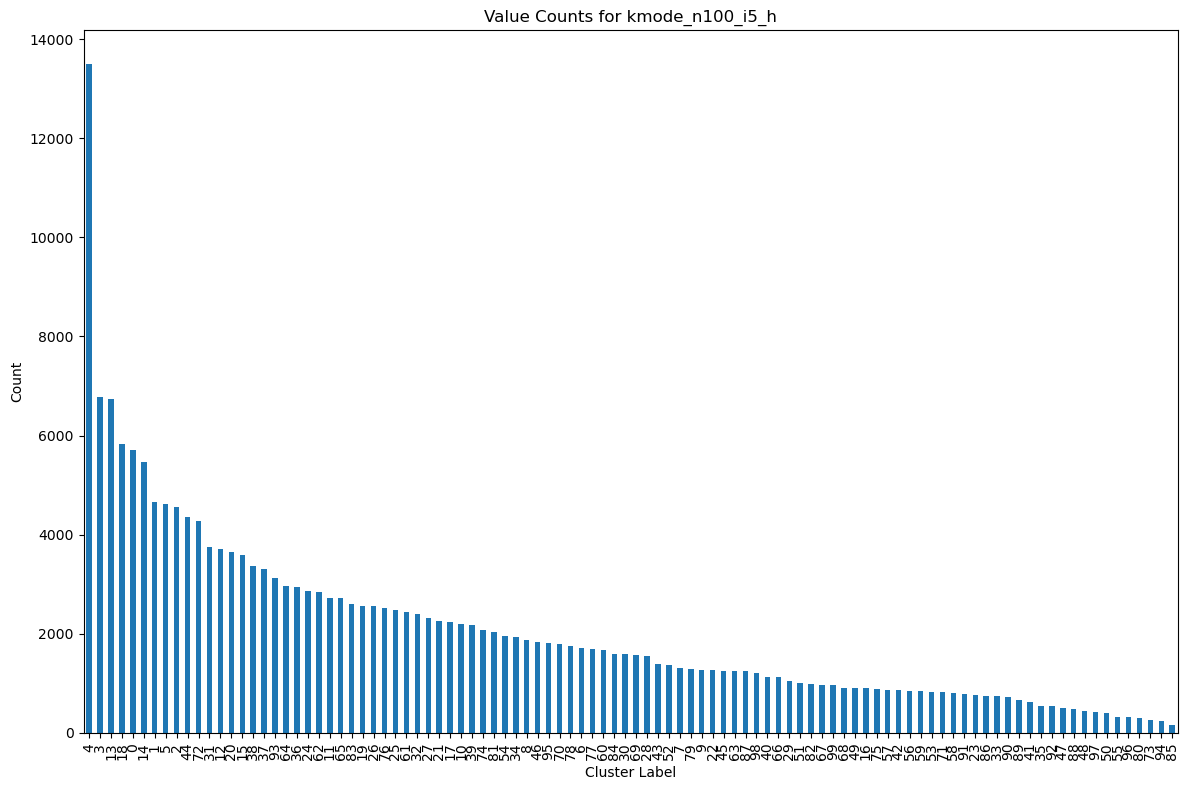

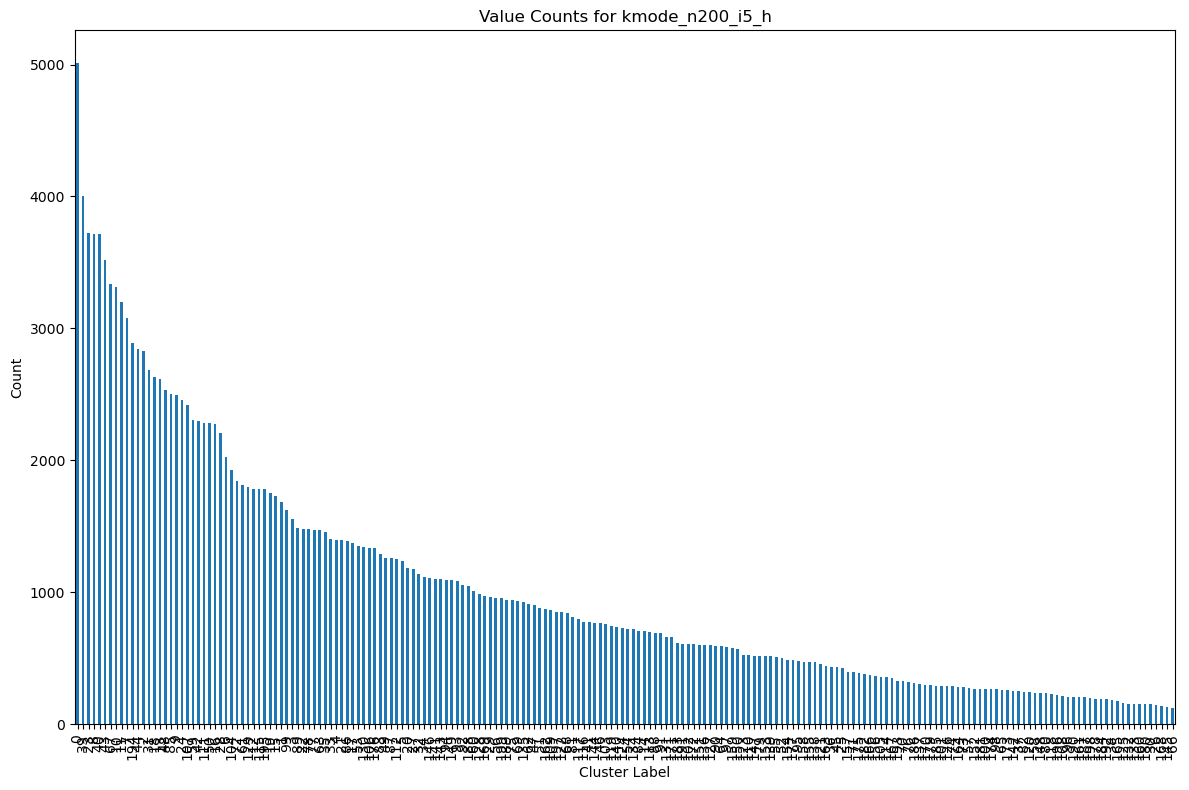

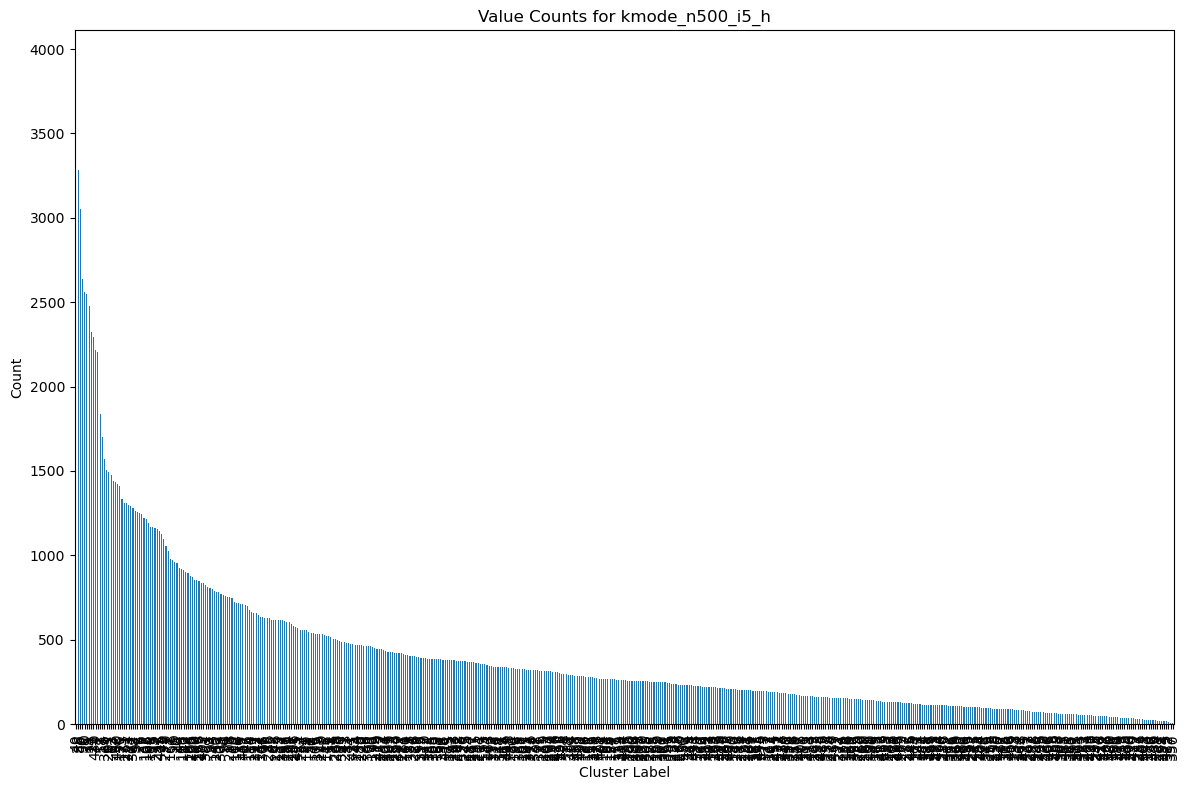

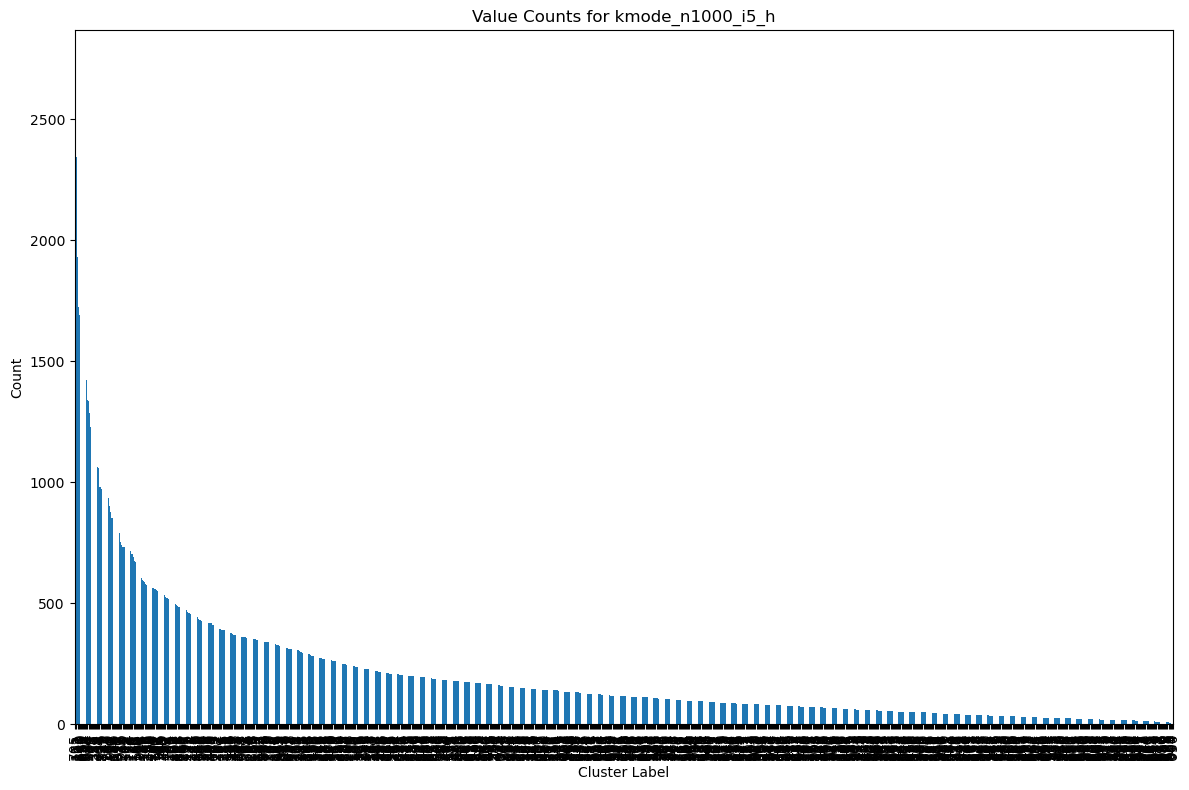

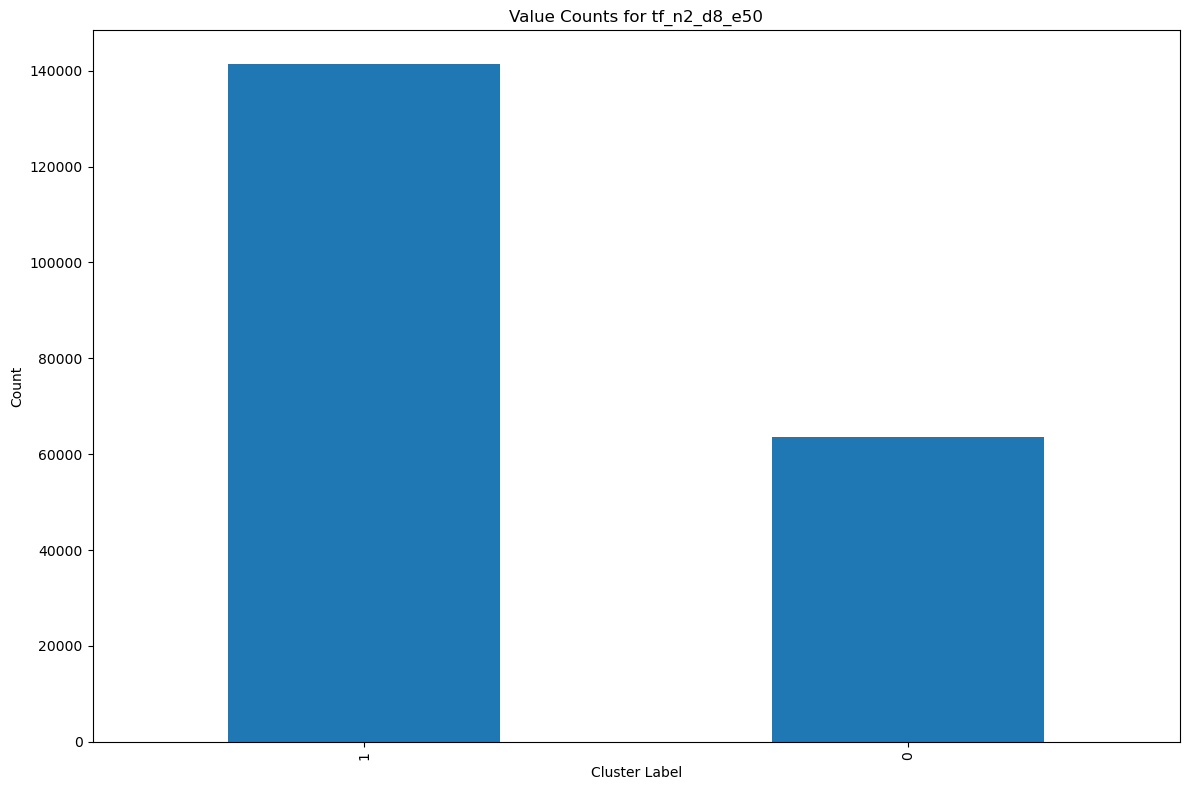

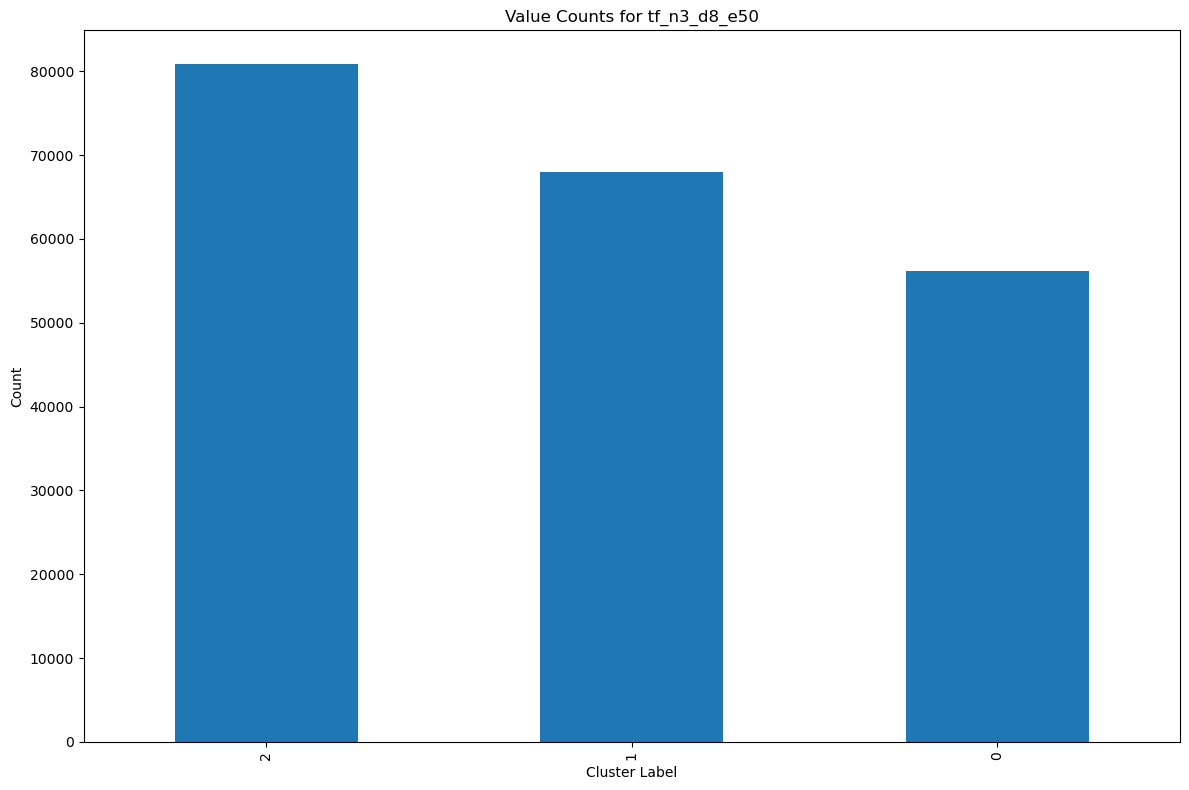

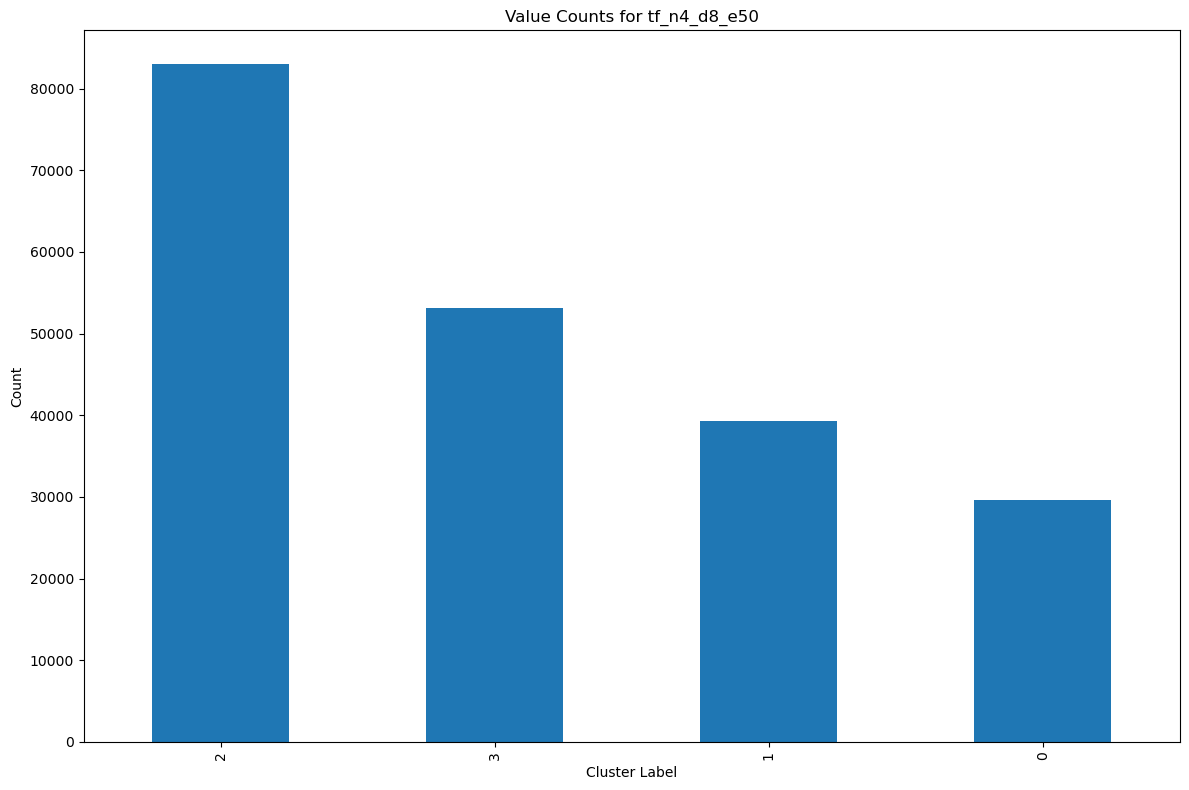

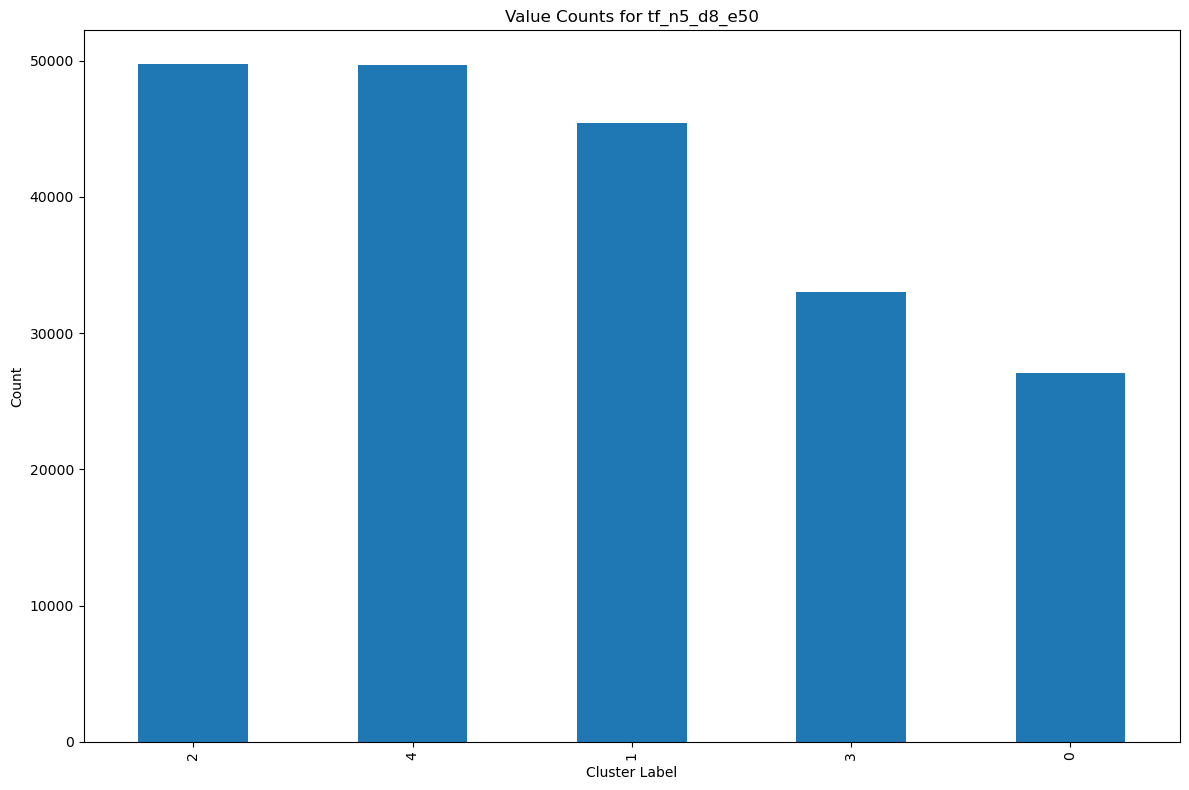

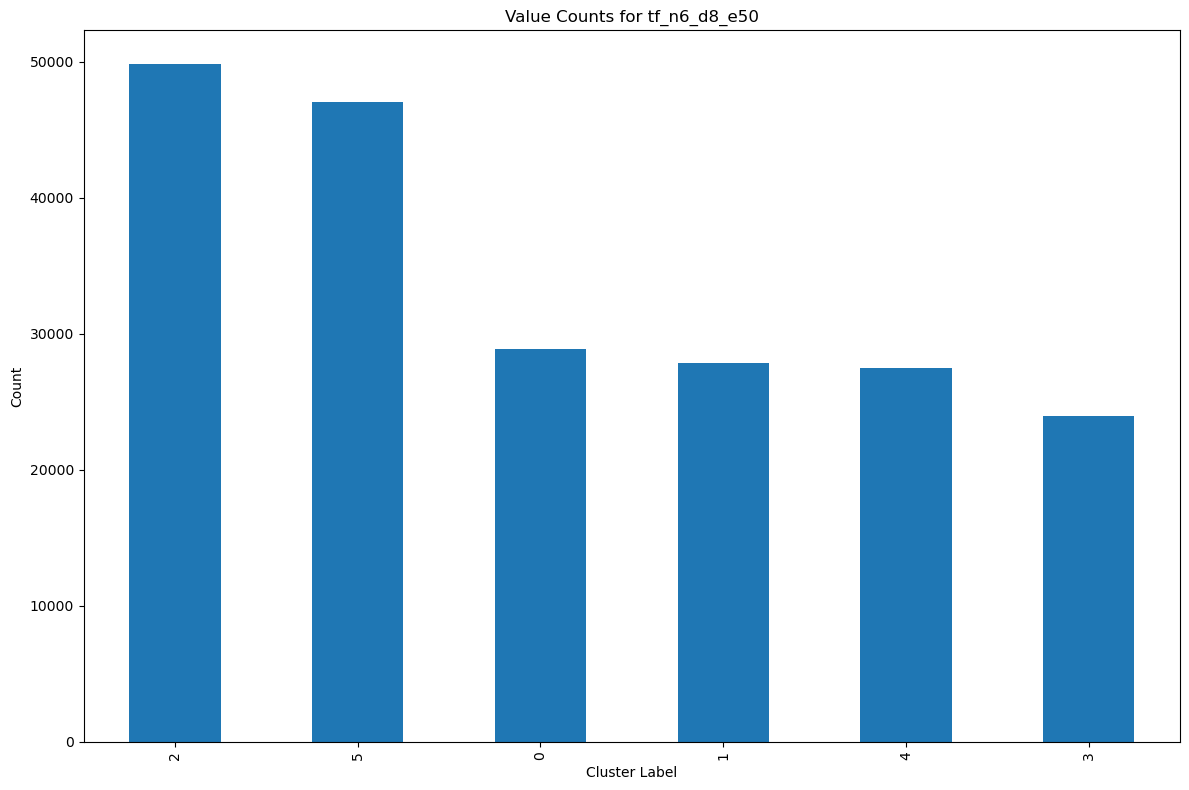

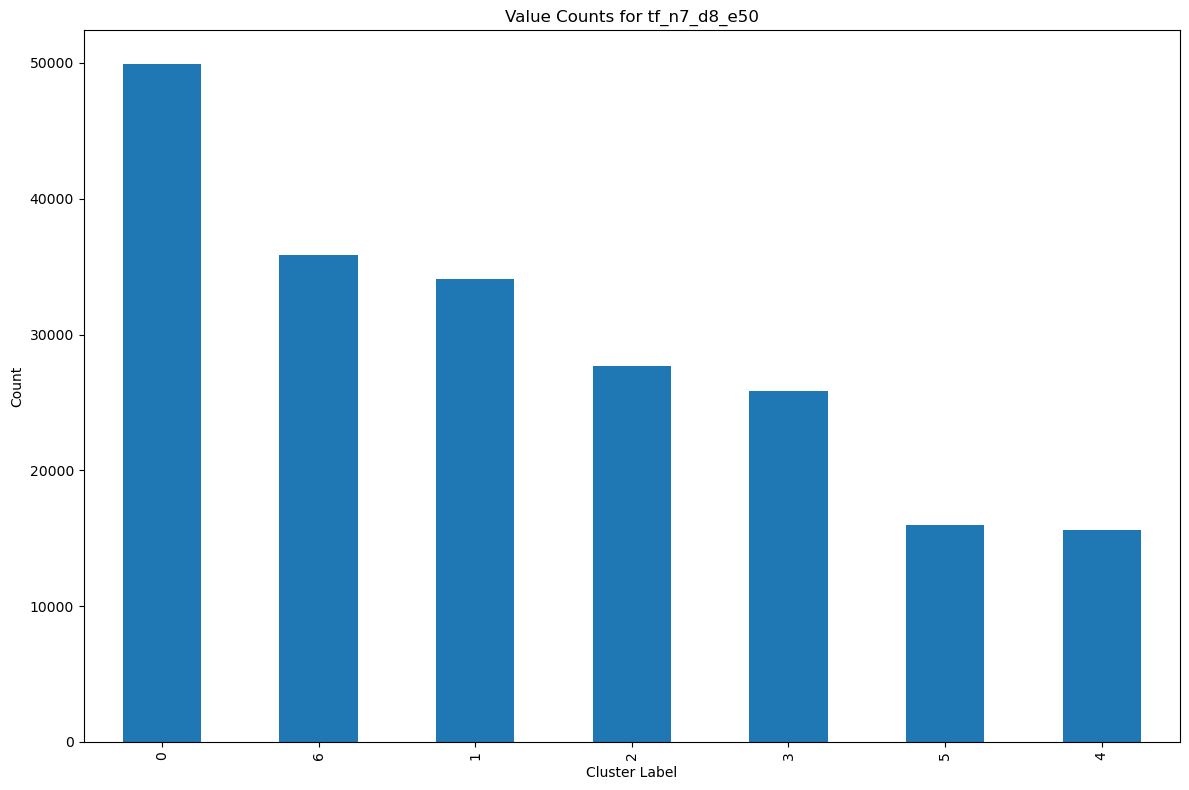

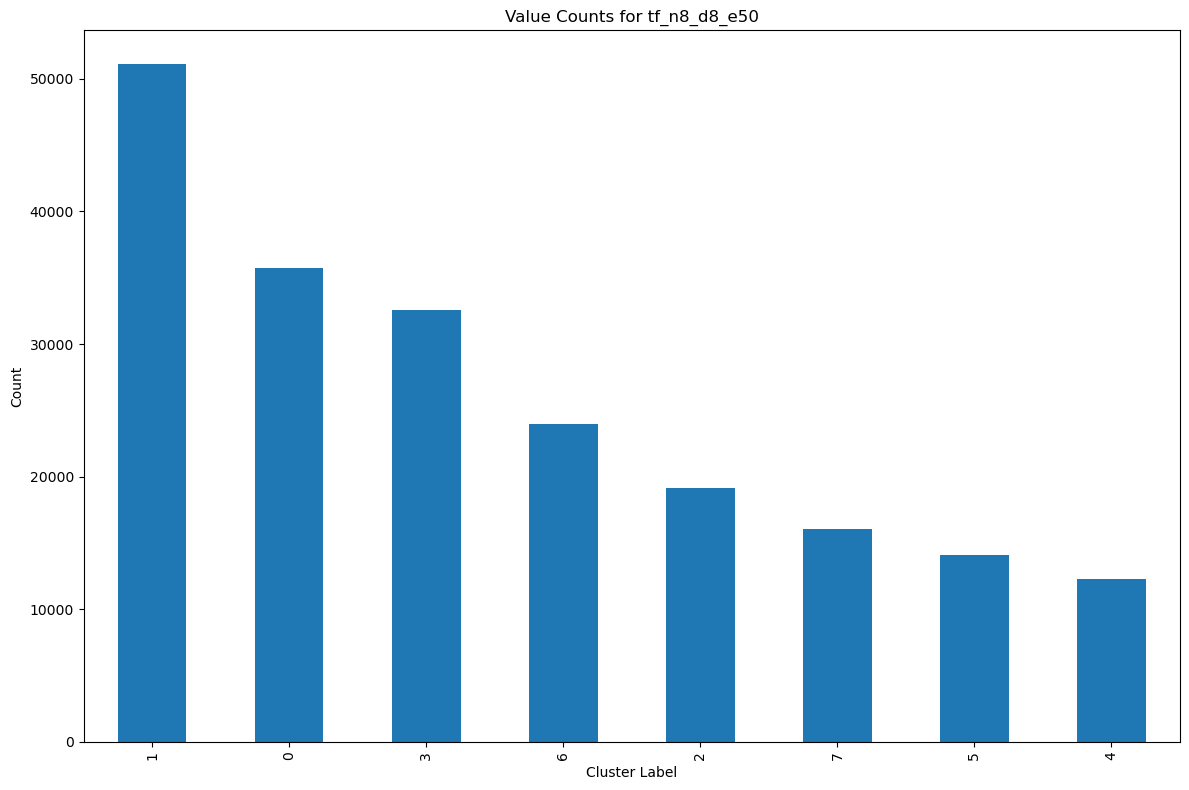

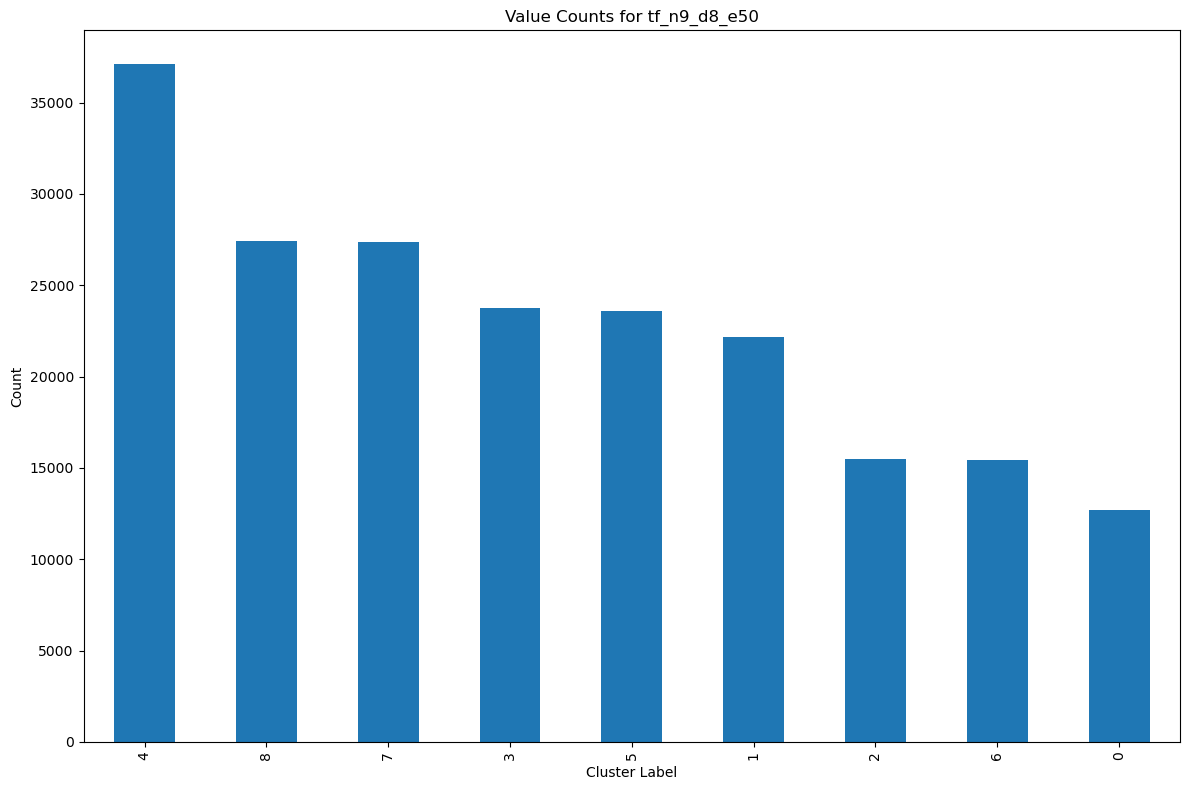

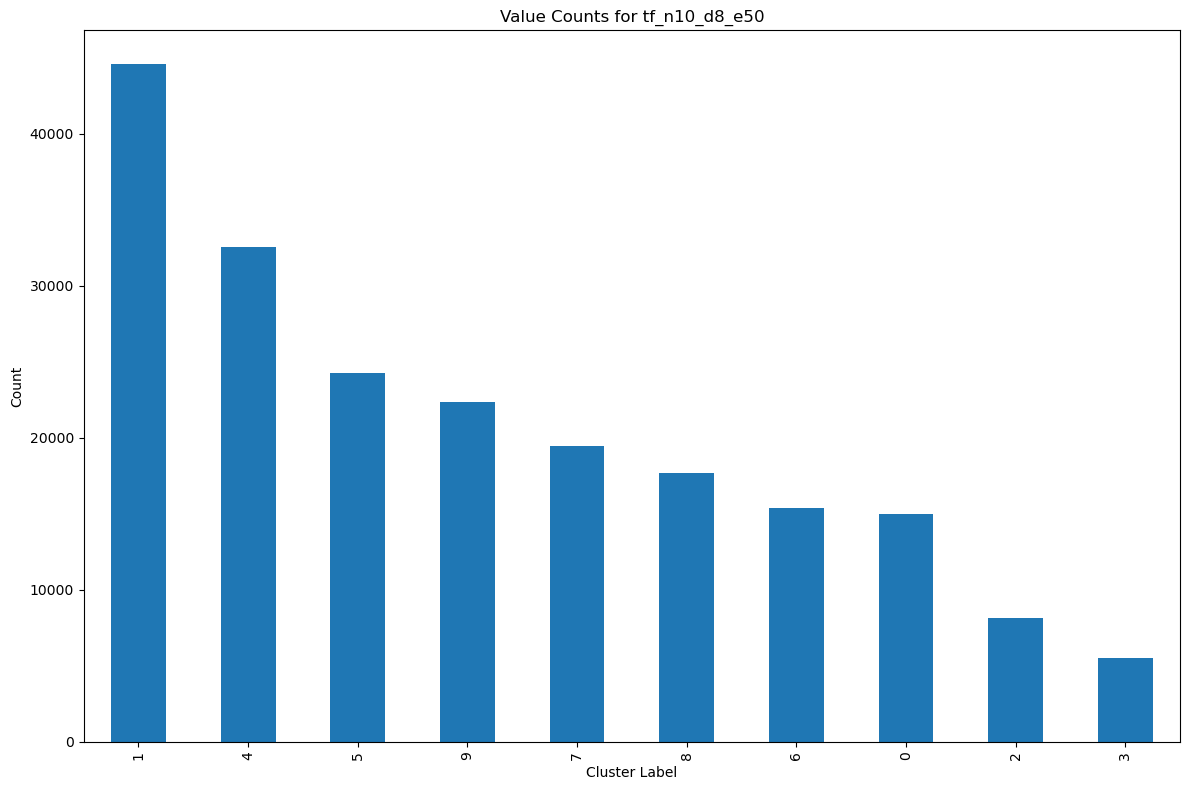

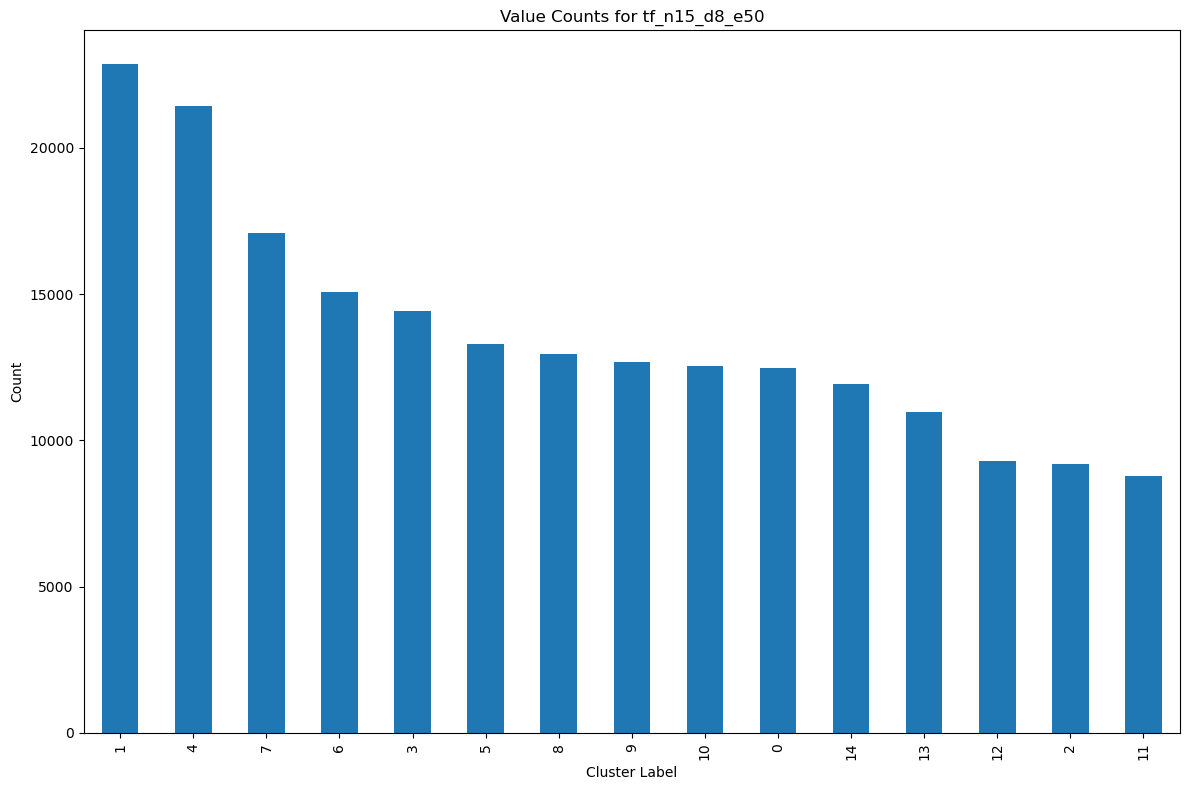

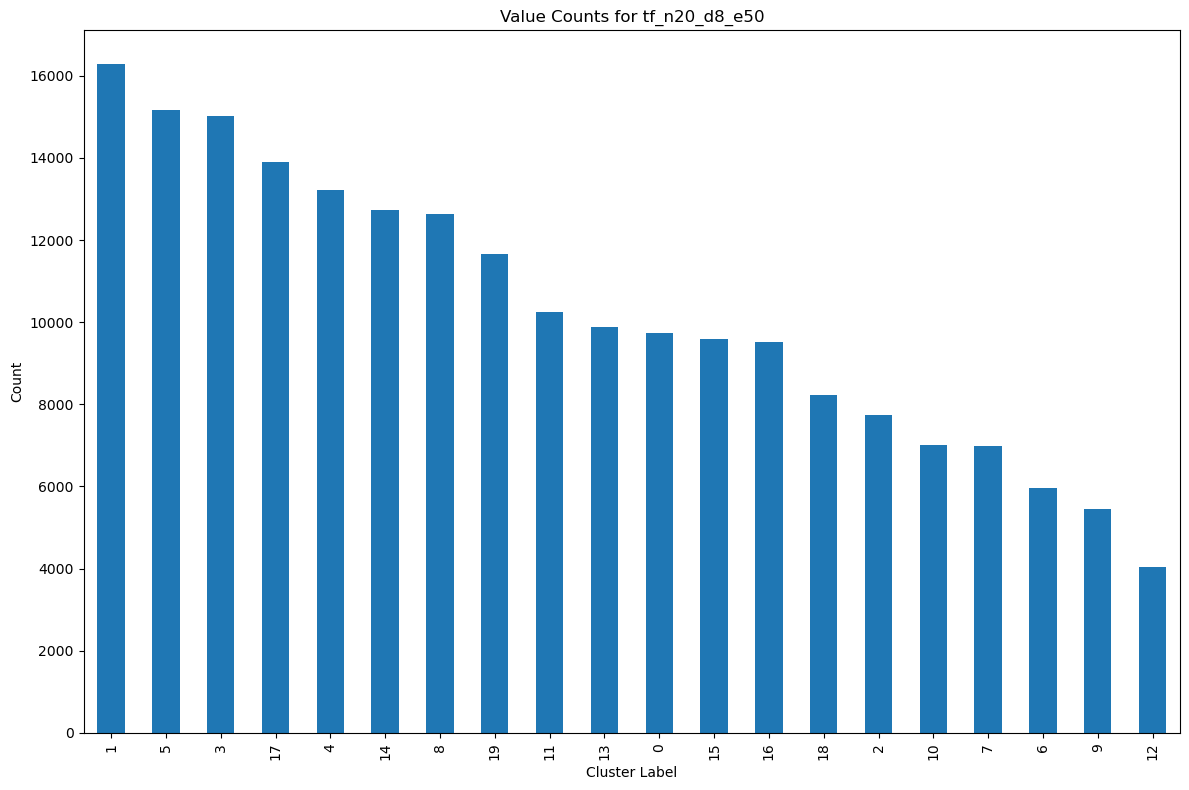

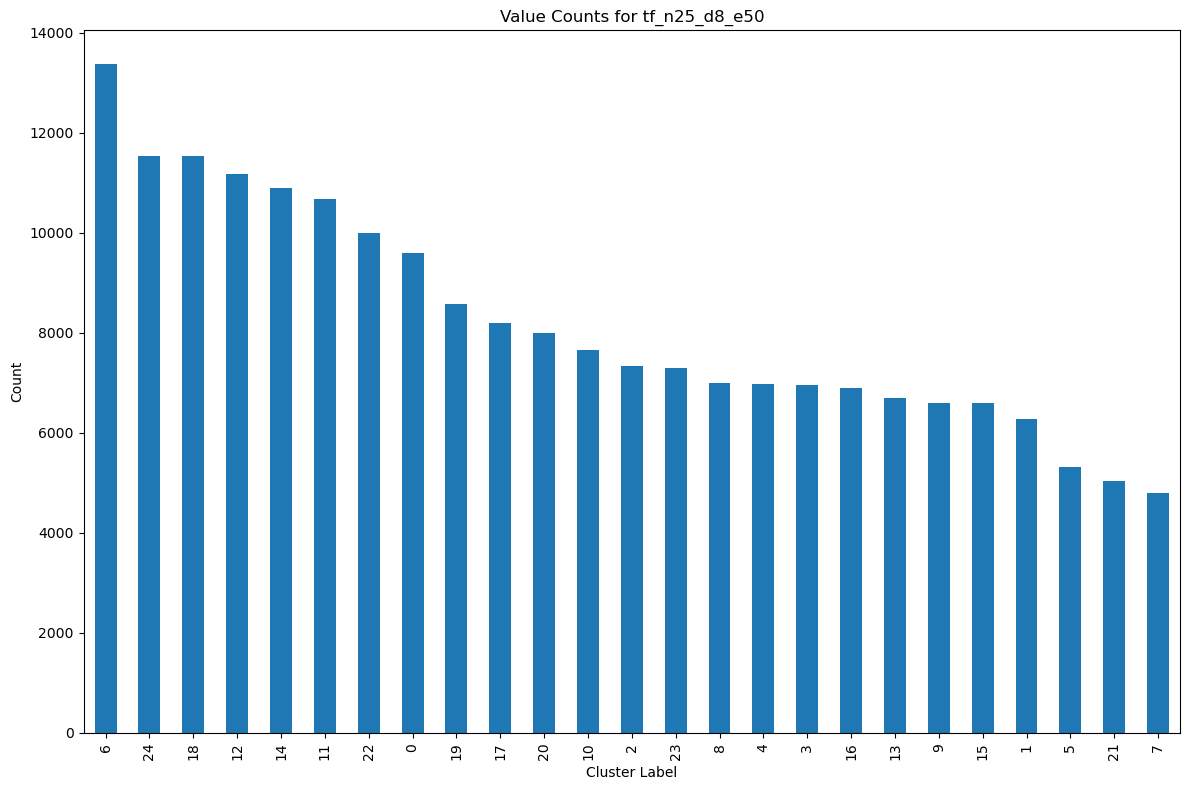

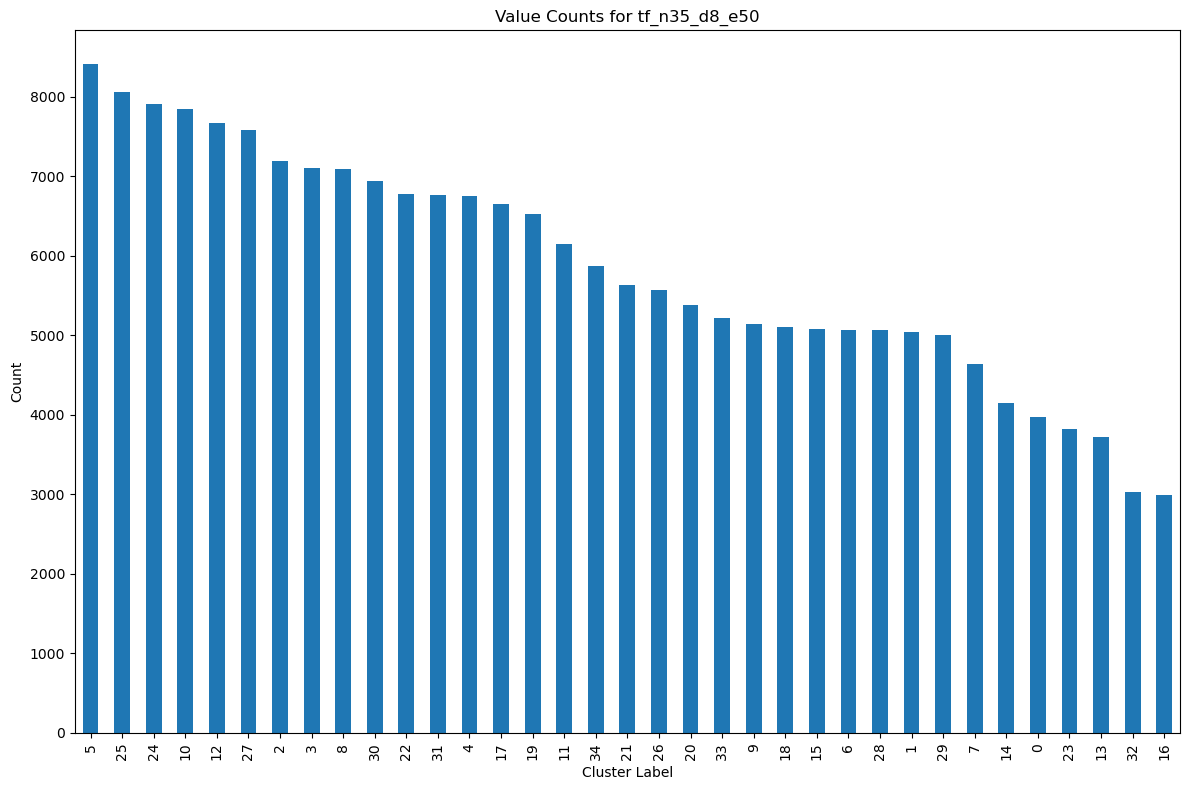

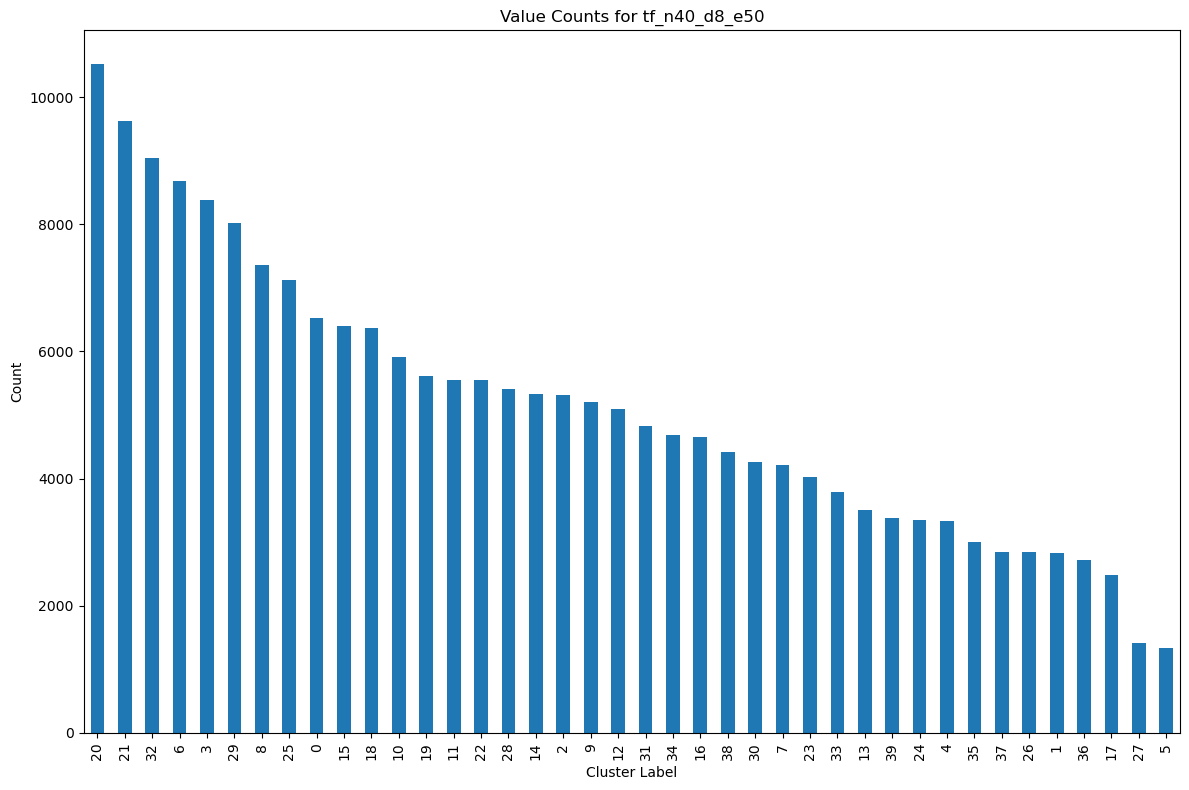

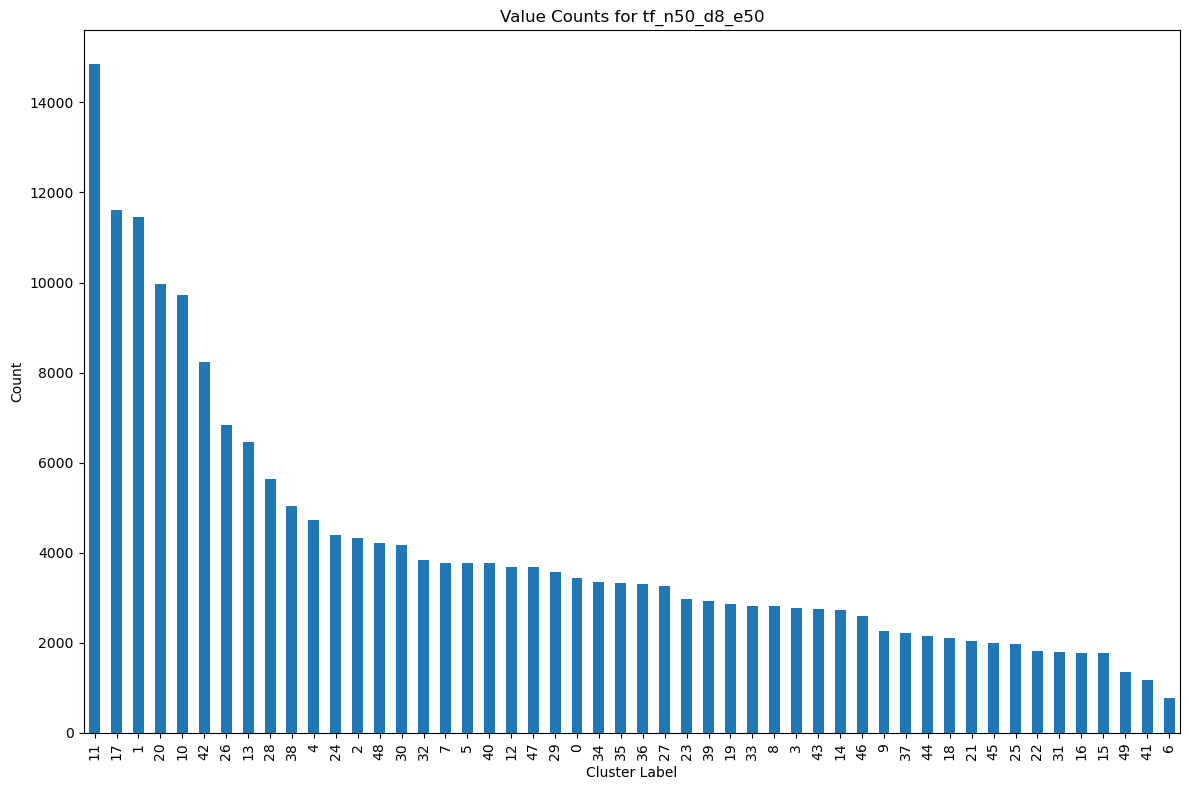

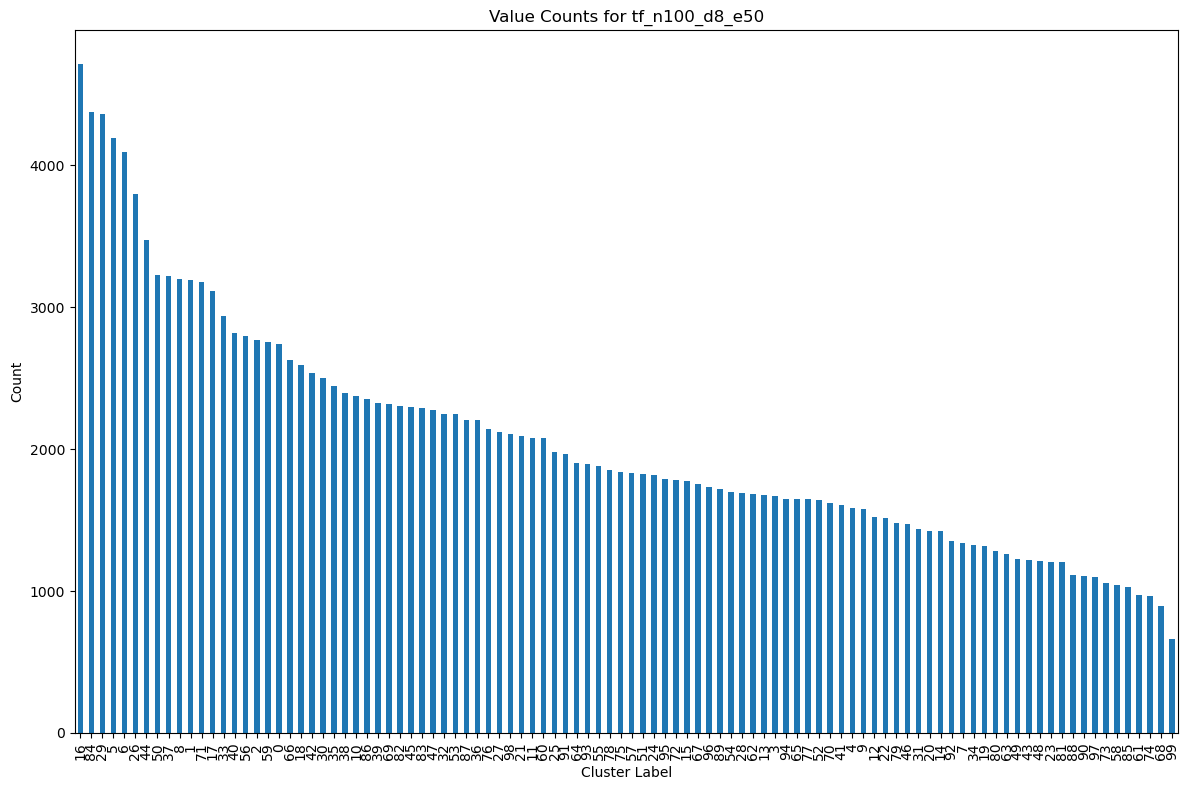

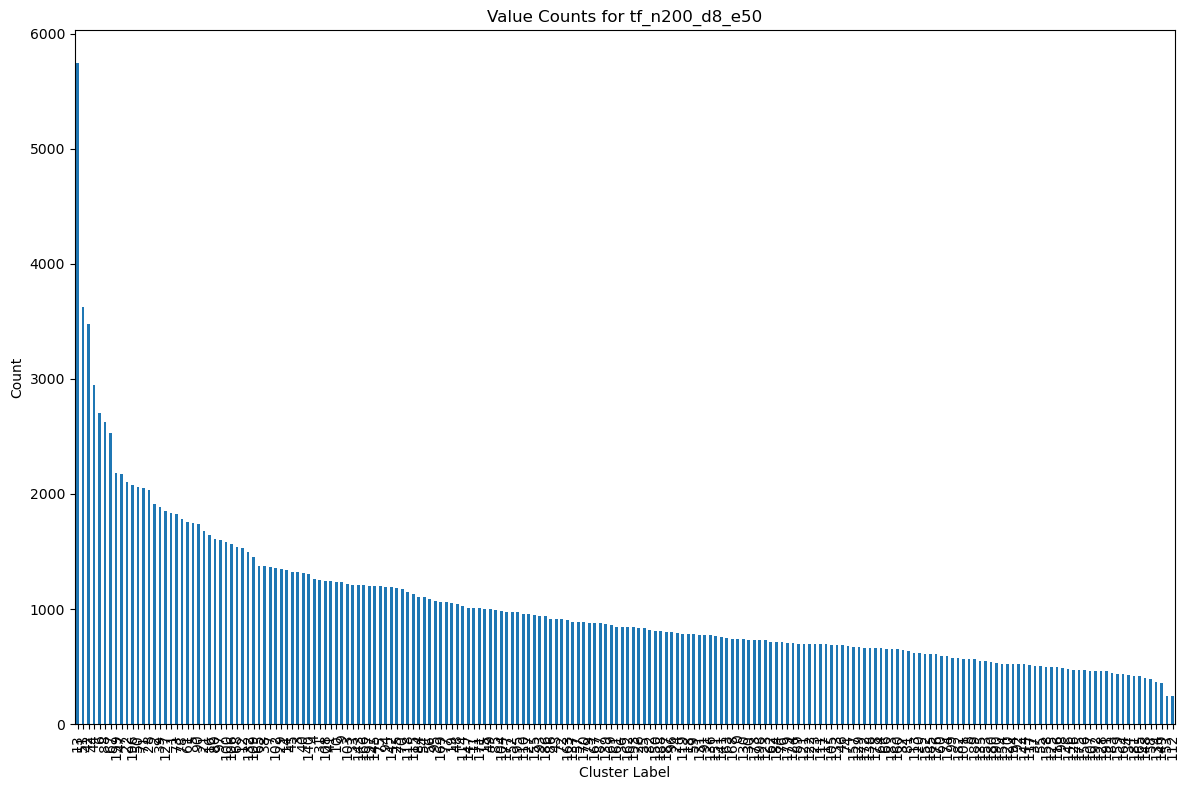

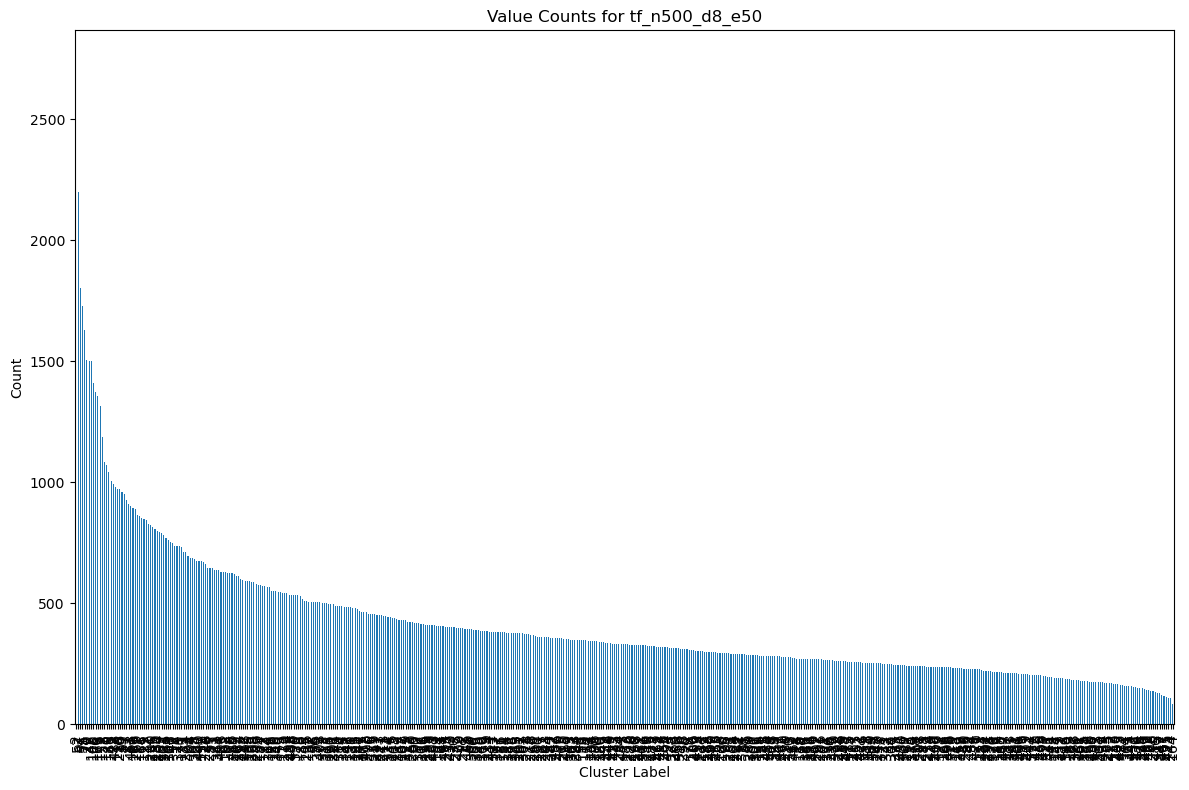

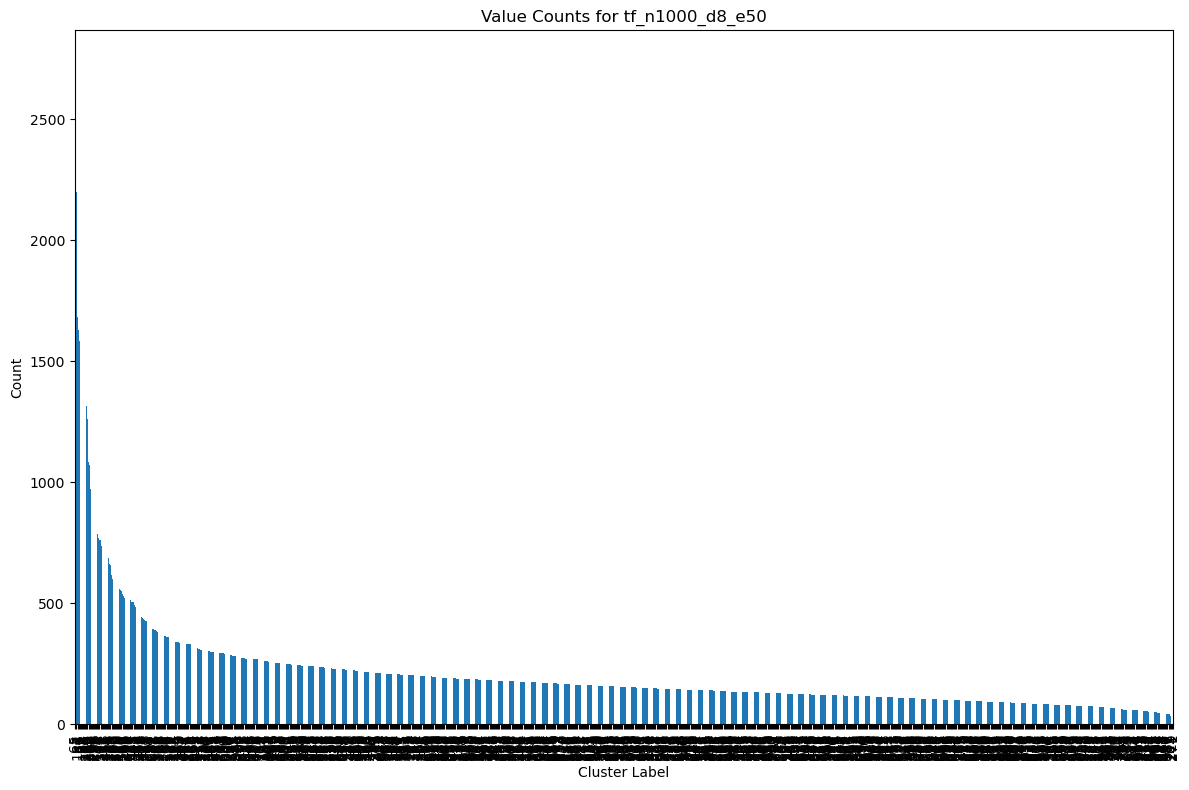

In [150]:
plot_cols = [col for col in cluster_df_train.columns if col.startswith('kmode') or col.startswith('tf')]

for col in plot_cols:
    counts = cluster_df_train[col].value_counts().sort_values(ascending=False)

    plt.figure(figsize=(12, 8))
    counts.plot(kind='bar')
    plt.title(f'Value Counts for {col}')
    plt.xlabel('Cluster Label')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

## MCA Dimensonality reduction

In [70]:
mca_df_train = df_train.copy()
mca_df_val = df_val.copy()
print(feature_list)
mca_df_train=mca_df_train[feature_list]
mca_df_val=mca_df_val[feature_list]
print(mca_df_train.head())

['EDUCA', 'DEAF', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'SMOKE100', 'ECIGNOW2', 'FLUSHOT7', 'PNEUVAC4', 'SEATBELT', 'COVIDPO1', 'GENHLTH', 'EXERANY2', 'TOLDHI3']
                        EDUCA DEAF BLIND DECIDE DIFFWALK DIFFDRES DIFFALON  \
0  Some College or Associates   No    No     No      Yes       No       No   
1            Some High School   No    No     No       No       No       No   
2  Bachelors degree or Higher   No    No     No       No       No       No   
3  Bachelors degree or Higher  Yes    No     No      Yes       No       No   
4  Bachelors degree or Higher   No    No     No       No       No       No   

  SMOKE100 ECIGNOW2 FLUSHOT7 PNEUVAC4 SEATBELT COVIDPO1    GENHLTH EXERANY2  \
0       No    Never       No      Yes   Always       No       Good       No   
1       No    Never      Yes      Yes   Always       No  Very good       No   
2       No    Never      Yes       No   Always      Yes  Very good      Yes   
3       No    Never      Yes      Ye

### Mca analysis

In [72]:
mca2_df_train = j_process.run_mca(mca_df_train,combined_feat,n_components=2)
mca2_df_val=j_process.run_mca(mca_df_val,combined_feat,n_components=2)

mca7_df_train = j_process.run_mca(mca_df_train,combined_feat,n_components=7)
mca7_df_val=j_process.run_mca(mca_df_val,combined_feat,n_components=7)

mca13_df_train = j_process.run_mca(mca_df_train,combined_feat,n_components=13)
mca13_df_val=j_process.run_mca(mca_df_val,combined_feat,n_components=13)

mca20_df_train = j_process.run_mca(mca_df_train,combined_feat,n_components=20)
mca20_df_val=j_process.run_mca(mca_df_val,combined_feat,n_components=20)
#print(mca7_df_train.head())
#print(mca7_df_val.shape)
#print(mca_df_val.head())
#print(mca_df_val.shape)

mca2_df_train = pd.concat([mca2_df_train,df_train],axis=1)
mca2_df_val= pd.concat([mca2_df_val,df_val],axis=1)
print(mca7_df_train.head())


      mca_0     mca_1     mca_2     mca_3     mca_4     mca_5     mca_6
0  0.275469 -0.026590 -0.083693  0.386333 -0.301810 -0.197934 -0.158284
1  0.116440 -0.285873 -0.142895  0.344235  0.471143  0.135904  0.376115
2 -0.425141 -0.108207  0.330608 -0.184980 -0.023869  0.062703  0.055438
3  0.334040 -0.723237 -0.078656  0.266953  0.032822 -0.031557 -0.085018
4 -0.359375  0.193412  0.243237  0.022263 -0.179100 -0.021574  0.135598


In [73]:
print(feature_list)

['EDUCA', 'DEAF', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'SMOKE100', 'ECIGNOW2', 'FLUSHOT7', 'PNEUVAC4', 'SEATBELT', 'COVIDPO1', 'GENHLTH', 'EXERANY2', 'TOLDHI3']


In [74]:
# Keep only columns starting with 'mca_' or 'ALL_'
#mca2_df_train = mca2_df_train[[col for col in mca2_df_train.columns if col.startswith("mca_") or col.startswith("ALL_")]]
#mca2_df_val = mca2_df_val[[col for col in mca2_df_val.columns if col.startswith("mca_") or col.startswith("ALL_")]]


In [75]:
mca_only=[]
mca_list=["mca_0","mca_1"]
for target in target_labels:
    print(target)
    results = j_process.run_logistic_model(mca2_df_train,mca2_df_val,mca_list,target)
    print(target)
    mca_only.append(results)
    results = j_process.run_tf_model(mca2_df_train,mca2_df_val,mca_list,target,verbose=1)
    #results = j_process.run_rf_model(mca7_df_train,mca7_df_val,feature_list,target)
    ### Random forest doesnt work on non categorical data well...left for future use. could possibly group scores, ie, 1= [1,.50) 0= [.50,-
    mca_only.append(results)

Running logistic regression for target: ALL_CHRONIC2:
Validation Scores for ALL_CHRONIC2 -> Accuracy: 0.6763, Precision: 0.6776, Recall: 0.6224, F1: 0.6488
ALL_CHRONIC2
Epoch 1/30
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6728 - loss: 0.6148 - precision: 0.6678 - recall: 0.6350 - val_accuracy: 0.6772 - val_loss: 0.6048 - val_precision: 0.6733 - val_recall: 0.6374
Epoch 2/30
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 1s 896us/step - accuracy: 0.6818 - loss: 0.6042 - precision: 0.6698 - recall: 0.6682 - val_accuracy: 0.6792 - val_loss: 0.6056 - val_precision: 0.6668 - val_recall: 0.6641
Epoch 3/30
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 2s 932us/step - accuracy: 0.6789 - loss: 0.6051 - precision: 0.6663 - recall: 0.6654 - val_accuracy: 0.6785 - val_loss: 0.6050 - val_precision: 0.6637 - val_recall: 0.6706
Epoch 4/30
1602/1602 ━━━━━━━━━━━━━━━━━━━━ 1s 907us/step - accuracy: 0.6794 - loss: 0.6043 - precision: 0.6663 - recall: 0.6642 - val_accuracy: 0.6779 - val_loss: 0.6049 - val_precision: 0.669

In [76]:
print(mca_only)


[{'accuracy': 0.6918513964317837, 'precision': 0.801854496814709, 'recall': 0.6587141952545909, 'f1_score': 0.7232702473339263}, {'accuracy': 0.6946180733454019, 'precision': 0.8039406415418722, 'recall': 0.6618802845755578, 'f1_score': 0.726026557711951}, {'accuracy': 0.7315526408671198, 'precision': 0.24482123676538284, 'recall': 0.6211796768541951, 'f1_score': 0.3512189752902977}, {'accuracy': 0.6756953695164577, 'precision': 0.2230670965387189, 'recall': 0.7138407630912984, 'f1_score': 0.33991472005932516}, {'accuracy': 0.6982045063815737, 'precision': 0.32082709939770593, 'recall': 0.48718396830944893, 'f1_score': 0.38688039229292437}, {'accuracy': 0.6706402067607109, 'precision': 0.3044230129697373, 'recall': 0.5332634277059304, 'f1_score': 0.3875857396900669}, {'accuracy': 0.6763101866083729, 'precision': 0.6775808241091932, 'recall': 0.6223723189951416, 'f1_score': 0.6488042296669632}, {'accuracy': 0.6772096412428413, 'precision': 0.6732926096535149, 'recall': 0.637374096456926

In [77]:
print(mca_only)

[{'accuracy': 0.6918513964317837, 'precision': 0.801854496814709, 'recall': 0.6587141952545909, 'f1_score': 0.7232702473339263}, {'accuracy': 0.6946180733454019, 'precision': 0.8039406415418722, 'recall': 0.6618802845755578, 'f1_score': 0.726026557711951}, {'accuracy': 0.7315526408671198, 'precision': 0.24482123676538284, 'recall': 0.6211796768541951, 'f1_score': 0.3512189752902977}, {'accuracy': 0.6756953695164577, 'precision': 0.2230670965387189, 'recall': 0.7138407630912984, 'f1_score': 0.33991472005932516}, {'accuracy': 0.6982045063815737, 'precision': 0.32082709939770593, 'recall': 0.48718396830944893, 'f1_score': 0.38688039229292437}, {'accuracy': 0.6706402067607109, 'precision': 0.3044230129697373, 'recall': 0.5332634277059304, 'f1_score': 0.3875857396900669}, {'accuracy': 0.6763101866083729, 'precision': 0.6775808241091932, 'recall': 0.6223723189951416, 'f1_score': 0.6488042296669632}, {'accuracy': 0.6772096412428413, 'precision': 0.6732926096535149, 'recall': 0.637374096456926

In [78]:
print(mca_set.head())
print(combined_feat)

  DEAF BLIND DECIDE DIFFWALK DIFFDRES DIFFALON SMOKE100 FLUSHOT7 PNEUVAC4  \
0   No    No     No      Yes       No       No       No       No      Yes   
1   No    No     No       No       No       No       No      Yes      Yes   
2   No    No     No       No       No       No       No      Yes       No   
3  Yes    No     No      Yes       No       No       No      Yes      Yes   
4   No    No     No       No       No       No       No       No       No   

  COVIDPO1 EXERANY2 TOLDHI3    GENHLTH SEATBELT ECIGNOW2  \
0       No       No      No       Good   Always    Never   
1       No       No     Yes  Very good   Always    Never   
2      Yes      Yes      No  Very good   Always    Never   
3       No       No     Yes  Very good   Always    Never   
4      Yes      Yes      No       Good   Always    Never   

                        EDUCA  
0  Some College or Associates  
1            Some High School  
2  Bachelors degree or Higher  
3  Bachelors degree or Higher  
4  Bachelors deg